In [1]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from torch.distributions import Normal, Independent, kl_divergence 
from collections import namedtuple
from math import e, cos, sin, pi, atan2, asin, sqrt, tan

### Quadrotor Dynamical Data Generator

In [54]:
class Quadrotor_Dynamics_Generator():

  def __init__(self,
               x_size=27,
               y_size=12,
               traj_length=2,
               normalize=True,
               xy_offset=20,
               min_Z=0,
               max_Z=50,
               xydot_offset=60.0,
               min_Zdot = -30,
               max_Zdot = 30,
               min_accel_xy = -30,
               max_accel_xy = 30,
               min_accel_z = -30,
               max_accel_z = 30, 
               min_omega=-80,
               max_omega=80,
               min_omegadot=-80,
               max_omegadot=80,
               min_rp = -pi/2 + 0.1,
               max_rp = pi/2 - 0.1,
               min_rotor_rps = 0,
               max_rotor_rps = 1000,
               perturb_rps=10,
               ground_effect=False,
               wind_vel_offset = 25,
               Z_thresh=2,
               min_mass=0.5,
               max_mass=20
              ):

    self.x_size = x_size
    self.y_size = y_size
    self.traj_length = traj_length
    self.normalize = normalize
    self.xy_offset = xy_offset
    self.min_Z = min_Z
    self.max_Z = max_Z
    self.xydot_offset = xydot_offset

    self.min_rp = min_rp
    self.max_rp = max_rp
    self.min_rotor_bound = min_rotor_rps
    self.max_rotor_bound = max_rotor_rps
    self.perturb_rps = perturb_rps
    self.ground_effect = ground_effect
    self.Z_thresh = Z_thresh
    self.min_m = min_mass
    self.max_m = max_mass
    self.constants = self.constants_init()

    # Initialize minmax data needed for relavent simulation parameters
    self.minmax_data = torch.tensor([[0, 0], #dt
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [self.min_m, self.max_m],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot]])
    

  # Evolves the dynamics of quadrotor
  def eqn_mtn(self, state_vec, uu, dt, V_w, rotor_disturbances=False, rotor_spike_bound=100, linvel_offset=torch.zeros([3,]), angvel_offset=torch.zeros([3,])):

    ########     NESTED FUNCTION     ########

    # Verify boundness of Euler angles
    def theta_check(theta):
      # Parsing euler angles
      roll = theta[0]
      pitch = theta[1]
      yaw = theta[2]

      # Ensuring euler angles remain within [-pi, pi]
      roll_offset = torch.abs(torch.floor(roll / (2*pi)))
      pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
      yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

      if roll > pi:
        roll -= roll_offset * (2*pi)
      elif roll < -pi:
        roll += roll_offset * (2*pi)

      if pitch > pi:
        pitch -= pitch_offset * (2*pi)
      elif pitch < -pi:
        pitch += pitch_offset * (2*pi)

      if yaw > pi:
        yaw -= yaw_offset * (2*pi)
      elif yaw < -pi:
        yaw += yaw_offset * (2*pi)

      theta_transformed = torch.tensor([roll, pitch, yaw])
      return theta_transformed
    
    ###########   END OF NESTED FUNCTION   ###########
    
    # Parsing positional and velocity states
    x = state_vec[:3]
    theta = state_vec[3:6]
    xdot = state_vec[6:9]
    thetadot = state_vec[9:12]
    omega = state_vec[12:15]
    omegadot = state_vec[15:18]
    a = state_vec[18:]
    
    # Checking if current altitude is at ground effect threshold  
    if x[2] <= 2 and x[2] > 0:
      self.ground_effect = True
    else:
      self.ground_effect = False  
      
    #print(f'EQN_MTN BEFORE: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}')


    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']


    # Incorporating rotor spiking (if applicable)
    if rotor_disturbances == True:
      uu_observed = uu.clone()
      uu = self.perturb_rv(uu_observed, rotor_spike_bound=rotor_spike_bound)

    # Integrating body rates
    omega = omega + dt * omegadot

    # Ensuring commanded velocities keep quadrotor within defined state space
    if linvel_offset.any():
      xdot = linvel_offset
    else:
      xdot = xdot + dt * a
      
    if angvel_offset.any():
      thetadot = angvel_offset
    else: 
      thetadot = self.omega2thetadot(omega, theta)

    # Integrating positional states
    theta = theta + dt * thetadot
    x = x + dt * xdot

    # Ensuring euler angles lie within appropriate bounds
    theta = theta_check(theta)
    
    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates from updated euler data
    omega = self.thetadot2omega(thetadot, theta)
    
    # Computing forces and moments from external perturbations
    V_w, F_w = self.inject_wind_peturb(V_w, dt)
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(z=x[2],z_thresh=2)
    else:
      Fg = torch.zeros_like(F_bf)

    # Computing exogenous disturbances
    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Compute linear and angular accelerations.
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero, prev_a=a)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=omegadot)

    # Updating state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)
    #print(f'EQN_MTN AFTER: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}, V_w: {V_w}')
    
    return state_vec, V_w, F_aero, tau_aero
  
  ####   QUADROTOR PHYSICS FUNCTIONS   ####
  
  # Compute translational accelerations
  def acceleration(self, inputs, angles, xdot, m, g, kf, kd, F_aero, prev_a=torch.zeros([3,])):
    gravity = torch.tensor([0,0,-g])
    R = self.rotation(angles)
    T = R @ self.thrust(inputs, kf)
    Fd = -kd * xdot
    a = gravity + (1/m) * (T + Fd + F_aero) - kd * prev_a
    return a

  # Compute angular accelerations
  def angular_acceleration(self, inputs, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=torch.zeros([3,])):
    tau_m = self.motor_torques(inputs, L, b, km)
    tau_g = self.gyroscopic_torques(inputs, omega, I_r)
    
    #print(f'tau_m: {tau_m}, tau_aero: {tau_aero}, tau_g: {tau_g}\n')
    tau = (tau_m + tau_aero - tau_g)
    omegadot = torch.inverse(I) @ (tau - torch.linalg.cross(omega, I @ omega)) - km * prev_ωdot
    return omegadot
  
  # Compute torques, given current inputs, length of arm, drag coefficient, and moment coefficient.
  def motor_torques(self, inputs, L, b, km):
    # Inputs are values for ${\omega_i}^2$
    tau = torch.tensor([
        L * km * (inputs[0] - inputs[2]),
        L * km * (inputs[1] - inputs[3]),
        b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
    ])
    return tau
  
  # Compute thrust given current inputs and thrust coefficient.
  def thrust(self, inputs, kf):
    # Inputs are values for ${\omega_i}^2$
    T = torch.tensor([0, 0, kf * torch.sum(inputs)])
    return T

  # Compute gyroscopic torques on quadrotor
  def gyroscopic_torques(self, inputs, omega, I_r):
    # Parsing body rates
    pp = omega[0]
    qq = omega[1]
    
    # Untransforming squared inputs
    inputs = torch.sqrt(inputs)
    
    # Computing gyroscopic torques
    tau_g = torch.zeros([3,])
    tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    
    return tau_g

  ####    END OF PHYSICS FUNCTIONS     ####


  ####  PERTURBATION/NOISE FUNCTIONS   ####

  def perturb_rv(self, uu, rotor_spike_bound=100):

    # High: perturb_rps minmax = -100, 100
    # Medium: perturb_rps_minmax = -50, 50

    max_rotor_perturb_rps = rotor_spike_bound
    min_rotor_perturb_rps = -rotor_spike_bound
    
    # Sampling rotor spiking values
    dω1 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω2 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω3 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω4 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    
    # Applying spiking values to rotor velocities
    uu[0] += dω1
    uu[1] += dω2
    uu[2] += dω3
    uu[3] += dω4

     # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    return uu
  
  def model_rotor_vels(self, uu, noise_bias=10, noise_std=15):
    
    # Sampling noise vector to perturb rotor velocities in realistic manner
    noise_uu = torch.normal(mean=torch.tensor(noise_bias), std=torch.tensor(noise_std), size=[4,])
    
    # Applying noise to rotor velocities
    uu += noise_uu
    
    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    # Applying quantization step
    uu = torch.round(uu)
    
    return uu


  def compute_rotor_linvels(self, xdot, theta, omega, d_array, V_w):
    # VECTORIZE
    
    # Computing rotation matrix for  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing rotor linear velocities for each rotor
    Vr_array = torch.zeros([4,3])
    for rotor in range(4):
      Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.linalg.cross(omega, d_array[rotor,:])
    
    return Vr_array
    

  def inject_blade_flapping_force(self, theta, uu, Vr_array):
    # VECTORIZE
    
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Ca = 5e-4
    Cb = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of blade flapping forces coming from all rotors
    F_bf = torch.zeros([3,])
    F_bf_array = torch.zeros([4,3])
    mat = torch.tensor([[Ca,-Cb,0],
                        [Cb,Ca,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_bf += rotor_F_bf
      F_bf_array[rotor,:] = rotor_F_bf

    return F_bf, F_bf_array

  def inject_induced_drag_force(self, theta, uu, Vr_array):
    # VECTORIZE
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Cdx = 5e-4
    Cdy = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of induced drag forces from all rotors
    F_id = torch.zeros(3,)
    F_id_array = torch.zeros([4,3]) 
    mat = torch.tensor([[Cdx,0,0],
                        [0,Cdy,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_id += rotor_F_id
      F_id_array[rotor,:] = rotor_F_id

    return F_id, F_id_array
  
  def inject_ground_effect(self, z, z_thresh):
  
    # Defining needed aerodynamic coefficient
    Cg = 1e-3

    # Computing ground effect force
    Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
    Fg = Fg_coeff * torch.tensor([0,0,1])
    
    # Computing maximum allowed ground effect force based on quadrotor weight
    m = self.constants['m']
    Fg_max = 0.4 * (m * 9.8)
    
    # Constraining ground effect force to be within realistic bounds
    if Fg[2] > Fg_max:
      Fg[2] = Fg_max
    elif Fg[2] < -Fg_max:
      Fg[2] = -Fg_max

    return Fg


  def inject_torque_perturb(self, F_bf_array, F_id_array, d_array):
    # VECTORIZE
    def skew_symmetric(d):
      Sd = torch.tensor([[0,-d[2],d[1]],
                        [d[2],0,-d[0]],
                        [-d[1],d[0],0]])
      return Sd

    tau_perturb = torch.zeros([3,])
    for rotor in range(4):
      d = d_array[rotor,:]
      F_bf = F_bf_array[rotor,:]
      F_id = F_id_array[rotor,:] 

      Sd = skew_symmetric(d)

      tau_perturb += Sd @ (F_bf + F_id)
    
    return tau_perturb
  
  def inject_wind_peturb(self, V_w, dt):
  
    # Computing matrices needed for wind update
    w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
    w_array1 = torch.diag(w_array1)

    w_array2 = torch.tensor([1.65,1.5,1.9])
    w_array2 = torch.inverse(torch.diag(w_array2))

    # Computing updated wind force
    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
                  ])

    # Computing updated wind velocity
    w_d = torch.normal(mean=0, std=0.2, size=[3,])
    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
    return V_w, F_w
  

  def apply_mm_gaussian_noise(self, xdot, a, ω, ωdot, V_w, max_num_peaks=5, num_points=500, gps_err_bias1=5e-2, gps_err_std1=1e-2, gyro_err_bias1=1e-2, gyro_err_std1=5e-2, 
                              gps_err_bias2=5e-1, gps_err_std2=6e-1, gyro_err_bias2=5e-1, gyro_err_std2=1.0):

    # Large Noise: gps_err_bias=0.2, gps_err_std=0.6, gyro_err_bias=5e-1, gyro_err_std=1e-3
    # Medium Noise: gps_err_bias=5e-2, gps_err_std=6e-3, gyro_err_bias=1e-2, gyro_err_std=1e-3

    # Preventing in-place computations
    xdot = xdot.clone()
    a = a.clone()
    ω = ω.clone()
    ωdot = ωdot.clone()

    num_peaks = random.randint(2,max_num_peaks)
    peak_weights = torch.rand([num_peaks,])
    peak_weights /= torch.sum(peak_weights)

    for i in range(num_peaks):
      
      # Computing sample size for noise peak
      N = int(torch.ceil(num_points * peak_weights[i])) if int(torch.ceil(num_points * peak_weights[i])) > 3 else 3

      # Sampling sensor noise characteristics
      gps_err_bias = random.random() * (gps_err_bias2 - gps_err_bias1) + gps_err_bias1
      gps_err_std = random.random() * (gps_err_std2 - gps_err_std1) + gps_err_std1
      gyro_err_bias = random.random() * (gyro_err_bias2 - gyro_err_bias1) + gyro_err_bias1
      gyro_err_std = random.random() * (gyro_err_std2 - gyro_err_std1) + gyro_err_std1
      V_w_err_bias = random.random() * (1 - 0.1) + 0.1
      V_w_err_std = random.random() * (1 - 1e-2) + 1e-2

      # Instantiating zero-mean gaussian noise for linear and angular data
      noise_xdot = torch.normal(mean=torch.tensor(gps_err_bias), std=torch.tensor(gps_err_std), size=[N,])
      noise_a = torch.normal(mean=torch.tensor(gps_err_bias*1.15), std=torch.tensor(gps_err_std*1.15), size=[N,])
      noise_ω = torch.normal(mean=torch.tensor(gyro_err_bias), std=torch.tensor(gyro_err_std), size=[N,])
      noise_ωdot = torch.normal(mean=torch.tensor(gyro_err_bias*1.15), std=torch.tensor(gyro_err_std*1.15), size=[N,])
      noise_V_w = torch.normal(mean=torch.tensor(V_w_err_bias), std=torch.tensor(V_w_err_std), size=[N,])

      # Shuffle the elements of the multimodal distribution
      shuffled_dist_xdot = noise_xdot[torch.randperm(len(noise_xdot))]
      shuffled_dist_a = noise_a[torch.randperm(len(noise_a))]
      shuffled_dist_ω = noise_ω[torch.randperm(len(noise_ω))]
      shuffled_dist_ωdot = noise_ωdot[torch.randperm(len(noise_ωdot))]
      shuffled_dist_V_w = noise_V_w[torch.randperm(len(noise_V_w))]

      # Parsing multimodal gaussian noise to disrupt sensor data
      noise_xdot = shuffled_dist_xdot[torch.randperm(3)]
      noise_a = shuffled_dist_a[torch.randperm(3)]
      noise_ω = shuffled_dist_ω[torch.randperm(3)]
      noise_ωdot = shuffled_dist_ωdot[torch.randperm(3)]
      noise_V_w = shuffled_dist_V_w[torch.randperm(3)]


    # Applying additive noise to positional signals
    xdot += noise_xdot
    a += noise_a
    ω += noise_ω
    ωdot += noise_ωdot
    V_w += noise_V_w

    return xdot, a, ω, ωdot, V_w
  
  ####   END OF PERTURBATION/NOISE FUNCTIONS    ####
  

  # Initializing needed constants for simulation
  def constants_init(self, random_m=True, m=20):

    if random_m: 
      m = torch.tensor([random.random() * (self.max_m - self.min_m) + self.min_m])    # Randomly-sampled mass of quadrotor (kg)
    else:
      m = torch.tensor([m])              # Constant mass of quadrotor
      
    g = 9.806                            # Gravitational force (m/s^2)
    L = torch.pow((m / 2.5), 1/3)        # Length of quadrotor arm (rotor-to-center) (m)
    r_prop = L / 4                       # Radius of quadrotor propellor
    A = pi * r_prop**2                   # Cross-sectional area of propellor

    # Defining inertia tensor of quadrotor (kg*m^2)
    I = torch.zeros([3,3])
    I[0,0] = 0.35 * m
    I[1,1] = 0.35 * m
    I[2,2] = 0.40 * m
    
    # Defining rotor inertia (kg*m^2)
    I_r = 4e-5*m*L**2

    # Defining quadrotor aerodynamic properties
    force_reg = 1e-3
    torque_reg = 5e-4
    rho = 1.225                                                 # Air density (kg/m^3)
    ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
    km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
    kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
    C_d = 1.5                                                   # Aerodynamic drag coefficient

    # Translational and moment drag coefficient
    kd = 0.5 * rho * C_d * A
    b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

    # Defining individual rotor distances to quadrotor center of mass
    d_array = torch.zeros([4,3])
    rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
    for rotor in range(d_array.shape[0]):
      d_array[rotor,0] = L * sin(rotor_angle[rotor])
      d_array[rotor,1] = L * cos(rotor_angle[rotor])
      d_array[rotor,2] = 0.2 * L

    # Updating internal quadrotor inertial properties
    constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'kf':kf, 'km':km, 'kd':kd, 'd_array':d_array}
    return constants


  # Computing ZYZ rotation matrix (Body -> Inertial)
  def rotation(self, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]
    yaw = theta[2]

    # Computing rotation matrix
    R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                      [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                      [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

    return R

  def linvel_control(self, Z):
    # Applying appropriate translational velocity offsets based on
    # quadrotor's current pose outside of defined regions (in m/s)
    linvel_offset = torch.zeros([3,])
  
    # Altitude control.
    if Z > self.max_Z:
      linvel_offset[2] = -10
    elif Z < self.min_Z:
      linvel_offset[2] = 10

    return linvel_offset


  def roll_pitch_control(self, ROLL, PITCH):
    # Applying appropriate roll/pitch velocity offset based on
    # quadrotor's current attitude (in rad/s)
    euler_offset = torch.zeros([3,])

    if ROLL < self.min_rp:
      euler_offset[0] = pi/2
    elif ROLL > self.max_rp:
      euler_offset[0] = -(pi/2)

    if PITCH < self.min_rp:
      euler_offset[1] = pi/2
    elif PITCH > self.max_rp:
      euler_offset[1] = -(pi/2)

    return euler_offset
  

  def sample_quad_states(self, uu):
    # Sample random initial simulation states
    X = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Y = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Z = random.random() * (self.max_Z - self.min_Z) + self.min_Z
    x = torch.tensor([X, Y, Z])
    
    # Ground effect check
    if Z <= self.Z_thresh:
      self.ground_effect=True
    else:
      self.ground_effect=False

    ROLL = random.random() * (pi/2 + pi/2) - pi/2
    PITCH = random.random() * (pi/2 + pi/2) - pi/2
    YAW = random.random() * (pi + pi) - pi
    theta = torch.tensor([ROLL, PITCH, YAW])

    X_dot = random.random() * (5 + 5) - 5
    Y_dot = random.random() * (5 + 5) - 5
    Z_dot = random.random() * (5 + 5) - 5
    xdot = torch.tensor([X_dot, Y_dot, Z_dot])

    ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
    PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
    YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
    thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']

    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates
    omega = self.thetadot2omega(thetadot, theta)

    # Computing forces and moments from external perturbations
    V_w = torch.zeros([3,])
    V_w[0] = random.random() * (15 + 15) - 15
    V_w[1] = random.random() * (15 + 15) - 15
    V_w[2] = random.random() * (15 + 15) - 15

    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(Z,self.Z_thresh)
    else:
      Fg = torch.zeros_like(F_bf)

    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Computing translational+rotational accelerations from sampled states
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)
   # print(f'(sampled accel): {a}, omegadot: {omegadot}\n')

    # Saving randomized states into state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

    return state_vec, V_w


  def state_space_verify(self, Z, ROLL, PITCH):
    # Boolean that checks if quadrotor's states are within defined state space
    state_verified = False

    if Z > self.min_Z and abs(ROLL) < self.max_rp and abs(PITCH) < self.max_rp:

      state_verified = True

    return state_verified
  
  def quad_vel_verify(self, prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
    vel_verified = True
    xdot_prev = prev_state_vec[6:9]
    thetadot_prev = prev_state_vec[9:12]

    xdot_next = next_state_vec[6:9]
    thetadot_next = next_state_vec[9:12]
    
    # Check to prevent offset velocities being included in 'quadout'
    if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
      (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
        vel_verified = False

    return vel_verified

  def thetadot2omega(self, thetadot, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Inertial -> Body)
    R = torch.tensor([[1, 0, -sin(pitch)],
                      [0, cos(roll), cos(pitch)*sin(roll)],
                      [0, -sin(roll), cos(pitch)*cos(roll)]])

    # Computing angular body rates
    omega = R @ thetadot

    return omega


  def omega2thetadot(self, omega, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Body -> Inertial)
    R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                      [0, cos(roll), -sin(roll)],
                      [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

    # Computing angular body rates
    thetadot = R_inv @ omega

    return thetadot

  
  def update_controls(self, uu, rotor_rps_bound=20):

    # Computing randomly-selected change in each rotor velocity of quadrotor
    dw1 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw2 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw3 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw4 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound

    # Updating rotor velocities
    uu[0] += dw1
    uu[1] += dw2
    uu[2] += dw3
    uu[3] += dw4

    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20

    return uu
  
  
  def index_data_stacker(self, dataset, force=False):
    # Parsing relevant data shapes
    num_targets = dataset.shape[0]
    traj_length = dataset.shape[1]
    stack_iters = dataset.shape[2]

    # Initializing index data objects needed for computation
    idx = torch.randperm(num_targets)
    idx = torch.unsqueeze(idx, dim=-1)
    idx_array = torch.tensor([])
    idx_tnsr = torch.zeros([num_targets, traj_length, stack_iters])
    
    # Ensuring idx_array.shape == idx_tnsr[:,:,i].shape 
    for _ in range(traj_length):
      idx_array = torch.concat([idx_array, idx], dim=1)
    idx_array = torch.unsqueeze(idx_array, dim=-1)

    # Updating each dimension of idx_tnsr with idx_array
    for stack in range(stack_iters):
      idx_tnsr[:,:,stack:stack+1] = idx_array
      
    if force:
      force_idx_tnsr = idx_tnsr[:,:,:6]
      return idx_tnsr.to(dtype=torch.int64), force_idx_tnsr.to(dtype=torch.int64)

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

  
  # Minmax normalization function
  def minmax_norm(self, dataset):
    # Parsing relevant data shapes
    batch_size = dataset.shape[0]
    dynamical_data_dim = dataset.shape[2]
    prev_dim = 0
    next_dim = 1
    prev_dim_skips = [0]
    next_dim_skips = list(range(9))

    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in prev_dim_skips:
          continue

        curr_sequence = dataset[batch,prev_dim,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,prev_dim,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)
        
        
    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in next_dim_skips:
          continue

        curr_sequence = dataset[batch,next_dim,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,next_dim,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)
        
    return dataset
  
 
  # Minmax unnormalization function
  def minmax_unnorm(self, target_y, pred_y, var):

    batch_size = target_y.shape[0]
    state_dim = target_y.shape[2]
    
    # Unnormalizing input array trajectory-by-trajectory
    for batch in range(batch_size):
      for i,dim in enumerate(range(9, 9+state_dim)):

        min_value = self.minmax_data[dim, 0]
        max_value = self.minmax_data[dim, 1]

        target_y[batch,:,i] = target_y[batch,:,i] * (max_value - min_value) + min_value
        pred_y[batch,:,i] = pred_y[batch,:,i] * (max_value - min_value) + min_value
        var[batch,:,i] = torch.sqrt(var[batch,:,i] * (max_value - min_value))
 
    return target_y, pred_y, var
  
  
  # Converts dataset tensor into new format for NP training/predictions
  def convert2new(self, quadout):
    
    # Parsing important data shapes
    sample_size = quadout.shape[0]
    traj_length = quadout.shape[1]
    
    # Reshaping pytorch tensor to new format for NP consumption
    updated_quadout = torch.empty([sample_size*traj_length,traj_length,21])
    data_idx = 0
    for i in range(sample_size):
        
        for j in range(traj_length):
        
            # Parsing data from current sample
            curr_sample = quadout[i,j,:]
            
            xdot_prev = curr_sample[:3]
            a = curr_sample[3:6]
            omega_prev = curr_sample[6:9]
            omegadot = curr_sample[9:12]
            dt = curr_sample[12:13]
            uu = curr_sample[13:17]
            V_w = curr_sample[17:20]
            m = curr_sample[20:21]
            xdot_next = curr_sample[27:30]
            a_next = curr_sample[30:33]
            omega_next = curr_sample[33:36]
            omegadot_next = curr_sample[36:]
            
            # Storing current transition in 'updated_quadout'
            updated_quadout[data_idx,0,:1] = torch.zeros([1,])
            updated_quadout[data_idx,0,1:5] = uu
            updated_quadout[data_idx,0,5:8] = V_w
            updated_quadout[data_idx,0,8:9] = m
            updated_quadout[data_idx,0,9:12] = xdot_prev
            updated_quadout[data_idx,0,12:15] = a
            updated_quadout[data_idx,0,15:18] = omega_prev
            updated_quadout[data_idx,0,18:21] = omegadot

            updated_quadout[data_idx,1,:1] = dt
            updated_quadout[data_idx,1,1:5] = torch.zeros([4,]) # Padded zeros for uu
            updated_quadout[data_idx,1,5:8] = torch.zeros([3,]) # Padded zeros for V_w
            updated_quadout[data_idx,1,8:9] = torch.zeros([1,]) # Padded zero for m
            updated_quadout[data_idx,1,9:12] = xdot_next
            updated_quadout[data_idx,1,12:15] = a_next
            updated_quadout[data_idx,1,15:18] = omega_next
            updated_quadout[data_idx,1,18:21] = omegadot_next

            data_idx += 1
    
    return updated_quadout
  

  def generate_random_signs(self, size):
    # Generate random integers (0 or 1)
    random_ints = torch.randint(0, 2, (size,))
    
    # Map 0 to -1 and 1 to 1
    signs = 2 * random_ints - 1
    
    return signs
  
  def generate_test_traj(self, seq_length, mass, gaussian_noise=True):
    
    # Initializing quadrotor output array
    quadout = torch.zeros([seq_length, self.traj_length, self.x_size+self.y_size])

    # Initializing input trajectory from our controller.
    w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    uu = torch.tensor([w1, w2, w3, w4])
    
    # Initializing quadrotor inertial constants
    self.constants = self.constants_init(random_m=False, m=mass)
    
    # Sampling initial quadrotor states
    state_vec, V_w = self.sample_quad_states(uu)
    
    # Sampling initial sampling rate
    dt = random.random() * (0.2 - 0.0001) + 0.0001

    # Saving current state as previous one
    prev_state_vec = state_vec
    
    # Step through the simulation, updating the state.
    disturbance_iter = 0
    disturb_quad_at = 20
    for i in range(seq_length):

      while True:
        
        transition_complete = False
        for j in range(self.traj_length):
          
          # Integrating dynamical states
          if disturbance_iter % disturb_quad_at == 0:
            next_state_vec, V_w, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w)

            # Resetting irregular disturbance count
            disturb_quad_at = np.ceil(random.random() * 10)
            disturbance_iter = 0
          else:
            next_state_vec, V_w, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
            
          Z = next_state_vec[2]
          ROLL = next_state_vec[3]
          PITCH = next_state_vec[4]

          # Verifying that candidate next state is within defined state space
          state_verified = self.state_space_verify(Z, ROLL, PITCH)
          
          if not state_verified: 
            
            # Evolving states with forcing terms until quadrotor back in admissible state space
            while True:
              linvel_offset = self.linvel_control(Z)
              rp_offset = self.roll_pitch_control(ROLL, PITCH)
              
              next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w=torch.zeros([3,]), 
                                                      linvel_offset=linvel_offset, angvel_offset=rp_offset)
              
              Z = next_state_vec[2]
              ROLL = next_state_vec[3]
              PITCH = next_state_vec[4]
              
              # Verifying that candidate next state is within defined state space
              state_verified = self.state_space_verify(Z, ROLL, PITCH)
              no_vel_offsets = self.quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, rp_offset)
              
              # Resetting states until quadrotor back in admissible state space
              prev_state_vec = next_state_vec
              
              if state_verified and no_vel_offsets:
                linvel_offset = torch.zeros([3,])
                rp_offset = torch.zeros([3,])
                break
      
            # Reset for loop that was forming current transistion in 'quadout' tensor
            break
          
          else:
            # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
            # of quadrotor
            xdot_prev = prev_state_vec[6:9]
            omega_prev = prev_state_vec[12:15]
            omegadot = prev_state_vec[15:18]
            a = prev_state_vec[18:]
            
            theta_next = next_state_vec[3:6]
            thetadot_next = next_state_vec[9:12]
            xdot_next = next_state_vec[6:9]
            omega_next = next_state_vec[12:15]
            omegadot_next = next_state_vec[15:18]
            a_next = next_state_vec[18:]
            
            # Applying multimodal Gaussian noise to previous states
            if gaussian_noise: xdot_prev, a, omega_prev, omegadot, V_w = self.apply_mm_gaussian_noise(xdot_prev, a, omega_prev, 
                                                                                   omegadot, V_w)
            
            # MODEL INPUTS
            quadout[i,j,:3] = xdot_prev
            quadout[i,j,3:6] = a
            quadout[i,j,6:9] = omega_prev
            quadout[i,j,9:12] = omegadot
            quadout[i,j,12:13] = dt
            quadout[i,j,13:17] = self.model_rotor_vels(uu)
            quadout[i,j,17:20] = V_w
            quadout[i,j,20:21] = self.constants['m']
            quadout[i,j,21:24] = theta_next 
            quadout[i,j,24:27] = thetadot_next
            
            # MODEL OUTPUTS
            quadout[i,j,27:30] = xdot_next
            quadout[i,j,30:33] = a_next
            quadout[i,j,33:36] = omega_next
            quadout[i,j,36:] = omegadot_next
            
            # If valid transitions formed, break while loop
            if j == self.traj_length-1: transition_complete = True 
            
            # Setting new states to previous ones
            prev_state_vec = next_state_vec
            
            disturbance_iter += 1
        
        # Updating rotor velocities and sampling next dt
        uu = self.update_controls(uu)
        dt = random.random() * (0.2 - 0.0001) + 0.0001
        
        if transition_complete: break  
    
    # Normalize data entries (if applicable)
    if self.normalize: quadout = self.minmax_norm(quadout)

    return quadout
    
      
  
  def generate_rand_dynamical_dataset(self, sample_size):
    # Initializing quadrotor output array
    quadout = torch.zeros([sample_size, self.traj_length, self.x_size+self.y_size])

    # Setting print checkpoint variable
    print_after = int(sample_size / 50)

    # Implemented try-except catch in case early data generation stoppage
    try:

      # Step through the simulation, updating the state.
      disturbance_iter = 0
      disturb_quad_at = 500
      for i in range(sample_size):

        # Initializing input trajectory from our controller.
        w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        uu = torch.tensor([w1, w2, w3, w4])
        
        # Sampling new inertial constants
        self.constants = self.constants_init()
          
        # Sampling initial quadrotor states
        state_vec, V_w = self.sample_quad_states(uu)

        # Resampling next sampling rate
        dt = random.random() * (0.2 - 0.0001) + 0.0001

        # Saving current state as previous one
        prev_state_vec = state_vec

        while True:
          
          transition_complete = False
          for j in range(self.traj_length):
            
            # Integrating dynamical states
            if disturbance_iter % disturb_quad_at == 0:
              next_state_vec, V_w, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True)

              # Resetting irregular disturbance count
              disturb_quad_at = np.ceil(random.random() * 2000)
              disturbance_iter = 0
            else:
              next_state_vec, V_w, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
              
            Z = next_state_vec[2]
            ROLL = next_state_vec[3]
            PITCH = next_state_vec[4]

            # Verifying that candidate next state is within defined state space
            state_verified = self.state_space_verify(Z, ROLL, PITCH)
            
            if not state_verified:
              # Sampling new rotor velocities from our controller.
              w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              uu = torch.tensor([w1, w2, w3, w4])
              
              # Sampling new quadrotor states until admissible transistion(s) is received
              state_vec, V_w = self.sample_quad_states(uu)
              prev_state_vec = state_vec
              break
            
            else:
              # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
              # of quadrotor
              xdot_prev = prev_state_vec[6:9]
              omega_prev = prev_state_vec[12:15]
              omegadot = prev_state_vec[15:18]
              a = prev_state_vec[18:]
              
              theta_next = next_state_vec[3:6]
              thetadot_next = next_state_vec[9:12]
              xdot_next = next_state_vec[6:9]
              omega_next = next_state_vec[12:15]
              omegadot_next = next_state_vec[15:18]
              a_next = next_state_vec[18:]
              
              # MODEL INPUTS
              quadout[i,j,:3] = xdot_prev
              quadout[i,j,3:6] = a
              quadout[i,j,6:9] = omega_prev
              quadout[i,j,9:12] = omegadot
              quadout[i,j,12:13] = dt
              quadout[i,j,13:17] = self.model_rotor_vels(uu)
              quadout[i,j,17:20] = V_w
              quadout[i,j,20:21] = self.constants['m']
              quadout[i,j,21:24] = theta_next 
              quadout[i,j,24:27] = thetadot_next
              
              # MODEL OUTPUTS
              quadout[i,j,27:30] = xdot_next
              quadout[i,j,30:33] = a_next
              quadout[i,j,33:36] = omega_next
              quadout[i,j,36:] = omegadot_next
              
              # If valid transitions formed, break while loop
              if j == self.traj_length-1: transition_complete = True 
              
              # Updating rotor velocities and sampling next dt
              uu = self.update_controls(uu)
              dt = random.random() * (0.2 - 0.0001) + 0.0001
              
              # Setting new states to previous ones
              prev_state_vec = next_state_vec
              disturbance_iter += 1
          
          if transition_complete: break  
          
        if i % print_after == 0: print(f"Sample {i} reached!\n")
      
      print(f"Sample {i+1} reached. All samples collected!\n")

      # Normalize data entries (if applicable)
      if self.normalize: quadout = self.minmax_norm(quadout.clone())

      return quadout
    
    except KeyboardInterrupt:
      # Printing data generation stoppage message and initializing dataset needed for early stoppage 
      print(f"Data generation stopped at sample {i}. Will need to normalize data separately for model consumption! (use db.minmax_norm(traj_dataset))")
      quadout_early = torch.empty([i, self.traj_length, self.x_size+self.y_size])
      quadout_early = quadout[:i,:,:]
      
      return quadout_early
     


In [3]:
db = Quadrotor_Dynamics_Generator(normalize=False)

traj_dataset = db.generate_rand_dynamical_dataset(sample_size=int(2e6))

Sample 0 reached!

Sample 40000 reached!

Sample 80000 reached!

Sample 120000 reached!

Sample 160000 reached!

Sample 200000 reached!

Sample 240000 reached!

Sample 280000 reached!

Sample 320000 reached!

Sample 360000 reached!

Sample 400000 reached!

Sample 440000 reached!

Sample 480000 reached!

Sample 520000 reached!

Sample 560000 reached!

Sample 600000 reached!

Sample 640000 reached!

Sample 680000 reached!

Sample 720000 reached!

Sample 760000 reached!

Sample 800000 reached!

Sample 840000 reached!

Sample 880000 reached!

Sample 920000 reached!

Sample 960000 reached!

Sample 1000000 reached!

Sample 1040000 reached!

Sample 1080000 reached!

Sample 1120000 reached!

Sample 1160000 reached!

Sample 1200000 reached!

Sample 1240000 reached!

Sample 1280000 reached!

Sample 1320000 reached!

Sample 1360000 reached!

Sample 1400000 reached!

Sample 1440000 reached!

Sample 1480000 reached!

Sample 1520000 reached!

Sample 1560000 reached!

Sample 1600000 reached!

Sample 

In [55]:
db = Quadrotor_Dynamics_Generator(normalize=False)
quadout_eval = db.generate_test_traj(seq_length=int(1e3), mass=20, gaussian_noise=False)

In [56]:
quadout_eval[:5,:,:]

tensor([[[-4.5513e-01,  3.6718e+00,  1.4654e+00, -8.6608e-01,  2.1013e+00,
          -2.3586e+00,  1.0834e+00,  4.8723e+00, -5.0732e+00,  3.0668e+00,
          -1.3607e+00, -9.5248e+00,  1.1293e-01,  3.9600e+02,  8.3600e+02,
           4.7000e+02,  7.0700e+02,  1.7745e+00,  1.3874e+01, -2.0667e+00,
           2.0000e+01, -1.1891e+00, -4.0690e-01, -2.1835e+00,  7.7696e-01,
          -4.5176e+00, -6.3317e+00, -5.5294e-01,  3.9092e+00,  1.1990e+00,
           3.0648e+00, -1.2590e+00, -8.1272e-01, -1.7289e+00,  3.7132e+00,
          -6.3587e+00,  1.6946e+00,  2.9868e+00, -1.4122e+01],
         [-5.5294e-01,  3.9092e+00,  1.1990e+00,  3.0648e+00, -1.2590e+00,
          -8.1272e-01, -1.7289e+00,  3.7132e+00, -6.3587e+00,  1.6946e+00,
           2.9868e+00, -1.4122e+01,  1.1293e-01,  3.9300e+02,  8.3000e+02,
           4.8600e+02,  7.0500e+02,  3.4096e+00,  1.2109e+01, -2.2766e+00,
           2.0000e+01, -1.0355e+00, -1.0700e+00, -3.0101e+00,  1.3593e+00,
          -5.8720e+00, -7.3195e+00, -

In [3]:
db = Quadrotor_Dynamics_Generator()

quadout = torch.from_numpy(np.load('quad_traj_dkf_dataset_9e5_vel_data_high_disturbance_mass_varying_pt2.npy'))

quadout = db.convert2new(quadout)

In [5]:
quadout[:5,:,:]

tensor([[[ 0.0000,  0.9620,  0.0720,  0.3460,  0.2310,  0.5633,  0.3357,
           0.4335,  0.0156,  0.5333,  0.5195,  0.5252,  0.5618,  0.2343,
          -0.0476,  0.4951,  0.5223,  0.5061,  0.3735,  0.6307,  0.4769],
         [ 0.1948,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.5393,  0.4936,  0.4185,  0.6910, -0.0942,
           0.4701,  0.5040,  0.5503,  0.4734,  0.6232,  0.5174,  0.2484]],

        [[ 0.0000,  0.9510,  0.0490,  0.3530,  0.2580,  0.5466,  0.3532,
           0.4292,  0.0156,  0.5393,  0.4936,  0.4185,  0.6910, -0.0942,
           0.4701,  0.5040,  0.5503,  0.4734,  0.6232,  0.5174,  0.2484],
         [ 0.1176,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.5506,  0.4587,  0.4150,  0.3261,  0.0332,
           0.4539,  0.5637,  0.5405,  0.4577,  0.6500,  0.3644,  0.4315]],

        [[ 0.0000,  0.7020,  0.6300,  0.0890,  0.7690,  0.6526,  0.3666,
           0.2163,  0.8919,  0.4682,  0.494

In [5]:
quadout = db.convert2new(quadout)
norm_quadout = db.minmax_norm(quadout.clone())

In [6]:
quadout[:10,:,:]

tensor([[[ 0.0000e+00,  1.1100e+02,  9.8000e+02,  5.5200e+02,  4.3000e+02,
           1.2719e+01, -2.9080e-01,  7.9883e+00,  4.1101e+00,  4.8749e+00,
          -3.1164e-01,  1.8708e+00,  8.6442e-02, -1.8473e+00,  4.3538e+00,
          -1.3809e+00, -1.4682e+00, -9.3844e-01,  4.2269e-02,  8.5012e-01],
         [ 1.1147e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  4.3186e+00,  4.8846e+00,
          -5.1757e-01,  6.6133e-01,  2.3581e-01, -7.6125e-01,  4.2658e+00,
          -1.8362e+00, -6.3400e-01, -8.0752e-01,  9.2941e-01,  1.1269e+00]],

        [[ 0.0000e+00,  1.2900e+02,  9.8100e+02,  5.5900e+02,  4.2200e+02,
           1.2299e+01, -5.4554e-01,  7.8583e+00,  4.3186e+00,  4.8846e+00,
          -5.1757e-01,  6.6133e-01,  2.3581e-01, -7.6125e-01,  4.2658e+00,
          -1.8362e+00, -6.3400e-01, -8.0752e-01,  9.2941e-01,  1.1269e+00],
         [ 3.1835e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+0

In [7]:
quadout.shape

torch.Size([400000, 2, 20])

In [9]:
norm_quadout[:5,:,:]

tensor([[[0.0000, 0.1110, 0.9800, 0.5520, 0.4300, 0.7544, 0.4942, 0.6598,
          0.5343, 0.5406, 0.4948, 0.5312, 0.5014, 0.4692, 0.5272, 0.4914,
          0.4908, 0.4941, 0.5003, 0.5053],
         [0.1115, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5360, 0.5407, 0.4914, 0.5110, 0.5039, 0.4873, 0.5267, 0.4885,
          0.4960, 0.4950, 0.5058, 0.5070]],

        [[0.0000, 0.1290, 0.9810, 0.5590, 0.4220, 0.7460, 0.4891, 0.6572,
          0.5360, 0.5407, 0.4914, 0.5110, 0.5039, 0.4873, 0.5267, 0.4885,
          0.4960, 0.4950, 0.5058, 0.5070],
         [0.0318, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5362, 0.5408, 0.4910, 0.5259, 0.5021, 0.4742, 0.5265, 0.4883,
          0.4977, 0.4951, 0.5052, 0.5040]],

        [[0.0000, 0.6380, 0.8110, 0.8940, 0.9500, 0.2214, 0.5295, 0.5748,
          0.5129, 0.5187, 0.5052, 0.4426, 0.4488, 0.5654, 0.5068, 0.5046,
          0.4817, 0.5220, 0.4721, 0.4742],
         [0.1291, 0.0000, 0.0000, 0.0000,

In [6]:
np.save('quad_traj_dataset_2e6_unnorm_unfiltered_pt6.npy', traj_dataset.detach().numpy())

Saving Filtered Dynamical Data

In [5]:
def index_data_stacker(dataset, idx):

    num_targets = idx.shape[0]
    traj_length = dataset.shape[1]
    stack_iters = dataset.shape[2]

    idx = torch.unsqueeze(idx, dim=-1)
    idx = torch.unsqueeze(torch.concat([idx, idx], dim=1), dim=-1)
    idx_tnsr = torch.zeros([num_targets, traj_length, stack_iters])

    for stack in range(stack_iters):
      idx_tnsr[:,:,stack:stack+1] = idx

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

In [ ]:
updated_quadout_idx = []
#train_dataset, test_dataset = traj_dataset
trajs_dataset = traj_dataset.clone()
#torch.from_numpy(np.load("quad_traj_dataset_2e6_vel_data_1000rad_per_sec_unnorm.npy"))

print_after = 1e5

for iter, sample in enumerate(range(trajs_dataset.shape[0])):
    if iter % print_after == 0:
        print(f"Sample {iter} passed, current quadout size: {len(updated_quadout_idx)}")


    curr_sample = trajs_dataset[sample:sample+1,:,:]
    
    context_y = curr_sample[:,0:1,20:]

    target_x = curr_sample[:,1:2,:12] #torch.concat([curr_sample[:,1:2,:3], curr_sample[:,1:2,6:9]], dim=-1)

    if (context_y != target_x).any():
        continue
    else:
        updated_quadout_idx.append(sample)


print(f"Sample {iter+1} passed, current quadout size: {len(updated_quadout_idx)}")

idx_tnsr = index_data_stacker(trajs_dataset, idx=torch.tensor(updated_quadout_idx))
updated_quadout = torch.gather(trajs_dataset, dim=0, index=idx_tnsr)

In [10]:
updated_quadout = torch.from_numpy(np.load('quad_traj_dataset_5e6_unnorm_vel_data_high_disturbance.npy'))
#updated_quadout[:10,:,:]

In [7]:
latent_dim = 0
updated_quadout = traj_dataset.clone() #torch.from_numpy(np.load('quad_traj_all_dataset_4.5e6_vel_data_high_disturbance_no_noise_unnorm_filtered.npy'))
combined_quad_array = np.empty([updated_quadout.shape[0]*2, 38])
for iter,i in enumerate(range(0, 2*updated_quadout.shape[0], 2)):

    added_inputs1 = updated_quadout[iter:iter+1,0,12:26]
    added_inputs2 = updated_quadout[iter:iter+1,1,12:26]

    traj1 = updated_quadout[iter:iter+1,0,:12]
    traj2 = updated_quadout[iter:iter+1,1,:12]
    traj3 = updated_quadout[iter:iter+1,1,26:]
    #traj4 = updated_quadout[iter:iter+1,observed_dim,0,:12]
    #traj5 = updated_quadout[iter:iter+1,observed_dim,1,:12]
    #traj6 = updated_quadout[iter:iter+1,observed_dim,1,23:]
    array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
    array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

    traj_array = np.concatenate([array1, array2], axis=0)
    combined_quad_array[i:i+2,:] = traj_array


In [8]:
data = {'prev_xdot':combined_quad_array[:,0],'prev_ydot':combined_quad_array[:,1],'prev_zdot':combined_quad_array[:,2],
        'prev_ax':combined_quad_array[:,3],'prev_ay':combined_quad_array[:,4],'prev_az':combined_quad_array[:,5],
        'prev_wx':combined_quad_array[:,6],'prev_wy':combined_quad_array[:,7],'prev_wz':combined_quad_array[:,8],
        'prev_wxdot':combined_quad_array[:,9],'prev_wydot':combined_quad_array[:,10],'prev_wzdot':combined_quad_array[:,11], 'dt':combined_quad_array[:,12],
        'R1':combined_quad_array[:,13],'R2':combined_quad_array[:,14],'R3':combined_quad_array[:,15],'R4':combined_quad_array[:,16],
        'V_wx':combined_quad_array[:,17],'V_wy':combined_quad_array[:,18],'V_wz':combined_quad_array[:,19],
        'next_roll':combined_quad_array[:,20],'next_pitch':combined_quad_array[:,21],'next_yaw':combined_quad_array[:,22],
        'next_rolldot':combined_quad_array[:,23],'next_pitchdot':combined_quad_array[:,24],'next_yawdot':combined_quad_array[:,25],
        'next_xdot':combined_quad_array[:,26],'next_ydot':combined_quad_array[:,27],'next_zdot':combined_quad_array[:,28],
        'next_ax':combined_quad_array[:,29],'next_ay':combined_quad_array[:,30],'next_az':combined_quad_array[:,31],
        'next_wx':combined_quad_array[:,32],'next_wy':combined_quad_array[:,33],'next_wz':combined_quad_array[:,34],
        'next_wxdot':combined_quad_array[:,35],'next_wydot':combined_quad_array[:,36],'next_wzdot':combined_quad_array[:,37]}


df = pd.DataFrame(data)

In [9]:
df_new = df.copy()
num_samples = df.shape[0]
idx_array = []

for i in range(0,num_samples,2):

    curr_trans = df_new.iloc[i:i+2,:]
    if (np.abs(curr_trans['next_wx']) > 80).any() or (np.abs(curr_trans['next_wy']) > 80).any() or (np.abs(curr_trans['next_wz']) > 80).any() or \
        (np.abs(curr_trans['next_wxdot']) > 80).any() or (np.abs(curr_trans['next_wydot']) > 80).any() or (np.abs(curr_trans['next_wzdot']) > 80).any() or \
        (np.abs(curr_trans['next_rolldot']) > 80).any() or (np.abs(curr_trans['next_pitchdot']) > 80).any() or (np.abs(curr_trans['next_yawdot']) > 80).any():
        idx_array.extend([i, i+1])


df_new.drop(idx_array, inplace=True)
#df_new.to_csv('quad_traj_dataframe_filtered_high_noise.csv')

In [10]:
quadout = torch.empty([int(df_new.shape[0]/2),2,38])
for iter,i in enumerate(range(0, df_new.shape[0], 2)):

    curr_sample = torch.from_numpy(df_new.iloc[i:i+2,:].values)
    prev_states = curr_sample[0:1,:12]
    prev_add_inputs = curr_sample[0:1,12:26]
    prev_trans_states = curr_sample[0:1,26:]
    next_add_inputs = curr_sample[1:2,12:26]
    next_states = curr_sample[1:2,26:]

    # Storing observed and latent states back into quadout tensor
    quadout[iter,0:1,:12] = prev_states
    quadout[iter,0:1,12:26] = prev_add_inputs
    quadout[iter,0:1,26:] = prev_trans_states
    quadout[iter,1:2,:12] = prev_trans_states
    quadout[iter,1:2,12:26] = next_add_inputs
    quadout[iter,1:2,26:] = next_states

In [13]:
quadout

tensor([[[ 0.2546, -3.5484,  3.8311,  ...,  3.0350, -2.4128,  8.5532],
         [ 0.0380, -3.6962,  3.7417,  ...,  3.2061, -2.1035,  8.5541]],

        [[ 0.8761, -2.7751, -3.8090,  ..., -4.9968,  1.4380, -9.2290],
         [ 1.2560, -2.6991, -3.7588,  ..., -4.3934,  1.1922, -9.0120]],

        [[-2.1346, -1.6372,  4.4311,  ...,  0.6920, -0.6665, -0.7211],
         [-2.0109, -1.7724,  4.2093,  ..., -0.5580, -0.9704, -3.1582]],

        ...,

        [[-3.1864, -3.7060,  2.7481,  ..., -3.8686,  0.8266, -5.5510],
         [-3.2635, -3.1377,  1.9586,  ..., -4.1585,  0.9955, -6.2230]],

        [[-0.6399,  4.4598, -1.4714,  ..., -5.4718, -2.7393,  3.0668],
         [-1.0239,  4.8597, -2.2228,  ..., -6.0309, -2.9342,  2.7971]],

        [[-3.9387,  0.1337,  0.1600,  ..., -0.6010,  0.4507, -3.4842],
         [-3.9461,  0.1484,  0.0740,  ..., -0.6880,  0.3535, -3.4396]]])

In [14]:
np.save('quad_traj_NP_dataset_2e6_vel_data_high_disturbance_test.npy', quadout.detach().numpy())

In [16]:
db = Quadrotor_Dynamics_Generator()
quadout = torch.from_numpy(np.load('quad_traj_NP_dataset_2e6_vel_data_high_disturbance_test.npy'))
quadout = db.convert2new(quadout)

norm_quadout = db.minmax_norm(quadout.clone())

In [18]:
np.save('quad_traj_NP_dataset_2e6_vel_data_high_disturbance_test.npy', norm_quadout.detach().numpy())

In [7]:
norm_quadout[:5,:,:]

tensor([[[0.0000, 0.9570, 0.3950, 0.9370, 0.1480, 0.3461, 0.4696, 0.4425,
          0.5021, 0.4704, 0.5639, 0.4697, 0.4793, 0.4875, 0.4858, 0.4757,
          0.4974, 0.5193, 0.4818, 0.5535],
         [0.1191, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5003, 0.4692, 0.5624, 0.4926, 0.5185, 0.4981, 0.4916, 0.4733,
          0.4985, 0.5190, 0.4849, 0.5535]],

        [[0.0000, 0.9640, 0.4100, 0.9030, 0.1390, 0.3547, 0.4650, 0.4451,
          0.5003, 0.4692, 0.5624, 0.4926, 0.5185, 0.4981, 0.4916, 0.4733,
          0.4985, 0.5190, 0.4849, 0.5535],
         [0.0671, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5001, 0.4698, 0.5622, 0.4712, 0.4956, 0.4939, 0.4939, 0.4723,
          0.4994, 0.5200, 0.4869, 0.5535]],

        [[0.0000, 0.1760, 0.7960, 0.6650, 0.9140, 0.2229, 0.7764, 0.5893,
          0.5073, 0.4769, 0.4365, 0.5648, 0.5130, 0.5085, 0.4800, 0.5012,
          0.5162, 0.4607, 0.4975, 0.4310],
         [0.0978, 0.0000, 0.0000, 0.0000,

### Quadrotor Simulation

In [10]:
# Compute thrust given current inputs and thrust coefficient.
def thrust(inputs, kf):
  # Inputs are values for ${\omega_i}^2$
  T = torch.tensor([0, 0, kf * torch.sum(inputs)])
  return T

# Compute torques, given current inputs, length, drag coefficient, and thrust coefficient.
def motor_torques(inputs, L, b, km):
  # Inputs are values for ${\omega_i}^2$
  tau_m = torch.tensor([
      L * km * (inputs[0] - inputs[2]),
      L * km * (inputs[1] - inputs[3]),
      b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
  ])
  return tau_m

def gyroscopic_torques(inputs, omega, I_r):
  # Parsing body rates
  pp = omega[0]
  qq = omega[1]
  
#  print(f'omega: {omega}')
  
  # Untransforming squared inputs
  inputs = torch.sqrt(inputs)
  
#  print(f'inputs: {inputs}')
  
  # Computing gyroscopic torques
  tau_g = torch.zeros([3,])
  tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
  tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
  
#  print(f'tau_g: {tau_g}\n')
  
  return tau_g

def compute_rotor_linvels(xdot, theta, omega, d_array, V_w):
  
  # Computing rotation matrix for  (Body -> Inertial)
  R = rotation(theta)

  # Computing rotor linear velocities for each rotor
  Vr_array = torch.zeros([4,3])
  for rotor in range(4):
    Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.cross(omega, d_array[rotor,:])
  
  return Vr_array

def inject_blade_flapping_force(theta, uu, Vr_array):
  
  # Defining needed aerodynamic coefficients
  Ct = 2e-3
  Ca = 5e-4
  Cb = 5e-4

  # Computing rotation matrix  (Body -> Inertial)
  R = rotation(theta)

  # Computing sum of blade flapping forces coming from all rotors
  F_bf = torch.zeros([3,])
  F_bf_array = torch.zeros([4,3])
  mat = torch.tensor([[Ca,-Cb,0],
                      [Cb,Ca,0],
                      [0,0,0]])
  
  for rotor in range(uu.shape[0]):
    rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
    F_bf += rotor_F_bf
    F_bf_array[rotor,:] = rotor_F_bf

  return F_bf, F_bf_array

def inject_induced_drag_force(theta, uu, Vr_array):
  
  # Defining needed aerodynamic coefficients
  Ct = 2e-3
  Cdx = 5e-4
  Cdy = 5e-4

  # Computing rotation matrix  (Body -> Inertial)
  R = rotation(theta)

  # Computing sum of induced drag forces from all rotors
  F_id = torch.zeros(3,)
  F_id_array = torch.zeros([4,3]) 
  mat = torch.tensor([[Cdx,0,0],
                      [0,Cdy,0],
                      [0,0,0]])
  
  for rotor in range(uu.shape[0]):
    rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
    F_id += rotor_F_id
    F_id_array[rotor,:] = rotor_F_id

  return F_id, F_id_array

def inject_ground_effect(z, z_thresh, quad_mass=20):
  
  # Defining needed aerodynamic coefficient
  Cg = 1e-3

  # Computing ground effect force
  Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
  Fg = Fg_coeff * torch.tensor([0,0,1])
  
  
  # Computing maximum allowed ground effect force based on quadrotor weight
  Fg_max = 0.4 * (quad_mass * 9.8)
  
  # Constraining ground effect force to be within realistic bounds
  if Fg[2] > Fg_max:
    Fg[2] = Fg_max
  elif Fg[2] < -Fg_max:
    Fg[2] = -Fg_max

  return Fg

def inject_torque_perturbation(F_bf_array, F_id_array, d_array):
  def skew_symmetric(d):
    Sd = torch.tensor([[0,-d[2],d[1]],
                       [d[2],0,-d[0]],
                       [-d[1],d[0],0]])
    return Sd

  tau_perturb = torch.zeros([3,])
  for rotor in range(4):
    d = d_array[rotor,:]
    F_bf = F_bf_array[rotor,:]
    F_id = F_id_array[rotor,:] 

    Sd = skew_symmetric(d)

    tau_perturb += Sd @ (F_bf + F_id)
    
  
  
  return tau_perturb

def inject_wind_force(V_w, dt):
  
  # Computing matrices needed for wind update
  w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
  w_array1 = torch.diag(w_array1)

  w_array2 = torch.tensor([1.65,1.5,1.9])
  w_array2 = torch.inverse(torch.diag(w_array2))

  # Computing updated wind force
  F_w = torch.tensor([
                  0.0035 * V_w[0]**2 * torch.sign(V_w[0]), 
                  0.0035 * V_w[1]**2 * torch.sign(V_w[1]),
                  0.0246 * V_w[2]**2 * torch.sign(V_w[2])
                ])

  # Computing updated wind velocity
  w_d = torch.normal(mean=0, std=0.2, size=[3,])
  V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

  V_w += V_wdot * dt
  
  return V_w, F_w

def acceleration(inputs, angles, xdot, m, g, kf, kd, F_aero):
  gravity = torch.tensor([0,0,-g])
  R = rotation(angles)
  T = R @ thrust(inputs, kf)
  Fd = -kd * xdot
  #print(f"Fd: {Fd}")
  a = gravity + (1/m) * (T + Fd + F_aero)
  # F = torch.tensor([-0.2,-0.2,-0.05])
  # a = F / m
  return a


def angular_acceleration(inputs, omega, I, I_r, L, b, k, tau_aero):
  tau_m = motor_torques(inputs, L, b, k)
  tau_g = gyroscopic_torques(inputs, omega, I_r)
  '''
  print(f'inputs: {torch.sqrt(inputs)}')
  print(f'tau_g: {tau_g}')
  print(f'tau_m: {tau_m}')
  print(f'tau_aero: {tau_aero}\n')
  '''
  tau = (tau_m + tau_aero - tau_g)

  omegadot = torch.inverse(I) @ (tau - torch.cross(omega, I @ omega))
  return omegadot


def rotation(theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]
  yaw = theta[2]

  # Computing ZYZ rotation matrix (Body -> Inertial)
  R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                    [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                    [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

  return R


def thetadot2omega(thetadot, theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]

  # Computing rotation matrix (Inertial -> Body)
  R = torch.tensor([[1, 0, -sin(pitch)],
                    [0, cos(roll), cos(pitch)*sin(roll)],
                    [0, -sin(roll), cos(pitch)*cos(roll)]])

  # Computing angular body rates
  omega = R @ thetadot

  return omega


def omega2thetadot(omega, theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]

  # Computing rotation matrix (Body -> Inertial)
  R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                    [0, cos(roll), -sin(roll)],
                    [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

  # Computing angular body rates
  thetadot = R_inv @ omega

  return thetadot


def inertia_tensor():
  # Defining inertia tensor of quadrotor (kg*m^2)
  I = torch.zeros([3,3])
  I[0,0] = 1.354 # Ixx
  I[1,1] = 1.354 # Iyy
  I[2,2] = 2.167 # Izz
  return I

def theta_check(theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]
  yaw = theta[2]

  # Ensuring euler angles remain within [-pi, pi]
  roll_offset = torch.abs(torch.floor(roll / (2*pi)))
  pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
  yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

  if roll > pi:
    roll -= roll_offset * (2*pi)
  elif roll < -pi:
    roll += roll_offset * (2*pi)

  #print(f"pitch: {pitch}, pitch_offset: {pitch_offset}")
  if pitch > pi:
    pitch -= pitch_offset * (2*pi)
  elif pitch < -pi:
    pitch += pitch_offset * (2*pi)

  if yaw > pi:
    yaw -= yaw_offset * (2*pi)
  elif yaw < -pi:
    yaw += yaw_offset * (2*pi)

  theta_transformed = torch.tensor([roll, pitch, yaw])
  return theta_transformed

def eqn_mtn(state_vec, uu, dt, V_w, linvel_offset=torch.tensor([0,0,0]), rp_offset=torch.tensor([0,0,0]), ground_effect=False):
  # Parsing positional and velocity states
  x = state_vec[:3]
  theta = state_vec[3:6]
  xdot = state_vec[6:9]
  thetadot = state_vec[9:12]
  
  if x[2] <= 2 and x[2] > 0: ground_effect = True
  
  # Computing angular body rates from euler angle derivatives
  omega = thetadot2omega(thetadot, theta)

  #print(f"eqn mtn rotor: {uu}, eqn mtn theta: {theta}, eqn mtn xdot: {xdot}")
  #print(f"acceleration: {a}, omegadot: {omegadot}")

  # Transforming inputs into $\Bar{\omega_{i}}^2$
  uu = torch.pow(uu, 2)

  # Computing forces and moments from external perturbations
  V_w, F_w = inject_wind_force(V_w, dt)
  Vr_array = compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
  F_bf, F_bf_array = inject_blade_flapping_force(theta, uu, Vr_array)
  F_id, F_id_array = inject_induced_drag_force(theta, uu, Vr_array)
  
  if ground_effect: 
    Fg = inject_ground_effect(x[2],2)
  else:
    Fg = torch.zeros_like(F_bf)
  
  #if Fg[2] >= 50: print(f'Fg: {Fg}\n')
  #print(f'F_bf: {F_bf}, F_id: {F_id}, F_w: {F_w}, Fg: {Fg}')

  F_aero = F_bf + F_id + Fg + F_w
  tau_aero = inject_torque_perturbation(F_bf_array, F_id_array, d_array)

  #print(f'Vr_array: {Vr_array}, F_aero: {F_aero}, tau_aero: {tau_aero}')

  # Compute linear and angular accelerations.
  a = acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
  omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)
  #print(f"acceleration: {a}, omegadot: {omegadot}\n")

  # Integrating angular accelerations to obtain body rates
  omega = omega + dt * omegadot

  # Checking if external roll/pitch command is needed
  if torch.any(rp_offset):
    thetadot = rp_offset
  else:
    thetadot = omega2thetadot(omega, theta)

  # Checking if external linear velocity commands needed
  if torch.any(linvel_offset):
    xdot = linvel_offset
  else:
    xdot = xdot + dt * a

  #print(f"xdot: {xdot}, thetadot: {thetadot}")

  # Integrating positional states
  theta = theta + dt * thetadot
  x = x + dt * xdot

  # Ensuring euler angles lie within appropriate bounds
  theta = theta_check(theta)

  # Updating state vector
  state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

  return state_vec, V_w


def linvel_control(Z, min_Z, max_Z):
  # Applying appropriate translational velocity offsets based on
  # quadrotor's current pose outside of defined regions
  linvel_offset = torch.zeros([3,])

  if Z > max_Z:
    linvel_offset[2] = -10
  elif Z < min_Z:
    linvel_offset[2] = 10

  #print(f"linvel_offset: {linvel_offset}\n")
  return linvel_offset


def roll_pitch_control(ROLL, PITCH):
  # Applying appropriate pitch velocity offset based on
  # quadrotor's current attitude (in rad/s)
  euler_offset = torch.zeros([3,])

  if ROLL < -pi/2 + 0.1:
    euler_offset[0] = pi/2
  elif ROLL > pi/2 - 0.1:
    euler_offset[0] = -pi/2
  
  if PITCH < -pi/2 + 0.1:
    euler_offset[1] = pi/2
  elif PITCH > pi/2 - 0.1:
    euler_offset[1] = -pi/2

  return euler_offset

def sample_quad_states(xy_offset, min_Z, max_Z, uu, ground_effect=False, Z_thresh=2):
  # Initial simulation state.
  X = random.random() * (xy_offset + xy_offset) - xy_offset
  Y = random.random() * (xy_offset + xy_offset) - xy_offset
  Z = random.random() * (max_Z - min_Z) + min_Z
  x = torch.tensor([X, Y, Z])
  
  # Ground effect check
  if Z <= Z_thresh: ground_effect=True

  ROLL = random.random() * (pi/2 + pi/2) - pi/2
  PITCH = random.random() * (pi/2 + pi/2) - pi/2
  YAW = random.random() * (pi + pi) - pi
  theta = torch.tensor([ROLL, PITCH, YAW])

  X_dot = random.random() * (5 + 5) - 5
  Y_dot = random.random() * (5 + 5) - 5
  Z_dot = random.random() * (5 + 5) - 5
  xdot = torch.tensor([X_dot, Y_dot, Z_dot])

  ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
  PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
  YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
  thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

  # Transforming inputs into $\omega_{i}^2$
  uu = torch.pow(uu, 2)

  omega = thetadot2omega(thetadot, theta)

  # Computing forces and moments from external perturbations
  V_w = torch.zeros([3,])
  V_w[0] = random.random() * (15 + 15) - 15
  V_w[1] = random.random() * (15 + 15) - 15
  V_w[2] = random.random() * (15 + 15) - 15

  F_w = torch.tensor([
                  0.0035 * V_w[0]**2 * torch.sign(V_w[0]), 
                  0.0035 * V_w[1]**2 * torch.sign(V_w[1]),
                  0.0246 * V_w[2]**2 * torch.sign(V_w[2])
  ])
  
  Vr_array = compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
  F_bf, F_bf_array = inject_blade_flapping_force(theta, uu, Vr_array)
  F_id, F_id_array = inject_induced_drag_force(theta, uu, Vr_array)
  
  if ground_effect: 
    Fg = inject_ground_effect(Z,2)
  else:
    Fg = torch.zeros_like(F_bf)
    
  #print(f'F_bf: {F_bf}, F_id: {F_id}, F_w: {F_w}, Fg: {Fg}')

  F_aero = F_bf + F_id + Fg + F_w
  tau_aero = inject_torque_perturbation(F_bf_array, F_id_array, d_array)

  #print(f'Vr_array: {Vr_array}, F_aero: {F_aero}, tau_aero: {tau_aero}')

  # Computing translational+rotational accelerations from sampled states
  a = acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
  omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)

  #print(f"sampled rotor vels: {uu}, sampled theta: {theta}, sampled xdot: {xdot}")
  state_vec = torch.concat([x,theta,xdot,thetadot,omega,omegadot,a], dim=0)

  return state_vec, V_w

def state_space_verify(Z,ROLL,PITCH):
  state_verified = False
  min_Z = 0

  # Check to prevent quadrotor from leaving defined state-space 
  if Z > min_Z  and abs(ROLL) < pi/2 - 0.1 and abs(PITCH) < pi/2 - 0.1:

    state_verified = True

  return state_verified

def quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
  vel_verified = True
  xdot_prev = prev_state_vec[6:9]
  thetadot_prev = prev_state_vec[9:12]


  xdot_next = next_state_vec[6:9]
  thetadot_next = next_state_vec[9:12]
  
  # Check to prevent offset velocities being included in 'quadout'
  if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
    (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
      vel_verified = False

  return vel_verified


def theta2quat(theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]
  yaw = theta[2]

  # Initializing and computing quaternion array from euler angles
  q = torch.zeros(4)
  q[0] = cos(roll/2)*cos(pitch/2)*cos(yaw/2) + sin(roll/2)*sin(pitch/2)*sin(yaw/2)
  q[1] = sin(roll/2)*cos(pitch/2)*cos(yaw/2) - cos(roll/2)*sin(pitch/2)*sin(yaw/2)
  q[2] = cos(roll/2)*sin(pitch/2)*cos(yaw/2) + sin(roll/2)*cos(pitch/2)*sin(yaw/2)
  q[3] = cos(roll/2)*cos(pitch/2)*sin(yaw/2) - sin(roll/2)*sin(pitch/2)*cos(yaw/2)

  # Normalizing quaternion to ensure norm(q) = 1
  qmag = sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
  q /= qmag

  return q

def update_controls(uu):
  
  # Defining maximum/minimum allowed changes in rotor speed (rad/s) at any instance
  max_rotor_rps = 20
  min_rotor_rps = -20

  # Defining saturation limits of rotor velocities
  max_rotor_bound = 1000
  min_rotor_bound = 0

  # Computing randomly-selected change in each rotor velocity of quadrotor
  dw1 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps
  dw2 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps
  dw3 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps
  dw4 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps

  # Updating rotor velocities
  uu[0] += dw1
  uu[1] += dw2
  uu[2] += dw3
  uu[3] += dw4

  for input in range(uu.shape[0]):
    if uu[input] > max_rotor_bound:
      uu[input] = max_rotor_bound - 50
    elif uu[input] < min_rotor_bound:
      uu[input] = min_rotor_bound + 50

  return uu

def apply_gaussian_noise(x, q):
    print(f"x_prev: {x}, q_prev: {q}")
    x = x.clone()
    q = q.clone()
    
    # Instantiiating zero-mean gaussian noise for linear and angular data
    noise_x = torch.normal(mean=torch.tensor(0.1), std=torch.tensor(0.6), size=[3,])
    noise_q = torch.normal(mean=torch.tensor(5e-2), std=torch.tensor(1e-3), size=[4,])

    print(f"noise_x: {noise_x}, noise_q: {noise_q}")
    # Applying additive noise to positional signals
    x += noise_x
    q += noise_q

    print(f"(noise) x_prev: {x}, q_prev: {q}\n")

    return x, q

# Initializing needed constants for simulation
def constants_init():

  # Defining quadrotor inertial properties
  m = torch.tensor([20.0])                                  # Initial Mass of quadrotor (kg)
  g = 9.806                                                 # Gravitational force (m/s^2)
  L = torch.pow((m / 2.5), 1/3)                             # Length of quadrotor arm (rotor-to-center) (m)
  r_prop = L / 4                                            # Radius of quadrotor propellor
  A = pi * r_prop**2                                        # Cross-sectional area of propellor

  # Defining inertia tensor of quadrotor (kg*m^2)
  I = torch.zeros([3,3])
  I[0,0] = 0.25 * m + random.random() * (0.10 + 0.10) - 0.10
  I[1,1] = 0.25 * m + random.random() * (0.10 + 0.10) - 0.10
  I[2,2] = 0.30 * m + random.random() * (0.10 + 0.10) - 0.10
  
  # Defining rotor inertia (kg*m^2)
  I_r = 4e-5*m*L**2

  # Defining quadrotor aerodynamic properties
  force_reg = 1e-3
  torque_reg = 5e-4
  rho = 1.225                                                 # Air density (kg/m^3)
  ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
  km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
  kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
  C_d = 1.5                                                   # Aerodynamic drag coefficient

  # Translational and moment drag coefficient
  kd = 0.5 * rho * C_d * A
  b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

  # Defining individual rotor distances to quadrotor center of mass
  d_array = torch.zeros([4,3])
  rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
  for rotor in range(4):
    d_array[rotor,0] = L * sin(rotor_angle[rotor])
    d_array[rotor,1] = L * cos(rotor_angle[rotor])
    d_array[rotor,2] = 0.2 * L

  constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'km':km, 'kf':kf, 'kd':kd, 'd_array': d_array}

  return constants

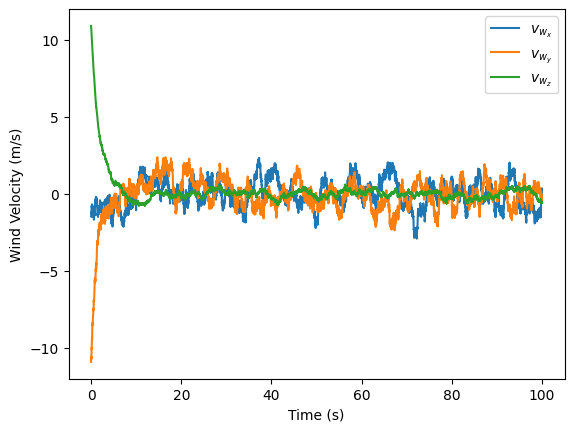

In [7]:
wind_vel_array = np.empty([10000,3])
wind_force_array = np.empty_like(wind_vel_array)

V_w = torch.zeros([3,])
V_w[0] = random.random() * (15 + 15) - 15
V_w[1] = random.random() * (15 + 15) - 15
V_w[2] = random.random() * (15 + 15) - 15
dt = 0.01

w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
w_array1 = torch.diag(w_array1)

w_array2 = torch.tensor([1.65,1.5,1.9])
w_array2 = torch.inverse(torch.diag(w_array2))

for sample in range(wind_vel_array.shape[0]):

    F_w = torch.tensor([
                    0.01 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.01 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.2 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    wind_force_array[sample,:] = F_w.detach().numpy()
    
    wind_vel_array[sample,:] = V_w.detach().numpy()
    
    w_d = torch.normal(mean=0, std=0.2, size=[3,])

    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
time_plt = np.linspace(0, 0.01*wind_vel_array.shape[0], wind_vel_array.shape[0])
plt.plot(time_plt, wind_vel_array[:,0])
plt.plot(time_plt, wind_vel_array[:,1])
plt.plot(time_plt, wind_vel_array[:,2])
plt.xlabel('Time (s)'), plt.ylabel('Wind Velocity (m/s)')
plt.legend([r'$v_{w_{x}}$',r'$v_{w_{y}}$',r'$v_{w_{z}}$'])    

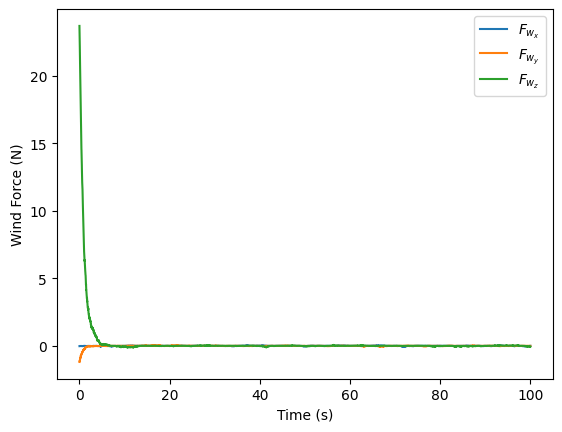

In [8]:
plt.plot(time_plt, wind_force_array[:,0])
plt.plot(time_plt, wind_force_array[:,1])
plt.plot(time_plt, wind_force_array[:,2])
plt.xlabel('Time (s)'), plt.ylabel('Wind Force (N)')
plt.legend([r'$F_{w_{x}}$',r'$F_{w_{y}}$',r'$F_{w_{z}}$'])    

In [81]:
# Number of points in the simulation.
N = 200

# Initializing simulation bound parameters
xy_offset = 20
min_Z, max_Z = 0, 50

# Defining rotor velocity constraints
min_rotor_bound = 0
max_rotor_bound = 1000
linvel_offset = torch.zeros([3,])
pitch_offset = torch.zeros([3,])

# Initializing quadrotor output array
batch_size = 1
quadout = torch.zeros([batch_size,N,32])

# Defining quadrotor mass and inertial properties
constants = constants_init()
I = constants['I']
Ixx = I[0,0]
Iyy = I[1,1]
Izz = I[2,2]
I_r = constants['I_r']
g = constants['g']
m = constants['m']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']
d_array = constants['d_array']

# Step through the simulation, updating the state.
for i in range(batch_size):

  # Initializing input trajectory from our controller.
  w1 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  w2 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  w3 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  w4 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  uu = torch.tensor([w1, w2, w3, w4])
  
  # Sampling initial quadrotor states
  state_vec, V_w = sample_quad_states(xy_offset, min_Z, max_Z, uu)

  for j in range(N):

    # Resampling next sampling rate
    dt = random.random() * (0.2 - 0.0002) + 0.0002

    # Saving current state as previous one
    prev_state_vec = state_vec

    while True:
      # Integrating dynamical states
      next_state_vec, V_w = eqn_mtn(prev_state_vec, uu, dt, V_w, linvel_offset, pitch_offset)
      X = next_state_vec[0]
      Y = next_state_vec[1]
      Z = next_state_vec[2]
      ROLL = next_state_vec[3]
      PITCH = next_state_vec[4]

      # Verifying that candidate next state is within defined state space
      state_verified = state_space_verify(Z, ROLL, PITCH)
      no_vel_offsets = quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, pitch_offset)
      #print(f'state_verified: {state_verified}, no_vel_offsets: {no_vel_offsets}')
      if state_verified and no_vel_offsets:

        # Capturing previous/next positional states, current sampling rate, and controls (rotor speeds)
        # of quadrotor
        xdot_prev = prev_state_vec[6:9]
        omega_prev = prev_state_vec[12:15]
        omegadot = prev_state_vec[15:18]
        a = prev_state_vec[18:]

        #x_prev_noise, q_prev_noise = apply_gaussian_noise(x_prev, q_prev)
        #print(f"x_prev: {x_prev}, q_prev: {q_prev}")
        #print(f"(noise) x_prev: {x_prev_noise}, q_prev: {q_prev_noise}\n")

        xdot_next = next_state_vec[6:9]
        omega_next = next_state_vec[12:15]
        omegadot_next = next_state_vec[15:18]
        a_next = next_state_vec[18:]
          
        #  INPUTS
        quadout[i,j,:3] = xdot_prev
        quadout[i,j,3:6] = a
        quadout[i,j,6:9] = omega_prev
        quadout[i,j,9:12] = omegadot
        quadout[i,j,12:13] = dt
        quadout[i,j,13:17] = uu
        quadout[i,j,17:20] = V_w
        # OUTPUTS
        quadout[i,j,20:23] = xdot_next
        quadout[i,j,23:26] = a_next
        quadout[i,j,26:29] = omega_next
        quadout[i,j,29:] = omegadot_next

        # Zeroing offsets when conditions are upheld
        linvel_offset = torch.zeros([3,])
        pitch_offset = torch.zeros([3,])
        break

      # Applying appropriate velocities until system evolves within admissible state space
      linvel_offset = linvel_control(Z, min_Z, max_Z)
      pitch_offset = roll_pitch_control(ROLL, PITCH)
      prev_state_vec = next_state_vec

     # print(f"X: {X}, Y: {Y}, Z: {Z}, ROLL: {ROLL}, PITCH: {PITCH}\n")
     # print(f"\n")

    # Saving admissible state vector as next concurrent state
    state_vec = next_state_vec

    # Take input from our controller.
    uu = update_controls(uu)

In [10]:
quadout[0,:,:]

tensor([[ 1.2310e+00,  4.6246e+00, -6.3537e-01,  ..., -1.6375e+00,
          1.8970e+00, -1.4388e+00],
        [ 8.4919e-01,  4.1988e+00, -5.5394e+00,  ...,  1.5920e-01,
         -3.1123e-01, -1.1248e+00],
        [ 7.4760e-01,  4.1431e+00, -6.4505e+00,  ...,  3.5119e-01,
         -1.4621e-01, -1.1840e+00],
        ...,
        [-1.3779e-01, -4.2852e-01, -6.8755e+00,  ...,  3.5511e-02,
          2.4318e-02, -2.1819e-01],
        [-1.4449e-01, -4.6550e-01, -7.9362e+00,  ...,  3.0540e-02,
         -1.8492e-02, -1.5046e-01],
        [-4.5143e-03, -5.1030e-02,  8.9184e+00,  ..., -1.0165e-01,
         -1.9064e-01, -1.2483e-01]])

In [135]:
quadout = traj_dataset.clone()
plt_idx = random.randint(0, quadout.shape[0]-1)
Xdot = quadout[plt_idx,:,0].detach().numpy()
Ydot = quadout[plt_idx,:,1].detach().numpy()
Zdot = quadout[plt_idx,:,2].detach().numpy()
Ax = quadout[plt_idx,:,3].detach().numpy()
Ay = quadout[plt_idx,:,4].detach().numpy()
Az = quadout[plt_idx,:,5].detach().numpy()
ωx = quadout[plt_idx,:,6].detach().numpy()
ωy = quadout[plt_idx,:,7].detach().numpy()
ωz = quadout[plt_idx,:,8].detach().numpy()
ωxdot = quadout[plt_idx,:,9].detach().numpy()
ωydot = quadout[plt_idx,:,10].detach().numpy()
ωzdot = quadout[plt_idx,:,11].detach().numpy()

tspan = np.zeros([quadout.shape[1],], dtype=np.float32)
curr_t = 0
for t in range(N):
    tspan[t] = curr_t
    curr_t += quadout[plt_idx,t,12]

In [18]:
quadout[0,:,12]

tensor([0.1104, 0.0973, 0.1828, 0.0449, 0.0761, 0.0951, 0.0282, 0.0201, 0.0564,
        0.1777, 0.0327, 0.0083, 0.0089, 0.1260, 0.0690, 0.1722, 0.1655, 0.0015,
        0.0143, 0.0620, 0.1846, 0.1914, 0.0814, 0.1235, 0.0348, 0.0902, 0.0108,
        0.0613, 0.1635, 0.1526, 0.1474, 0.1989, 0.0101, 0.0502, 0.0224, 0.0094,
        0.0328, 0.1446, 0.0605, 0.1602, 0.1470, 0.1334, 0.1393, 0.0891, 0.0378,
        0.0737, 0.0012, 0.1913, 0.0448, 0.1693, 0.1207, 0.0926, 0.0752, 0.0091,
        0.1141, 0.0073, 0.0057, 0.1179, 0.0753, 0.0371, 0.0417, 0.1408, 0.1414,
        0.1627, 0.1439, 0.1156, 0.0374, 0.1523, 0.0495, 0.0044, 0.1049, 0.0518,
        0.0549, 0.1841, 0.0426, 0.1051, 0.1193, 0.0330, 0.0107, 0.1291, 0.1808,
        0.0377, 0.1097, 0.0687, 0.1593, 0.1373, 0.1110, 0.0113, 0.0138, 0.0704,
        0.1154, 0.1785, 0.0323, 0.0667, 0.1328, 0.1458, 0.0601, 0.1120, 0.1185,
        0.1441, 0.0359, 0.0197, 0.0629, 0.1563, 0.0789, 0.1125, 0.0888, 0.1743,
        0.0771, 0.0917, 0.1945, 0.0799, 

In [21]:
tspan

array([ 0.        ,  0.11042611,  0.20770729,  0.39053884,  0.4354795 ,
        0.5116084 ,  0.60673004,  0.6349279 ,  0.65500134,  0.71140397,
        0.8891233 ,  0.9218584 ,  0.9301692 ,  0.9391105 ,  1.0650959 ,
        1.1341035 ,  1.3062707 ,  1.4717534 ,  1.4732593 ,  1.4875573 ,
        1.5495548 ,  1.7341437 ,  1.9255338 ,  2.0069141 ,  2.1304545 ,
        2.1652327 ,  2.2554233 ,  2.2661772 ,  2.327479  ,  2.4910128 ,
        2.6436434 ,  2.7910872 ,  2.9899619 ,  3.00004   ,  3.0502021 ,
        3.072601  ,  3.0819976 ,  3.1148071 ,  3.2593584 ,  3.3198857 ,
        3.480079  ,  3.627078  ,  3.7604342 ,  3.8996978 ,  3.9887645 ,
        4.026598  ,  4.100281  ,  4.1014605 ,  4.292803  ,  4.337583  ,
        4.50692   ,  4.627619  ,  4.720219  ,  4.7954397 ,  4.80453   ,
        4.9186077 ,  4.925955  ,  4.9316597 ,  5.0495477 ,  5.124882  ,
        5.161946  ,  5.2036757 ,  5.3444376 ,  5.485797  ,  5.6484504 ,
        5.792324  ,  5.907923  ,  5.945324  ,  6.0975966 ,  6.14

Ground effect force for 20 kg quadrotor should be approximately 80 N at its highest (Scaling computed by 0.4 * weight of quadrotor (in N))

### PID Control Implementations

Attitude Tracking PID Implementation

In [ ]:
def eqn_mtn(state_vec, uu, linvel_offset=torch.tensor([0,0,0]), pitch_offset=torch.tensor([0,0,0])):
  # Parsing positional and velocity states
  x = state_vec[:3]
  theta = state_vec[3:6]
  xdot = state_vec[6:9]
  thetadot = state_vec[9:]

  omega = thetadot2omega(thetadot, theta)

  # Compute linear and angular accelerations.
  a = acceleration(uu, theta, xdot, m, g, kf, kd)
  omegadot = angular_acceleration(uu, omega, I, L, b, km)

  # Integrating quadrotor states
  omega = omega + dt * omegadot

  if torch.any(pitch_offset):
    thetadot = pitch_offset
  else:
    thetadot = omega2thetadot(omega, theta)

  if torch.any(linvel_offset):
    xdot = linvel_offset
  else:
    xdot = xdot + dt * a

  # Integrating quadrotor positional states
  theta = theta + dt * thetadot
  x = x + dt * xdot

  # Ensuring euler angles lie within appropriate bounds
  theta = theta_check(theta)

  # Updating state vector
  state_vec = torch.concat([x, theta, xdot, thetadot], dim=0)

  return state_vec



def pd_control(state_vec, Kp, Kd, I, b, L, m, g, k):

  def error2inputs(e):
    # Parsing components of error for each euler angle
    e_roll = e[0]
    e_pitch = e[1]
    e_yaw = e[2]

    # Parsing scalar values from each needed parameter
    roll = state_vec[3]
    pitch = state_vec[4]
    yaw = state_vec[5]
    Ixx = I[0,0]
    Iyy = I[1,1]
    Izz = I[2,2]

    # Computing needed rotor velocities from derived control law
    w1 = (m*g) / (4*k*cos(pitch)*cos(roll)) - (2*b*e_roll*Ixx + e_yaw*Izz*k*L) / (4*b*k*L)
    w2 = (m*g) / (4*k*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) - (e_pitch*Iyy) / (2*k*L)
    w3 = (m*g) / (4*k*cos(pitch)*cos(roll)) - (e_yaw*Izz*k*L - 2*b*e_roll*Ixx) / (4*b*k*L)
    w4 = (m*g) / (4*k*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) + (e_pitch*Iyy) / (2*k*L)

    # Returning rotor velocities
    return torch.tensor([w1, w2, w3, w4])

  # Parsing attitude angles/velocities of quadrotor
  theta = state_vec[3:6]
  thetadot = state_vec[9:]

  # Defining PD parameters
  Kp = 2
  Kd = 4/3

  # Computing total needed thrust
  T = (m*g) / (k*cos(theta[0]*cos(theta[1])))

  # Computing current error
  e = Kd * thetadot + Kp * theta

  inputs = error2inputs(e)

  return inputs


def pid_control(state_vec, err_sum, Kp, Ki, Kd,  I, b, L, m, g, km):

  def error2inputs(e):
    # Parsing components of error for each euler angle
    e_roll = e[0]
    e_pitch = e[1]
    e_yaw = e[2]

    # Parsing scalar values from each needed parameter
    roll = state_vec[3]
    pitch = state_vec[4]
    yaw = state_vec[5]
    Ixx = I[0,0]
    Iyy = I[1,1]
    Izz = I[2,2]

    # Computing needed rotor velocities from derived control law
    w1 = (m*g) / (4*km*cos(pitch)*cos(roll)) - (2*b*e_roll*Ixx + e_yaw*Izz*km*L) / (4*b*km*L)
    w2 = (m*g) / (4*km*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) - (e_pitch*Iyy) / (2*km*L)
    w3 = (m*g) / (4*km*cos(pitch)*cos(roll)) - (e_yaw*Izz*km*L - 2*b*e_roll*Ixx) / (4*b*km*L)
    w4 = (m*g) / (4*km*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) + (e_pitch*Iyy) / (2*km*L)

    # Returning rotor velocities
    return torch.tensor([w1, w2, w3, w4])

  # Parsing attitude angles/velocities of quadrotor
  theta = state_vec[3:6]
  thetadot = state_vec[9:]

  # Computing total needed thrust
  T = (m*g) / (km*cos(theta[0]*cos(theta[1])))

  # Computing current error
  e = Kd * thetadot + Kp * theta + Ki * err_sum

  # Storing current error (protects against windup)
  if torch.max(theta) > 0.1:
    err_sum = 0
  else:
    err_sum += theta

  #print(err_sum)

  # Computing needed control input from error
  inputs = error2inputs(e)

  return inputs, err_sum

In [ ]:
# Defining quadrotor inertial properties
m = 1.3                # Mass of quadrotor (kg)
g = 9.806              # Gravitational force (m/s^2)
L = 0.21               # Length of quadrotor arm (rotor-to-center) (m)
r_prop = 0.254         # Radius of quadrotor propellor
A = 5.063e-2           # Cross-sectional area of propellor
I = inertia_tensor()   # Inertia tensor of quadrotor

# Defining quadrotor aerodynamic properties

kf = 1.08e-03       # Aerodynamic force coefficient (N*s^2)
km = 1.08e-03       # Aerodynamic moment coefficient (N*m*s^2)
kd = 0.1            # Aerodynamic friction coefficient
C_d = 0.35          # Aerodynamic dimensionless drag coefficient
rho = 1.225         # Air density (kg/m^3)

# Simulation drag coefficient
b = 0.5 * r_prop**3 * rho * C_d  * A

# Initializing simulation bound parameters
xy_offset = 20
min_Z, max_Z = 0, 40

# Defining PID parameters
Kp = 3.5
Kd = 1.5
Ki = 1e-3

# Sampling initial quadrotor states
state_vec = sample_quad_states(xy_offset, min_Z, max_Z)

# Defining simulation loop
times = torch.linspace(0, 10, 1000)
dt = times[1] - times[0]
quad_attitude = torch.zeros([3, times.shape[0]])
err_sum = torch.zeros([3,])
for t in range(times.shape[0]):

  # Capturing relevant quadrotor output
  quad_attitude[0,t] = state_vec[3]
  quad_attitude[1,t] = state_vec[4]
  quad_attitude[2,t] = state_vec[5]

  # Take input from our controller.
  uu, err_sum = pid_control(state_vec, err_sum, Kp, Ki, Kd, I, b, L, m, g, km)
  # Evolve quadrotor states
  state_vec = eqn_mtn(state_vec, uu)

# Displaying steady-state errors
print(f"Steady-State Error:\n\nRoll: {abs(state_vec[3])}, Pitch: {abs(state_vec[4])}, Yaw: {abs(state_vec[5])}\n")

# Plotting sim results
quad_attitude = quad_attitude.detach().numpy()
plt.plot(times, quad_attitude[0,:], label='roll')
plt.plot(times, quad_attitude[1,:], label='pitch')
plt.plot(times, quad_attitude[2,:], label='yaw')
plt.plot(times, np.zeros_like(times), '--r', label='zero')
plt.xlabel("Time (s)"), plt.ylabel("Euler Angles (rad)")
plt.title("Results from PID Control")
plt.legend()
plt.show()

### General MLP

In [16]:
class MLP(nn.Module):

  def __init__(
      self,
      input_size,
      output_size,
      hidden_size=128,
      n_hidden_layers=1,
      activation=nn.ReLU(),
      is_bias=True,
      dropout=0,
      aggregate_step=False,
      num_latents=0):

    super(MLP, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.n_hidden_layers = n_hidden_layers

    self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()
    self.activation = activation

    self.to_hidden = nn.Linear(self.input_size, self.hidden_size, bias=is_bias)
    self.linears = nn.ModuleList(
        [
            nn.Linear(self.hidden_size, self.hidden_size, bias=is_bias)
            for _ in range(self.n_hidden_layers - 1)
        ]
    )

    self.out = nn.Linear(self.hidden_size, self.output_size, bias=is_bias)
    self.aggregate_step = aggregate_step
    if self.aggregate_step:
      self.num_latents = num_latents
      self.latent_hidden = int((hidden_size+num_latents)/2)
      self.penultimate_layer = nn.Linear(output_size, self.latent_hidden, bias=is_bias)
      self.mu_layer = nn.Linear(self.latent_hidden, num_latents)
      self.log_sigma_layer = nn.Linear(self.latent_hidden, num_latents)


  def forward(self, x):
    out = self.to_hidden(x)
    out = self.activation(out)
    x = self.dropout(out)

    for linear in self.linears:
      out = linear(x)
      out = self.activation(out)
      out = self.dropout(out)
      x = out

    out = self.out(out)

    # Add-in for latent encoder steps
    if self.aggregate_step:
      out = torch.mean(out, dim=1)
      out = self.penultimate_layer(out)
      mu = self.mu_layer(out)
      log_sigma = self.log_sigma_layer(out)

      return mu, log_sigma

    else:
      return out

### Cross-Attention Module

In [ ]:
class Attention(object):
  """The Attention module."""

  def __init__(self, output_sizes, normalize=True):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention.
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalize: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self.output_sizes = output_sizes
    self.normalize = normalize

  def dot_product_attention(self, q, k, v):
      """Computes dot product attention.

      Args:
        q: queries. tensor of  shape [B,m,d_k].
        k: keys. tensor of shape [B,n,d_k].
        v: values. tensor of shape [B,n,d_v].
        normalise: Boolean that determines whether weights sum to 1.

      Returns:
        tensor of shape [B,m,d_v].
      """
      d_k = q.shape[-1]
      scale = torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
      unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]

      if self.normalize:
        weights = torch.nn.functional.softmax(unnorm_weights)  # [B,m,n]
      else:
        weights = torch.nn.functional.sigmoid(unnorm_weights)

      rep = torch.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
      return rep

  def __call__(self, context_x, target_x, representation):
    """Apply attention to create aggregated representation of r.

    Args:
      context_x: tensor of shape [B,n1,d_x].
      target_x: tensor of shape [B,n2,d_x].
      representation: tensor of shape [B,n1,d].

    Returns:
      tensor of shape [B,n2,d]

    """

    # Pass through MLP
    key_mlp = MLP(
        input_size=1,
        output_size=128
    )
    k = key_mlp(context_x)

    query_mlp = MLP(
        input_size=1,
        output_size=128
    )
    q = query_mlp(target_x)

    rep = self.dot_product_attention(q, k, representation)

    return rep

### 1D-Convolutional NN

In [17]:
class Conv1D(nn.Module):

  def __init__(
      self,
      head_size=16,
      input_size=128,
      x_dim=1,
      stddev=1
  ):
    super(Conv1D, self).__init__()

    # Initializing kernel
    self.W = nn.init.normal_(torch.zeros([head_size, input_size, x_dim]), std=stddev)

  def forward(self, x):
    out = F.conv1d(x.transpose(2,1), self.W, bias=None)
    out.transpose_(2,1)
    return out


### Defining Deterministic Encoder

In [5]:
class DeterministicEncoder():

  def __init__(self, hidden_size):

    self.hidden_sizes = hidden_size

  def __call__(self, context_x, context_y, target_x):

    num_context_points = context_x.shape[1]
    encoder_input = torch.concat([context_x, context_y], dim=-1)

    batch_size = encoder_input.shape[0]
    encoder_size = encoder_input.shape[2]

    encoder_input = encoder_input.reshape([batch_size*num_context_points, -1])

    encoder_network = MLP(
        input_size=encoder_size,
        hidden_size=self.hidden_sizes,
        output_size=self.hidden_sizes,
        n_hidden_layers=2
    )

    hidden = encoder_network(encoder_input)
    hidden = hidden.reshape([batch_size, num_context_points, self.hidden_sizes])

    representation = F.scaled_dot_product_attention(target_x, context_x, hidden)

    return representation

### Defining Latent Encoder

In [5]:
class LatentEncoder():

  def __init__(self, hidden_sizes, num_latents):

    self.hidden_sizes = hidden_sizes
    self.num_latents = num_latents

  def __call__(self, x, y):
    # Concatenate x and y along the filter axes
    encoder_input = torch.concat([x, y], dim=-1)
    encoder_size = encoder_input.shape[-1]

    # Initializing latent encoder network
    encoder_network = MLP(
        input_size=encoder_size,
        hidden_size=self.hidden_sizes,
        output_size=self.hidden_sizes,
        n_hidden_layers=2,
        aggregate_step=True,
        num_latents=self.hidden_sizes
    )

    # Passing encoder input through MLP and deriving mean and log variance describing latent variable distribution
    mu, log_sigma = encoder_network(encoder_input)

    # Bounding the log variance to obtain true variance values
    sigma = 0.9 * F.sigmoid(log_sigma) + 0.1

    return Normal(loc=mu, scale=sigma)


### Defining Base Decoder

In [ ]:
class Decoder():

  def __init__(self, hidden_sizes):

    self.hidden_sizes = hidden_sizes

  def __call__(self, representation, target_x, num_total_points):

    input = torch.concat([representation, target_x], axis=-1)
    batch_size = input.shape[0]
    decoder_size = input.shape[2]
    decoder_input = torch.reshape(input, [batch_size*num_total_points, -1])

    decoder_network = MLP(
        input_size=decoder_size,
        output_size=2,
        hidden_size=self.hidden_sizes
    )

    hidden = decoder_network(decoder_input)
    hidden = hidden.reshape([batch_size, num_total_points, -1])

    mu, log_sigma = torch.tensor_split(hidden, 2, dim=-1)

    sigma = 0.9 * F.softplus(log_sigma, threshold=100) + 0.1

    dist = Independent(Normal(loc=mu, scale=sigma), 1)

    return dist, mu, sigma

### Defining (Att)LNP Base Model

In [ ]:
class LatentModel():

  def __init__(self, encoder_hidden_sizes, decoder_hidden_sizes, num_latents, use_deterministic_path=True):

    self.latent_encoder = LatentEncoder(encoder_hidden_sizes, num_latents)
    self.decoder = Decoder(decoder_hidden_sizes)
    self.use_deterministic_path = use_deterministic_path
    if self.use_deterministic_path:
      self.deterministic_encoder = DeterministicEncoder(encoder_hidden_sizes)

  def __call__(self, query, num_total_points, num_context_points, target_y=None):

    (context_x, context_y), target_x = query

    prior = self.latent_encoder(context_x, context_y)

    # For testing, when target_y unavailable, use contexts for latent encoder.
    if target_y is None:
      latent_rep = prior.sample()

    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    else:
      posterior = self.latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()

    latent_rep = torch.tile(torch.unsqueeze(latent_rep, dim=1), [1, num_total_points, 1])

    if self.use_deterministic_path:
      deterministic_rep = self.deterministic_encoder(context_x, context_y, target_x)
      representation = torch.concat([deterministic_rep, latent_rep], dim=-1)
    else:
      representation = latent_rep

    dist, mu, sigma = self.decoder(representation, target_x, num_total_points)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      kl = torch.sum(
          kl_divergence(posterior, prior),
          dim=-1,
          keepdim=True
      )
      kl = torch.tile(kl, [1, num_total_points])
    else:
      log_p = None
      kl = None

    return log_p, kl, mu, sigma


### Defining Custom Loss Function

In [18]:
class LossFunc(nn.Module):
  def __init__(self):
    super(LossFunc, self).__init__()

  def forward(self, log_p, kl):
    # Computing total loss
    loss = -torch.mean((log_p - kl))
    return loss

### Combining Encoder, Decoder, Cross-Attention, and Latent Models for Training and Evaluating Purposes.

In [19]:
class AttLNP(nn.Module):

  def __init__(
      self,
      encoder_size,
      x_dim=1,
      y_dim=1,
      num_heads=8,
      att_type='mha',
      rep_transform = 'mlp',
      use_deterministic_path=True,
      R_dim=128  # Size for encoded representation vector, R
      ):

    super(AttLNP, self).__init__()
    self.hidden_sizes = R_dim
    self.rep_transform = rep_transform
    self.att_type = att_type
    self.use_deterministic_path = use_deterministic_path
    if self.att_type == 'mha'.lower():
      self.num_heads = num_heads

    # 1D Convolution Layers (for Multihead Attention)
    if self.att_type == 'mha':
      self.key_conv1d = Conv1D()
      self.value_conv1d = Conv1D()
      self.query_conv1d = Conv1D()
      self.rep_conv1d = Conv1D(
          head_size=R_dim, input_size=int(R_dim/num_heads), stddev=R_dim**(-0.5)
      )

    # Encoder/Decoder MLPs
    self.latent_encoder_network = MLP(
        input_size=encoder_size,
        output_size=R_dim,
        n_hidden_layers=2,
        aggregate_step=True,
        num_latents=R_dim
    )

    if self.use_deterministic_path: decoder_input = 2*R_dim+x_dim
    else: decoder_input = R_dim+x_dim
    self.decoder_network = MLP(
        input_size=decoder_input, # Input size for 128-dim representation vector + target_x (1-dim) concatenated
        output_size=y_dim*2
    )

    if self.use_deterministic_path:
      self.deterministic_encoder_network = MLP(
          input_size=encoder_size,
          output_size=R_dim,
          n_hidden_layers=2
      )

      # Key/Query MLPs
      if self.rep_transform == 'mlp'.lower():
        self.key_mlp = MLP(
            input_size=x_dim,
            output_size=R_dim
            )
        self.query_mlp = MLP(
            input_size=x_dim,
            output_size=R_dim
            )

  def latent_encoder(self, x, y):
    # Passing encoder input through MLP and deriving mean and log variance describing latent variable distribution
    encoder_input = torch.concat([x, y], dim=-1)
    mu, log_sigma = self.latent_encoder_network(encoder_input)

    # Bounding the log variance to obtain true variance values
    sigma = 0.9 * F.sigmoid(log_sigma) + 0.1

    return Normal(loc=mu, scale=sigma)

  def deterministic_encoder(self, context_x, context_y, target_x):

    num_context_points = context_x.shape[1]
    encoder_input = torch.concat([context_x, context_y], dim=-1)

    batch_size = encoder_input.shape[0]
    encoder_size = encoder_input.shape[2]

    encoder_input = encoder_input.reshape([batch_size*num_context_points, -1])

    hidden = self.deterministic_encoder_network(encoder_input)
    v = hidden.reshape([batch_size, num_context_points, self.hidden_sizes])

    # Passing context and target inputs to form keys and query of attention model
    if self.rep_transform == 'mlp'.lower():
      k = self.key_mlp(context_x)
      q = self.query_mlp(target_x)
    elif self.rep_transform == 'identity'.lower():
      k, q = context_x, target_x

    # Calculating query-specific representation, R(*)
    if self.att_type == 'dpa'.lower(): # dot-product attention
      representation = F.scaled_dot_product_attention(q,k,v)
    elif self.att_type == 'mha'.lower(): # multi-headed attention
      representation = self.multihead_attention(q,k,v)
    elif self.att_type == 'ua'.lower(): # uniform attention
      representation = self.uniform_attention(q, v)

    return representation


  def decoder(self, representation, target_x):
    decoder_input = torch.concat([representation, target_x], axis=-1)
    num_total_points = target_x.shape[1]
    batch_size = decoder_input.shape[0]

    hidden = self.decoder_network(decoder_input)
    hidden = hidden.reshape([batch_size, num_total_points, -1])

    mu, log_sigma = torch.tensor_split(hidden, 2, dim=-1)

    sigma = 0.9 * F.softplus(log_sigma, threshold=100) + 0.1

    dist = Independent(Normal(loc=mu, scale=sigma), 1)

    return dist, mu, sigma


  def multihead_attention(self, q, k, v):
    """Computes multi-head attention.

    Args:
      q: queries. tensor of  shape [B,m,d_k].
      k: keys. tensor of shape [B,n,d_k].
      v: values. tensor of shape [B,n,d_v].
      num_heads: number of heads. Should divide d_v.

    Returns:
      tensor of shape [B,m,d_v].
    """
    batch_size = q.shape[0]
    query_size = q.shape[1]
    d_v = v.shape[-1]

    rep = torch.zeros([batch_size, query_size, d_v])
    for h in range(self.num_heads):
      # Shrinking dimension space of representations through 1D convolution
      k_conv = self.key_conv1d(k)
      q_conv = self.query_conv1d(q)
      v_conv = self.value_conv1d(v)

      # Gathering attention from reduced representations
      o = F.scaled_dot_product_attention(q_conv, k_conv, v_conv)
      rep += self.rep_conv1d(o)

    return rep

  def uniform_attention(self, q, v):
    # Equivalent to a LNP
    num_total_points = q.shape[1]
    rep = torch.mean(v, dim=1, keepdim=True)
    rep = torch.tile(rep, [1, num_total_points, 1])
    return rep

  def forward(
      self,
      query,
      target_y=torch.tensor([]),
      is_testing=False
  ):

    # Parsing data from dataset query
    (context_x, context_y), target_x = query
    num_total_points = target_x.shape[1]

    # Defining prior distribution over gaussian latent variable
    prior = self.latent_encoder(context_x, context_y)

    # For testing, when target_y unavailable, use contexts for latent encoder.
    if is_testing:
      latent_rep = prior.sample()

    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    else:
      posterior = self.latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()

    latent_rep = torch.tile(torch.unsqueeze(latent_rep, dim=1), [1, num_total_points, 1])

    if self.use_deterministic_path:
      deterministic_rep = self.deterministic_encoder(context_x, context_y, target_x)
      representation = torch.concat([deterministic_rep, latent_rep], dim=-1)
    else:
      representation = latent_rep

    dist, mu, sigma = self.decoder(representation, target_x)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y.shape[0] != 0:
      posterior = self.latent_encoder(target_x, target_y)
      log_p = dist.log_prob(target_y)
      kl = torch.sum(
          kl_divergence(posterior, prior),
          dim=-1,
          keepdim=True
          )
     # print(f'kl: {kl.shape}, kl-array: {kl_divergence(posterior, prior).shape}')
      kl = torch.tile(kl, [1, num_total_points])
     # print(f'log_p: {log_p.shape}, kl: {kl.shape}')
      
      return log_p, kl, mu, sigma

    else:

      return mu, sigma



In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

model = torch.load('vel+accel-high-disturbance-mm-noise-model-1370-epochs.pt')
count_parameters(model)

193304

In [20]:
def compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(target_y[:,-1,:] - pred_y[:,-1,:])
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  scaled_pos_diff = np.abs((target_y[:,-1,:3] - pred_y[:,-1,:3]) / pred_y[:,-1,:3])
  scaled_euler_diff = np.abs((np.cos(target_y[:,-1,3:]) - np.cos(pred_y[:,-1,3:])) / np.cos(pred_y[:,-1,3:])) \
                    + np.abs((np.sin(target_y[:,-1,3:]) - np.sin(pred_y[:,-1,3:])) / np.sin(pred_y[:,-1,3:]))
  
  scaled_AE_array = np.sum(scaled_pos_diff, axis=1) + np.sum(scaled_euler_diff, axis=1)

  return scaled_AE_array

def plot_all_functions(context_x, context_y, target_x, target_y, pred_y, var, num_rows=2, num_cols=3):

  # Detaching gradients of tensors for plotting purposes
  context_x = context_x.detach().numpy()
  context_y = context_y.detach().numpy()
  target_x = target_x.detach().numpy()
  target_y = target_y.detach().numpy()
  pred_y = pred_y.detach().numpy()
  var = var.detach().numpy()

  # Computing batch absolute error and logging error of first sample
  plt_idx = random.randint(0, pred_y.shape[0]-1)
  AE_array = compute_AE(target_y, pred_y)
  print(f"Average Absolute Prediction Error (AAE) of Plotted Sample: {AE_array[plt_idx]}")

  # TO DO
  batch_size = pred_y.shape[0]
  pred_plot_array = np.zeros([2,12])
  pred_plot_array[0,:] = target_y[plt_idx,0,:]
  pred_plot_array[1,:] = pred_y[plt_idx,1,:]

  # Defining plot figures for both velocity/acceleration predictions
  figure, axis = plt.subplots(num_rows, num_cols)
  figure2, axis2 = plt.subplots(num_rows, num_cols)

  # Obtaining simulation time vector 'tspan'
  t = 0
  tspan = np.zeros_like(target_x[0,:,0])
  for i in range(tspan.shape[0]):
    tspan[i] = t
    t += target_x[plt_idx,-1,0]

  # Plotting everything for the first sample in the test batch
  y_labels = [r'$\dot{X}$ (m/s)', r'$\dot{Y}$ (m/s)', r'$\dot{Z}$ (m/s)', 
              r'$\ddot{X}$ (m/$s^{2}$)', r'$\ddot{Y}$ (m/$s^{2}$)', r'$\ddot{Z}$ (m/$s^{2}$)',
              r'$\omega_x$ ($rad/s$)', r'$\omega_y$ ($rad/s$)', r'$\omega_z$ ($rad/s$)',
              r'$\dot{\omega}_x$ ($rad/s^{2}$)', r'$\dot{\omega}_y$ ($rad/s^{2}$)', r'$\dot{\omega}_z$ ($rad/s^{2}$)']

  i = 0
  for row in range(num_rows):
    for col in range(num_cols):
      # Determine the upper and lower uncertainty bounds for each model prediction
      pred_ub = pred_plot_array[-1, i] + var[plt_idx, -1, i]
      pred_lb = pred_plot_array[-1, i] - var[plt_idx, -1, i]
      var_range = np.linspace(pred_lb, pred_ub, 20)
      dt_range = np.linspace(tspan[-1], tspan[-1], 20)

      # Obtaining prediction performance for each positional state
      axis[row,col].plot(tspan, target_y[plt_idx,:,i], 'ko', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_plot_array[-1,i], 'b*', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_ub, 'b_', linewidth=1)
      axis[row,col].plot(tspan[-1], pred_lb, 'b_', linewidth=1)
      axis[row,col].plot(dt_range, var_range, 'b--', linewidth=0.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis[row,col].set_ylabel(y_labels[i], fontsize=12)
      """
      axis[row].fill_between(
          tspan,
          pred_plot_array[:, row] - var[0, :, row],
          pred_plot_array[:, row] + var[0, :, row],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)
      """
      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis[row,col].grid(False)
      i += 1

  figure.supxlabel(r"Time $(s)$")
  figure.tight_layout(pad=1.0)
  
  # Looping over velocity predictions
  for row in range(num_rows):
    for col in range(num_cols):
      # Determine the upper and lower uncertainty bounds for each model prediction
      pred_ub = pred_plot_array[-1, i] + var[plt_idx, -1, i]
      pred_lb = pred_plot_array[-1, i] - var[plt_idx, -1, i]
      var_range = np.linspace(pred_lb, pred_ub, 20)
      dt_range = np.linspace(tspan[-1], tspan[-1], 20)

      # Obtaining prediction performance for each positional state
      axis2[row,col].plot(tspan, target_y[plt_idx,:,i], 'ko', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_plot_array[-1,i], 'b*', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_ub, 'b_', linewidth=1)
      axis2[row,col].plot(tspan[-1], pred_lb, 'b_', linewidth=1)
      axis2[row,col].plot(dt_range, var_range, 'b--', linewidth=0.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis2[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis2[row,col].set_ylabel(y_labels[i], fontsize=12)

      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis2[row,col].grid(False)
      i += 1

  figure2.supxlabel(r"Time $(s)$")
  figure2.tight_layout(pad=1.0)
  plt.show()

### Training AttLNP

In [11]:
quadout.shape

torch.Size([1998666, 2, 21])

In [9]:
# Initializing data & training step parameters
NUM_EPOCHS = 1000
PLOT_AFTER = 10
BATCH_SIZE = 1000
TRAIN_TEST_SPLIT = 498666
TRAJ_LENGTH = 2
COLLECT_TRAINING_LOSS_AFTER = int(5e1)

In [10]:
def shuffle_data(traj_dataset, shuffle_test=False):
    idx_tnsr = db.index_data_stacker(traj_dataset)
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT, :])

        return train_dataset, test_dataset
    
    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    return train_dataset

In [11]:
db = Quadrotor_Dynamics_Generator(traj_length=TRAJ_LENGTH)

# Loading training and testing datasets
traj_dataset = quadout.clone() #torch.from_numpy(np.load('quad_traj_new_dataset_10e6_vel_data_high_disturbance.npy'))[:int(5e6),:,:]
#traj_dataset = db.convert2new(traj_dataset)
train_dataset, test_dataset = shuffle_data(traj_dataset, shuffle_test=True)

# Sampling initial training and testing batches from dynamical dataset
batch_dataset = train_dataset[:BATCH_SIZE,:,:]
input = batch_dataset[:,:,:8]
output = batch_dataset[:,:,8:]

# Defining context and target sets
context_x = input[:,0:1,:].clone()
context_y = output[:,0:1,:].clone()
target_x = input.clone()
target_y = output.clone()

In [12]:
traj_dataset.shape

torch.Size([1998666, 2, 21])

In [11]:
np.save('quad_traj_NP_dataset_4.5e6_vel_data_high_disturbance_mm_noise_unnorm_filtered.npy', traj_dataset.detach().numpy())

Epoch: 0, Batch Testing Loss: 10.654062271118164, Batch Testing Average AE: 701.1787109375 w/ Standard Deviation: 47.12553787231445
Average Absolute Prediction Error (AAE) of Plotted Sample: 632.347412109375


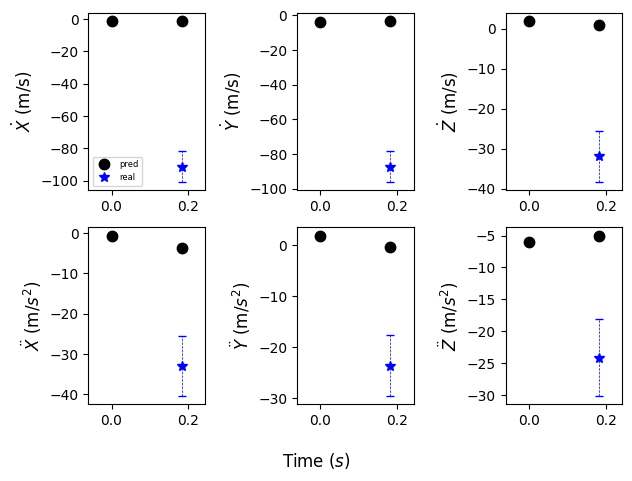

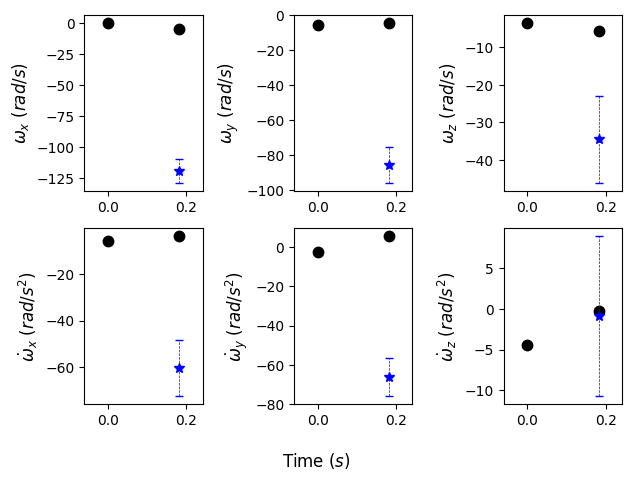

Current Batch Train Loss: 10.13776683807373

Current Batch Train Loss: -7.408165454864502

Current Batch Train Loss: -13.313040733337402

Current Batch Train Loss: -14.396946907043457

Current Batch Train Loss: -15.06385612487793

Current Batch Train Loss: -15.219344139099121

Current Batch Train Loss: -15.347976684570312

Current Batch Train Loss: -15.717991828918457

Current Batch Train Loss: -15.82216739654541

Current Batch Train Loss: -15.747000694274902

Current Batch Train Loss: -15.84935188293457

Current Batch Train Loss: -15.732725143432617

Current Batch Train Loss: -15.838593482971191

Current Batch Train Loss: -15.494382858276367

Current Batch Train Loss: -15.668665885925293

Current Batch Train Loss: -15.825508117675781

Current Batch Train Loss: -15.933420181274414

Current Batch Train Loss: -15.850783348083496

Current Batch Train Loss: -15.546152114868164

Current Batch Train Loss: -15.88119888305664

Current Batch Train Loss: -15.8575439453125

Current Batch Train Lo

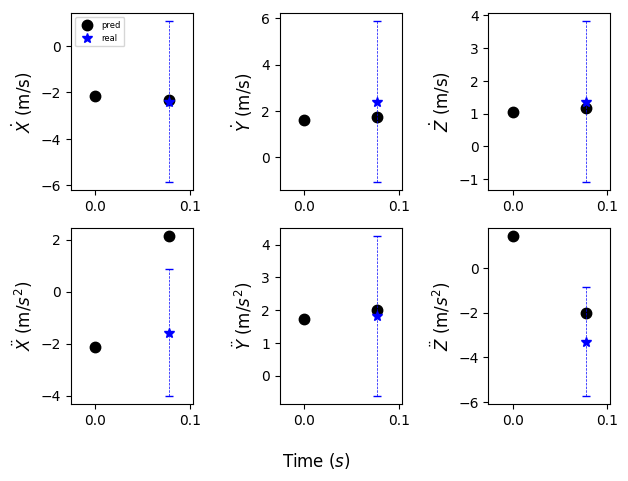

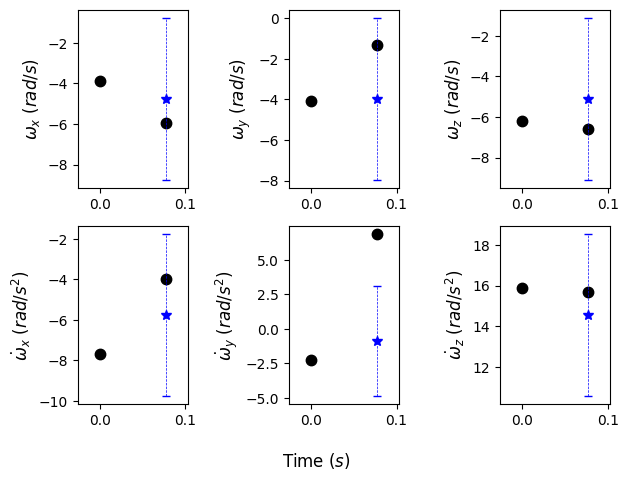

Current Batch Train Loss: -16.322546005249023

Current Batch Train Loss: -16.30073356628418

Current Batch Train Loss: -16.35715675354004

Current Batch Train Loss: -16.30693244934082

Current Batch Train Loss: -16.294767379760742

Current Batch Train Loss: -16.329547882080078

Current Batch Train Loss: -16.285707473754883

Current Batch Train Loss: -16.34162712097168

Current Batch Train Loss: -16.301389694213867

Current Batch Train Loss: -16.324739456176758

Current Batch Train Loss: -16.325366973876953

Current Batch Train Loss: -16.27882957458496

Current Batch Train Loss: -16.337692260742188

Current Batch Train Loss: -16.351865768432617

Current Batch Train Loss: -16.318866729736328

Current Batch Train Loss: -16.303543090820312

Current Batch Train Loss: -16.314123153686523

Current Batch Train Loss: -16.31360626220703

Current Batch Train Loss: -16.3217716217041

Current Batch Train Loss: -16.3543758392334

Current Batch Train Loss: -16.336824417114258

Current Batch Train Los

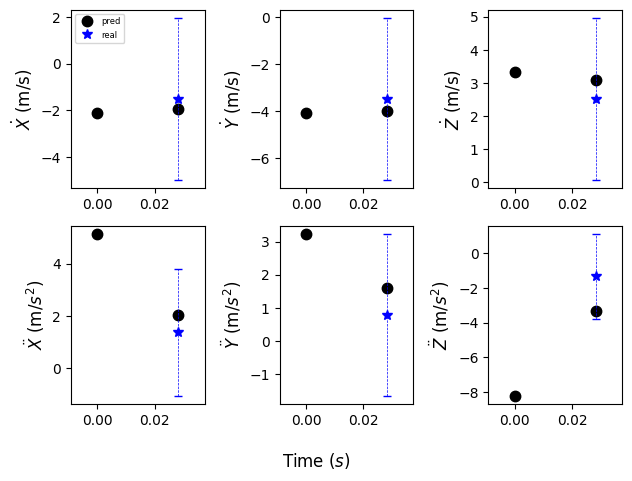

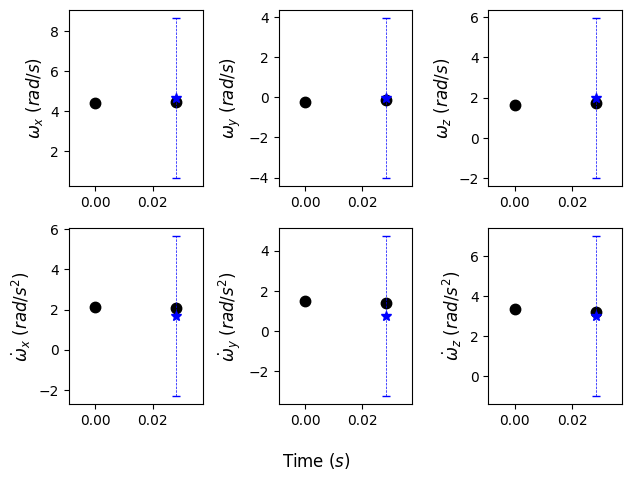

Current Batch Train Loss: -16.362070083618164

Current Batch Train Loss: -16.324357986450195

Current Batch Train Loss: -16.3060359954834

Current Batch Train Loss: -16.339996337890625

Current Batch Train Loss: -16.294715881347656

Current Batch Train Loss: -16.307334899902344

Current Batch Train Loss: -16.324764251708984

Current Batch Train Loss: -16.30875015258789

Current Batch Train Loss: -16.346195220947266

Current Batch Train Loss: -16.354570388793945

Current Batch Train Loss: -16.37846565246582

Current Batch Train Loss: -16.358158111572266

Current Batch Train Loss: -16.321603775024414

Current Batch Train Loss: -16.360414505004883

Current Batch Train Loss: -16.365215301513672

Current Batch Train Loss: -16.342416763305664

Current Batch Train Loss: -16.300052642822266

Current Batch Train Loss: -16.333887100219727

Current Batch Train Loss: -16.35960578918457

Current Batch Train Loss: -16.34674644470215

Current Batch Train Loss: -16.339323043823242

Current Batch Train

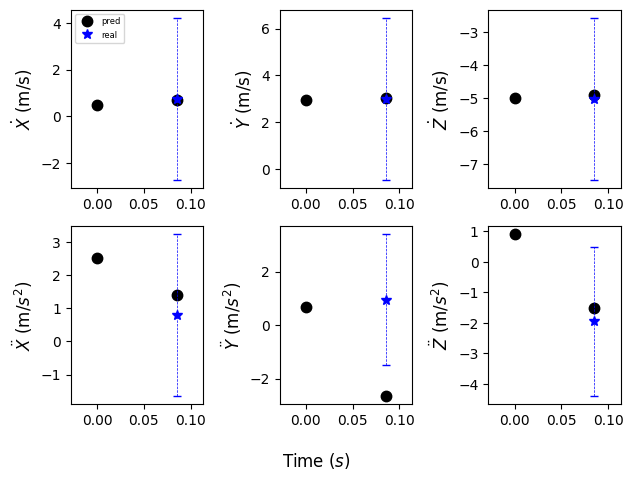

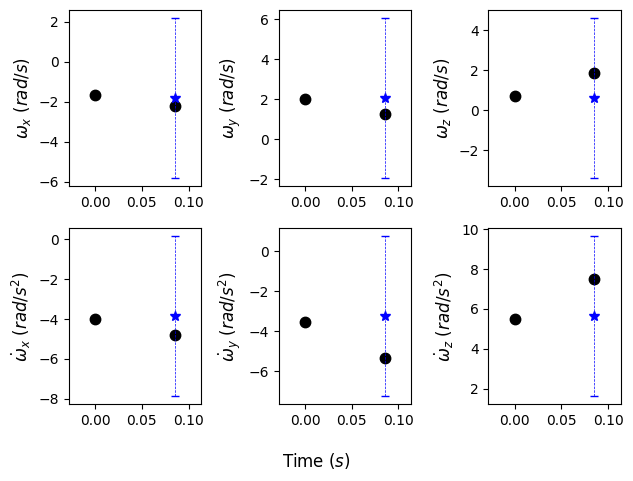

Current Batch Train Loss: -16.34796905517578

Current Batch Train Loss: -16.364259719848633

Current Batch Train Loss: -16.344802856445312

Current Batch Train Loss: -16.335494995117188

Current Batch Train Loss: -16.329519271850586

Current Batch Train Loss: -16.35042381286621

Current Batch Train Loss: -16.33672523498535

Current Batch Train Loss: -16.312345504760742

Current Batch Train Loss: -16.335847854614258

Current Batch Train Loss: -16.311193466186523

Current Batch Train Loss: -16.352359771728516

Current Batch Train Loss: -16.359827041625977

Current Batch Train Loss: -16.32146644592285

Current Batch Train Loss: -16.349477767944336

Current Batch Train Loss: -16.349563598632812

Current Batch Train Loss: -16.354515075683594

Current Batch Train Loss: -16.374040603637695

Current Batch Train Loss: -16.317825317382812

Current Batch Train Loss: -16.365537643432617

Current Batch Train Loss: -16.365795135498047

Current Batch Train Loss: -16.322965621948242

Current Batch Tra

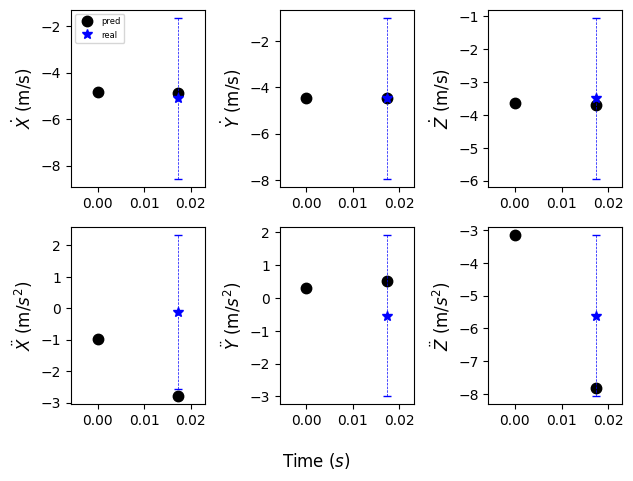

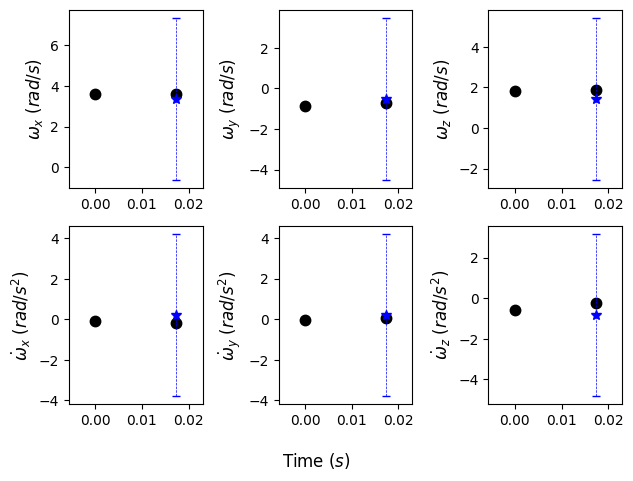

Current Batch Train Loss: -16.331945419311523

Current Batch Train Loss: -16.373388290405273

Current Batch Train Loss: -16.364927291870117

Current Batch Train Loss: -16.37093734741211

Current Batch Train Loss: -16.349674224853516

Current Batch Train Loss: -16.36629867553711

Current Batch Train Loss: -16.340682983398438

Current Batch Train Loss: -16.322650909423828

Current Batch Train Loss: -16.356931686401367

Current Batch Train Loss: -16.341800689697266

Current Batch Train Loss: -16.353328704833984

Current Batch Train Loss: -16.364389419555664

Current Batch Train Loss: -16.361751556396484

Current Batch Train Loss: -16.363916397094727

Current Batch Train Loss: -16.35281753540039

Current Batch Train Loss: -16.312576293945312

Current Batch Train Loss: -16.38805389404297

Current Batch Train Loss: -16.36827278137207

Current Batch Train Loss: -16.368459701538086

Current Batch Train Loss: -16.339387893676758

Current Batch Train Loss: -16.363605499267578

Current Batch Trai

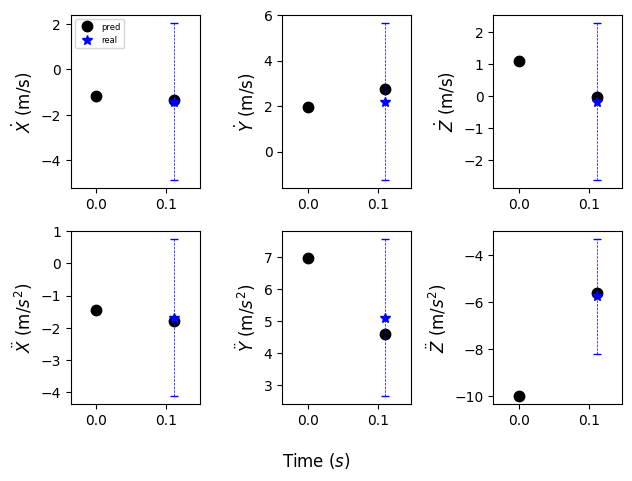

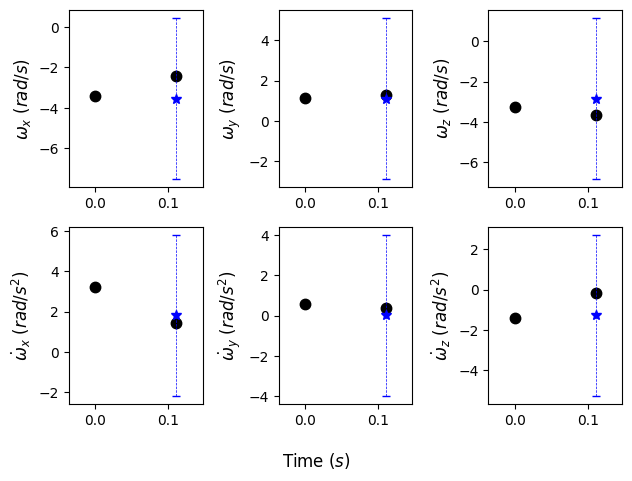

Current Batch Train Loss: -16.388214111328125

Current Batch Train Loss: -16.39093780517578

Current Batch Train Loss: -16.384183883666992

Current Batch Train Loss: -16.36301612854004

Current Batch Train Loss: -16.382780075073242

Current Batch Train Loss: -16.350242614746094

Current Batch Train Loss: -16.389095306396484

Current Batch Train Loss: -16.340723037719727

Current Batch Train Loss: -16.34477424621582

Current Batch Train Loss: -16.355064392089844

Current Batch Train Loss: -16.373300552368164

Current Batch Train Loss: -16.38702392578125

Current Batch Train Loss: -16.358585357666016

Current Batch Train Loss: -16.380308151245117

Current Batch Train Loss: -16.39223861694336

Current Batch Train Loss: -16.375974655151367

Current Batch Train Loss: -16.32892608642578

Current Batch Train Loss: -16.395709991455078

Current Batch Train Loss: -16.351795196533203

Current Batch Train Loss: -16.395036697387695

Current Batch Train Loss: -16.337133407592773

Current Batch Train

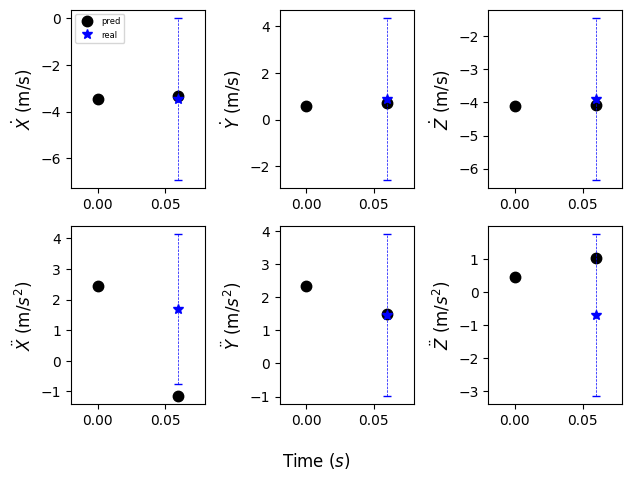

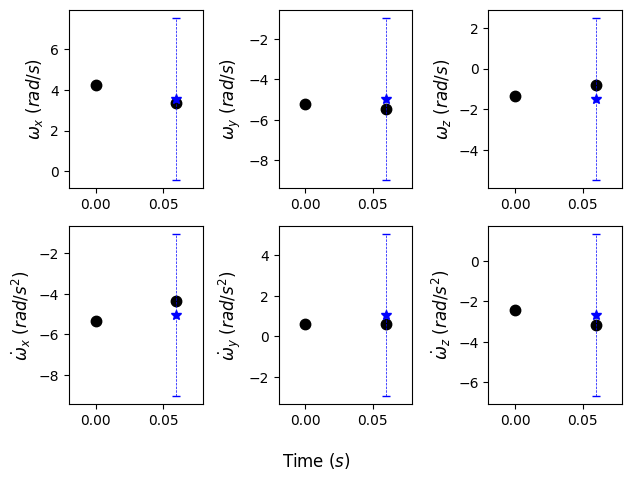

Current Batch Train Loss: -16.38715362548828

Current Batch Train Loss: -16.38852310180664

Current Batch Train Loss: -16.38611602783203

Current Batch Train Loss: -16.3753719329834

Current Batch Train Loss: -16.354162216186523

Current Batch Train Loss: -16.35508155822754

Current Batch Train Loss: -16.36669158935547

Current Batch Train Loss: -16.35317611694336

Current Batch Train Loss: -16.365604400634766

Current Batch Train Loss: -16.382354736328125

Current Batch Train Loss: -16.387269973754883

Current Batch Train Loss: -16.338411331176758

Current Batch Train Loss: -16.382373809814453

Current Batch Train Loss: -16.382556915283203

Current Batch Train Loss: -16.354822158813477

Current Batch Train Loss: -16.372295379638672

Current Batch Train Loss: -16.339765548706055

Current Batch Train Loss: -16.364728927612305

Current Batch Train Loss: -16.375728607177734

Current Batch Train Loss: -16.3345947265625

Current Batch Train Loss: -16.394569396972656

Current Batch Train Los

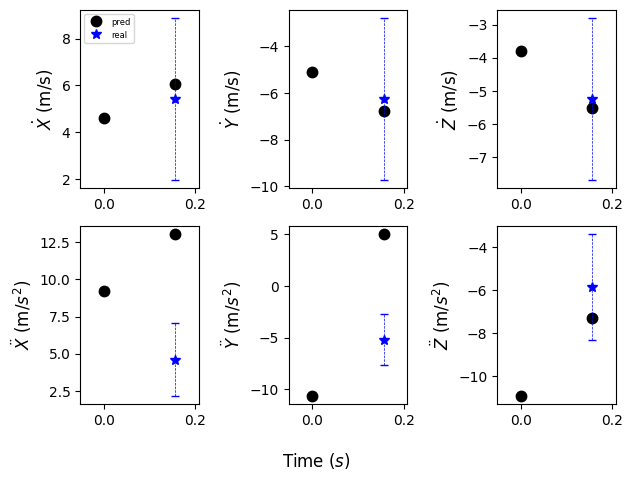

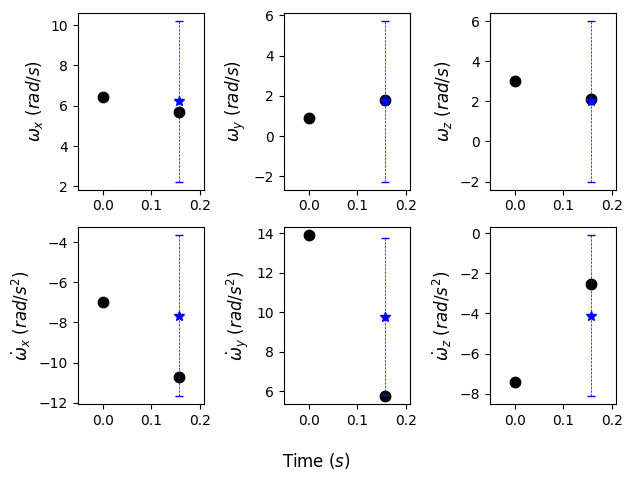

Current Batch Train Loss: -16.352388381958008

Current Batch Train Loss: -16.360605239868164

Current Batch Train Loss: -16.37002944946289

Current Batch Train Loss: -16.387468338012695

Current Batch Train Loss: -16.362394332885742

Current Batch Train Loss: -16.35296630859375

Current Batch Train Loss: -16.355247497558594

Current Batch Train Loss: -16.341136932373047

Current Batch Train Loss: -16.395755767822266

Current Batch Train Loss: -16.365781784057617

Current Batch Train Loss: -16.361080169677734

Current Batch Train Loss: -16.379722595214844

Current Batch Train Loss: -16.377151489257812

Current Batch Train Loss: -16.35453987121582

Current Batch Train Loss: -16.352041244506836

Current Batch Train Loss: -16.317411422729492

Current Batch Train Loss: -16.345611572265625

Current Batch Train Loss: -16.349395751953125

Current Batch Train Loss: -16.365432739257812

Current Batch Train Loss: -16.371593475341797

Current Batch Train Loss: -16.367218017578125

Current Batch Tr

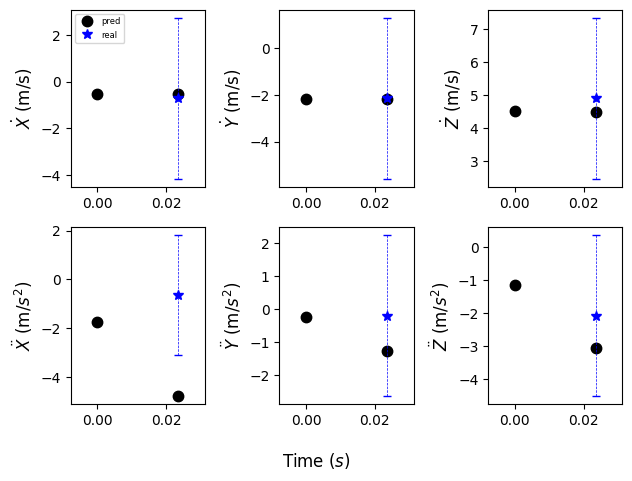

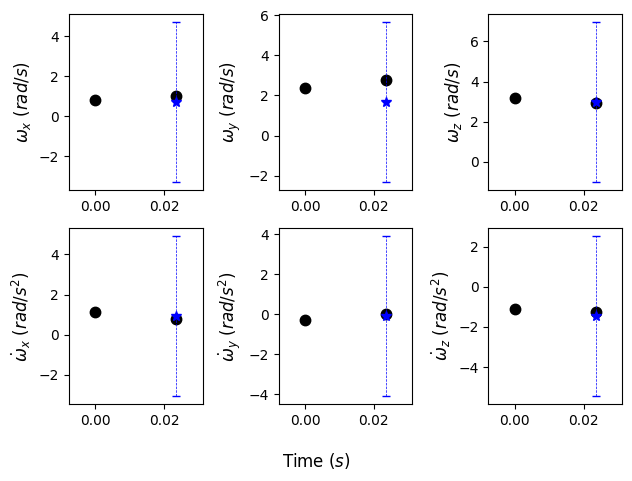

Current Batch Train Loss: -16.40890884399414

Current Batch Train Loss: -16.401941299438477

Current Batch Train Loss: -16.334070205688477

Current Batch Train Loss: -16.36910629272461

Current Batch Train Loss: -16.38370704650879

Current Batch Train Loss: -16.366130828857422

Current Batch Train Loss: -16.388877868652344

Current Batch Train Loss: -16.372711181640625

Current Batch Train Loss: -16.36859893798828

Current Batch Train Loss: -16.392786026000977

Current Batch Train Loss: -16.377946853637695

Current Batch Train Loss: -16.360857009887695

Current Batch Train Loss: -16.391143798828125

Current Batch Train Loss: -16.362415313720703

Current Batch Train Loss: -16.36868667602539

Current Batch Train Loss: -16.359878540039062

Current Batch Train Loss: -16.40966033935547

Current Batch Train Loss: -16.386638641357422

Current Batch Train Loss: -16.388530731201172

Current Batch Train Loss: -16.36391258239746

Current Batch Train Loss: -16.353361129760742

Current Batch Train 

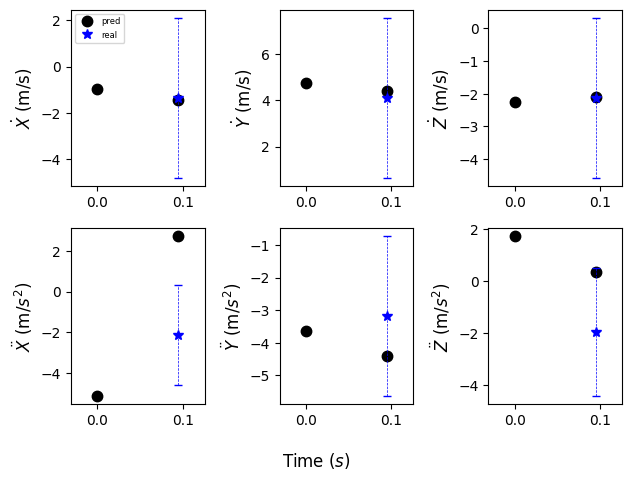

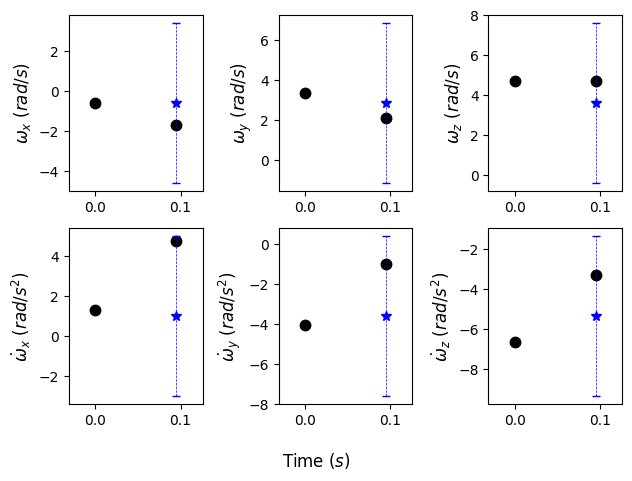

Current Batch Train Loss: -16.403583526611328

Current Batch Train Loss: -16.384159088134766

Current Batch Train Loss: -16.332807540893555

Current Batch Train Loss: -16.359664916992188

Current Batch Train Loss: -16.370628356933594

Current Batch Train Loss: -16.388479232788086

Current Batch Train Loss: -16.37710952758789

Current Batch Train Loss: -16.36151123046875

Current Batch Train Loss: -16.382619857788086

Current Batch Train Loss: -16.394033432006836

Current Batch Train Loss: -16.397356033325195

Current Batch Train Loss: -16.407808303833008

Current Batch Train Loss: -16.391399383544922

Current Batch Train Loss: -16.383331298828125

Current Batch Train Loss: -16.399784088134766

Current Batch Train Loss: -16.374975204467773

Current Batch Train Loss: -16.345197677612305

Current Batch Train Loss: -16.36771583557129

Current Batch Train Loss: -16.382755279541016

Current Batch Train Loss: -16.382253646850586

Current Batch Train Loss: -16.415828704833984

Current Batch Tr

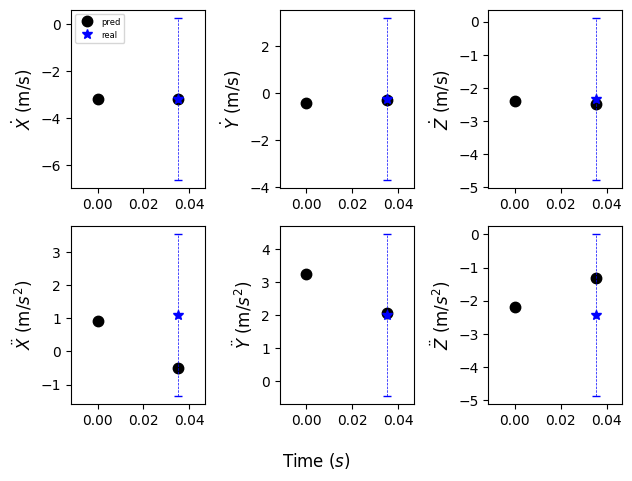

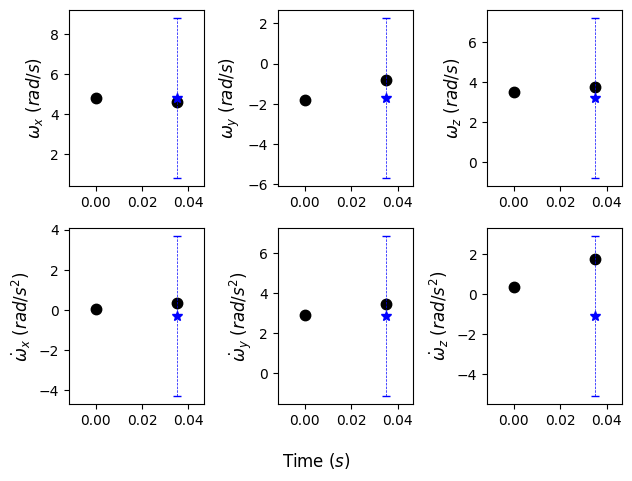

Current Batch Train Loss: -16.409421920776367

Current Batch Train Loss: -16.38883399963379

Current Batch Train Loss: -16.378650665283203

Current Batch Train Loss: -16.387222290039062

Current Batch Train Loss: -16.365236282348633

Current Batch Train Loss: -16.382030487060547

Current Batch Train Loss: -16.407516479492188

Current Batch Train Loss: -16.368959426879883

Current Batch Train Loss: -16.404020309448242

Current Batch Train Loss: -16.386320114135742

Current Batch Train Loss: -16.401391983032227

Current Batch Train Loss: -16.392362594604492

Current Batch Train Loss: -16.37575912475586

Current Batch Train Loss: -16.39219093322754

Current Batch Train Loss: -16.380327224731445

Current Batch Train Loss: -16.39841651916504

Current Batch Train Loss: -16.37921142578125

Current Batch Train Loss: -16.409584045410156

Current Batch Train Loss: -16.385587692260742

Current Batch Train Loss: -16.37380599975586

Current Batch Train Loss: -16.382003784179688

Current Batch Train

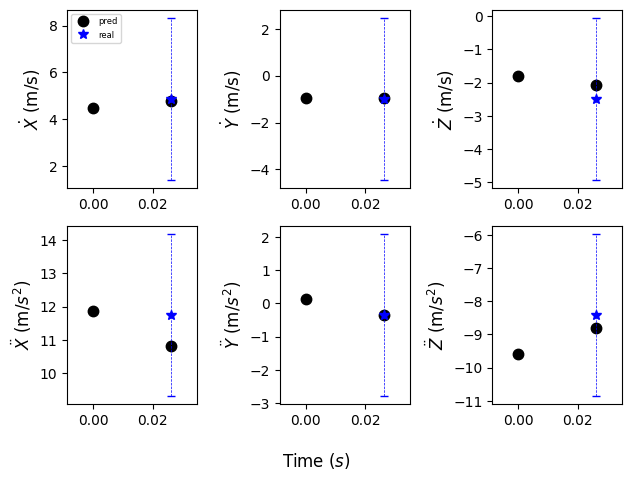

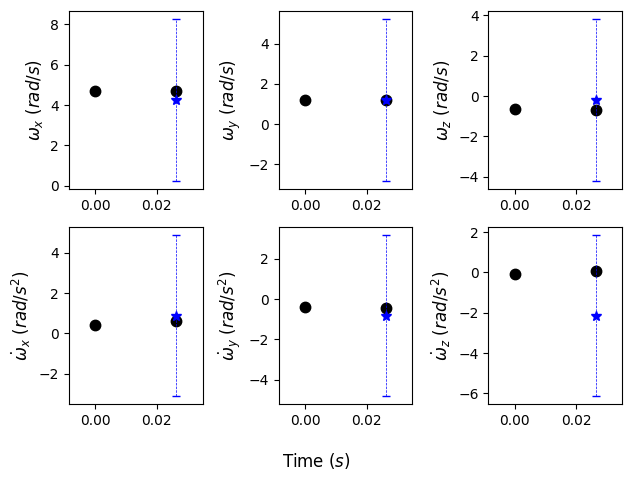

Current Batch Train Loss: -16.363021850585938

Current Batch Train Loss: -16.393653869628906

Current Batch Train Loss: -16.38961410522461

Current Batch Train Loss: -16.38753890991211

Current Batch Train Loss: -16.383743286132812

Current Batch Train Loss: -16.386219024658203

Current Batch Train Loss: -16.395061492919922

Current Batch Train Loss: -16.401758193969727

Current Batch Train Loss: -16.382938385009766

Current Batch Train Loss: -16.405282974243164

Current Batch Train Loss: -16.41295051574707

Current Batch Train Loss: -16.409116744995117

Current Batch Train Loss: -16.40217399597168

Current Batch Train Loss: -16.36988639831543

Current Batch Train Loss: -16.350858688354492

Current Batch Train Loss: -16.39381217956543

Current Batch Train Loss: -16.38710594177246

Current Batch Train Loss: -16.384536743164062

Current Batch Train Loss: -16.396516799926758

Current Batch Train Loss: -16.387727737426758

Current Batch Train Loss: -16.40201187133789

Current Batch Train L

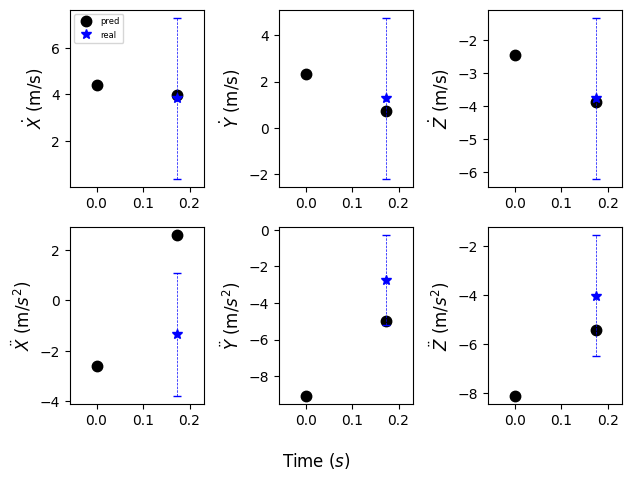

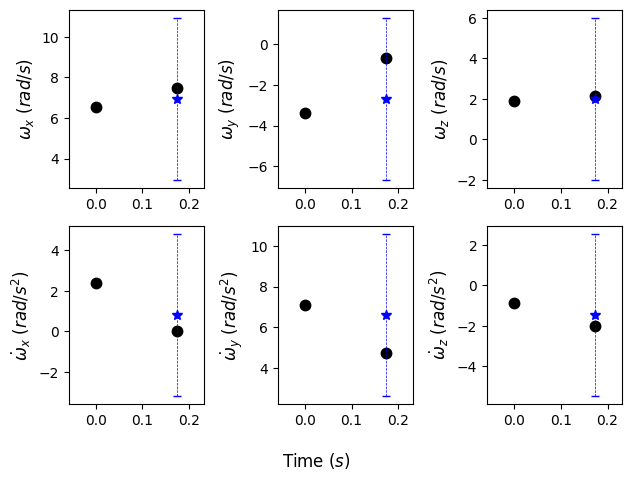

Current Batch Train Loss: -16.40747833251953

Current Batch Train Loss: -16.37915802001953

Current Batch Train Loss: -16.39324378967285

Current Batch Train Loss: -16.375259399414062

Current Batch Train Loss: -16.38239097595215

Current Batch Train Loss: -16.42742347717285

Current Batch Train Loss: -16.40420150756836

Current Batch Train Loss: -16.385568618774414

Current Batch Train Loss: -16.400047302246094

Current Batch Train Loss: -16.390470504760742

Current Batch Train Loss: -16.382007598876953

Current Batch Train Loss: -16.356733322143555

Current Batch Train Loss: -16.40491485595703

Current Batch Train Loss: -16.368793487548828

Current Batch Train Loss: -16.370830535888672

Current Batch Train Loss: -16.38286018371582

Current Batch Train Loss: -16.379629135131836

Current Batch Train Loss: -16.359872817993164

Current Batch Train Loss: -16.384319305419922

Current Batch Train Loss: -16.416786193847656

Current Batch Train Loss: -16.390348434448242

Current Batch Train L

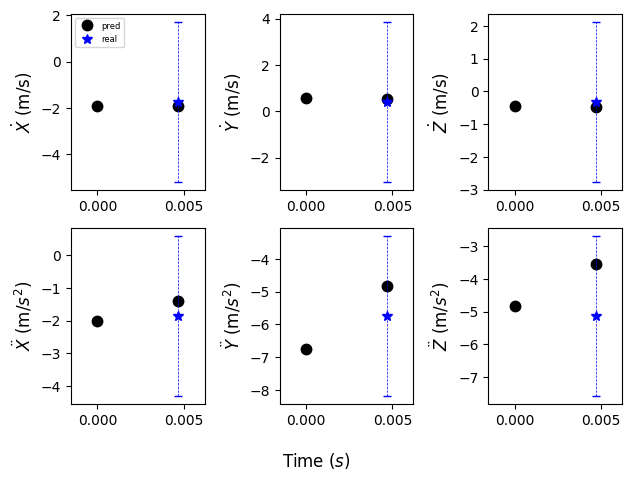

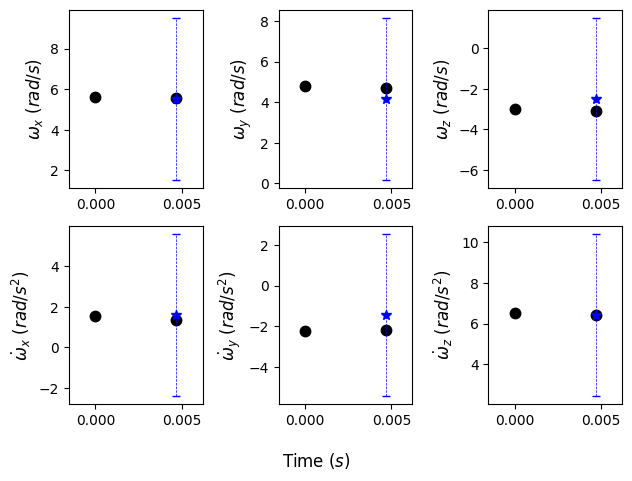

Current Batch Train Loss: -16.40711784362793

Current Batch Train Loss: -16.372690200805664

Current Batch Train Loss: -16.401081085205078

Current Batch Train Loss: -16.40102767944336

Current Batch Train Loss: -16.399337768554688

Current Batch Train Loss: -16.396923065185547

Current Batch Train Loss: -16.397859573364258

Current Batch Train Loss: -16.400577545166016

Current Batch Train Loss: -16.370405197143555

Current Batch Train Loss: -16.38492774963379

Current Batch Train Loss: -16.424657821655273

Current Batch Train Loss: -16.365358352661133

Current Batch Train Loss: -16.360322952270508

Current Batch Train Loss: -16.3734073638916

Current Batch Train Loss: -16.42816162109375

Current Batch Train Loss: -16.38201141357422

Current Batch Train Loss: -16.407190322875977

Current Batch Train Loss: -16.375986099243164

Current Batch Train Loss: -16.400243759155273

Current Batch Train Loss: -16.421215057373047

Current Batch Train Loss: -16.39073371887207

Current Batch Train L

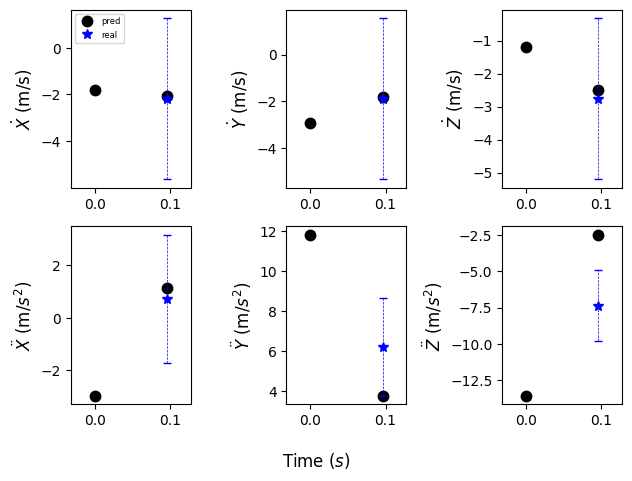

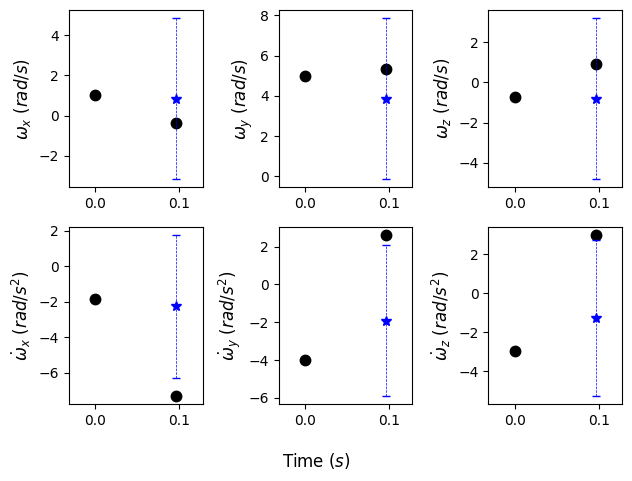

Current Batch Train Loss: -16.420669555664062

Current Batch Train Loss: -16.370147705078125

Current Batch Train Loss: -16.3482608795166

Current Batch Train Loss: -16.408884048461914

Current Batch Train Loss: -16.397668838500977

Current Batch Train Loss: -16.405344009399414

Current Batch Train Loss: -16.41289520263672

Current Batch Train Loss: -16.365020751953125

Current Batch Train Loss: -16.41172218322754

Current Batch Train Loss: -16.359752655029297

Current Batch Train Loss: -16.429967880249023

Current Batch Train Loss: -16.370285034179688

Current Batch Train Loss: -16.399606704711914

Current Batch Train Loss: -16.39910888671875

Current Batch Train Loss: -16.397319793701172

Current Batch Train Loss: -16.39128303527832

Current Batch Train Loss: -16.40182113647461

Current Batch Train Loss: -16.3737735748291

Current Batch Train Loss: -16.36503028869629

Current Batch Train Loss: -16.40961265563965

Current Batch Train Loss: -16.392553329467773

Current Batch Train Loss

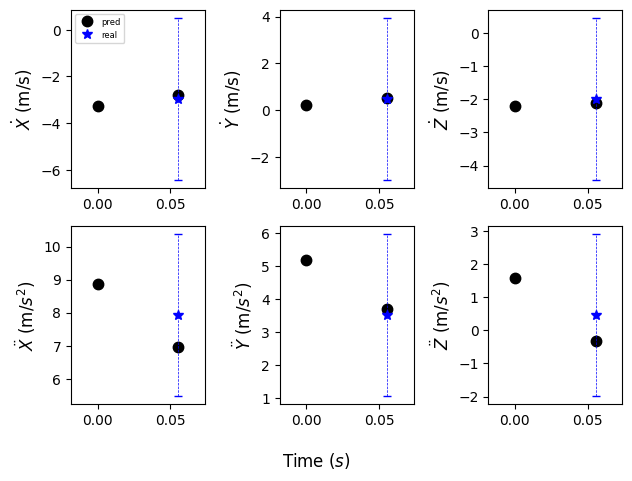

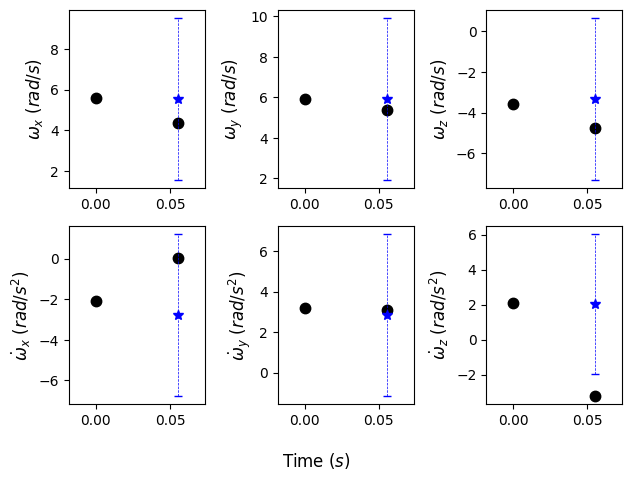

Current Batch Train Loss: -16.40988540649414

Current Batch Train Loss: -16.414583206176758

Current Batch Train Loss: -16.415315628051758

Current Batch Train Loss: -16.413593292236328

Current Batch Train Loss: -16.41992950439453

Current Batch Train Loss: -16.388700485229492

Current Batch Train Loss: -16.38335418701172

Current Batch Train Loss: -16.418354034423828

Current Batch Train Loss: -16.410463333129883

Current Batch Train Loss: -16.39259147644043

Current Batch Train Loss: -16.3594913482666

Current Batch Train Loss: -16.39552879333496

Current Batch Train Loss: -16.428936004638672

Current Batch Train Loss: -16.378345489501953

Current Batch Train Loss: -16.377107620239258

Current Batch Train Loss: -16.420406341552734

Current Batch Train Loss: -16.41105079650879

Current Batch Train Loss: -16.40866470336914

Current Batch Train Loss: -16.409887313842773

Current Batch Train Loss: -16.391361236572266

Current Batch Train Loss: -16.415695190429688

Current Batch Train Lo

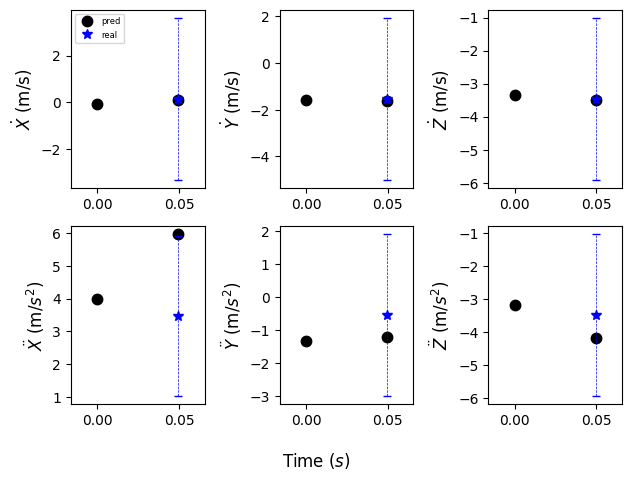

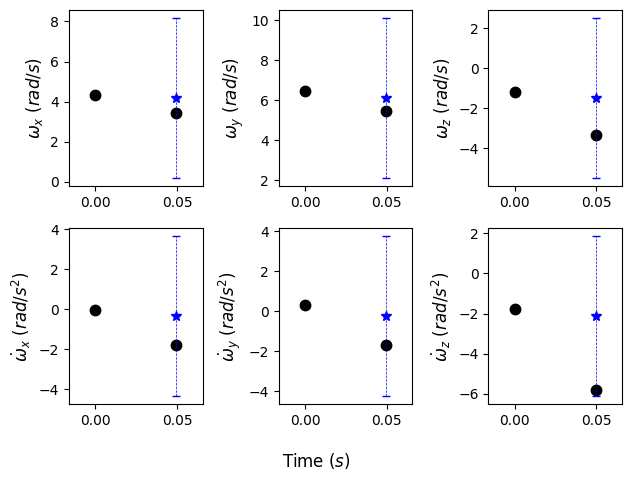

Current Batch Train Loss: -16.42586326599121

Current Batch Train Loss: -16.36600685119629

Current Batch Train Loss: -16.41466522216797

Current Batch Train Loss: -16.387359619140625

Current Batch Train Loss: -16.41015625

Current Batch Train Loss: -16.405261993408203

Current Batch Train Loss: -16.41878890991211

Current Batch Train Loss: -16.40924835205078

Current Batch Train Loss: -16.38028907775879

Current Batch Train Loss: -16.4247989654541

Current Batch Train Loss: -16.399446487426758

Current Batch Train Loss: -16.38026237487793

Current Batch Train Loss: -16.413808822631836

Current Batch Train Loss: -16.39689826965332

Current Batch Train Loss: -16.409189224243164

Current Batch Train Loss: -16.388784408569336

Current Batch Train Loss: -16.429800033569336

Current Batch Train Loss: -16.41409683227539

Current Batch Train Loss: -16.382055282592773

Current Batch Train Loss: -16.38451385498047

Current Batch Train Loss: -16.403358459472656

Current Batch Train Loss: -16.40

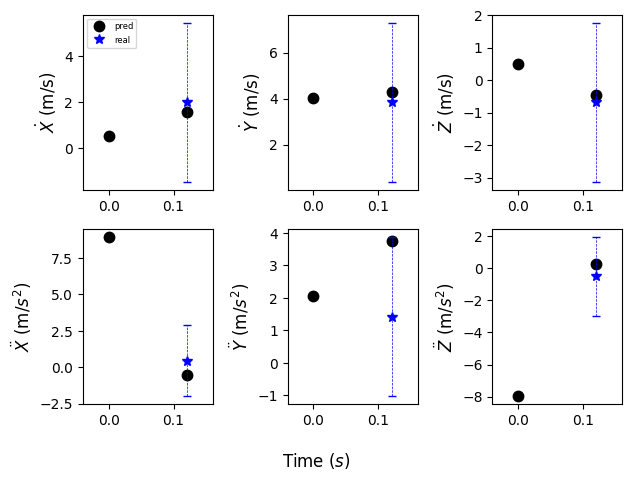

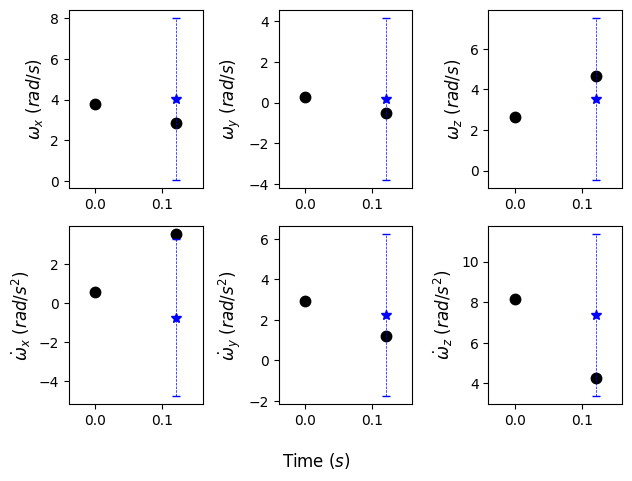

Current Batch Train Loss: -16.399316787719727

Current Batch Train Loss: -16.355941772460938

Current Batch Train Loss: -16.399030685424805

Current Batch Train Loss: -16.39630699157715

Current Batch Train Loss: -16.383167266845703

Current Batch Train Loss: -16.41120719909668

Current Batch Train Loss: -16.361072540283203

Current Batch Train Loss: -16.420394897460938

Current Batch Train Loss: -16.40809440612793

Current Batch Train Loss: -16.370885848999023

Current Batch Train Loss: -16.40376091003418

Current Batch Train Loss: -16.391822814941406

Current Batch Train Loss: -16.38931655883789

Current Batch Train Loss: -16.411949157714844

Current Batch Train Loss: -16.39954376220703

Current Batch Train Loss: -16.41209602355957

Current Batch Train Loss: -16.399887084960938

Current Batch Train Loss: -16.399860382080078

Current Batch Train Loss: -16.40521240234375

Current Batch Train Loss: -16.396595001220703

Current Batch Train Loss: -16.386951446533203

Current Batch Train L

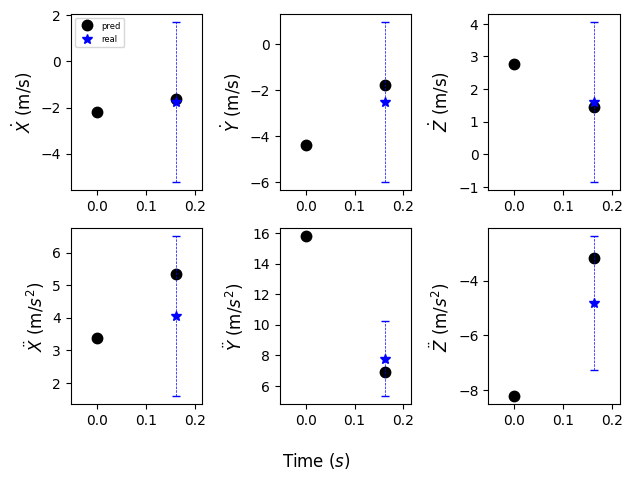

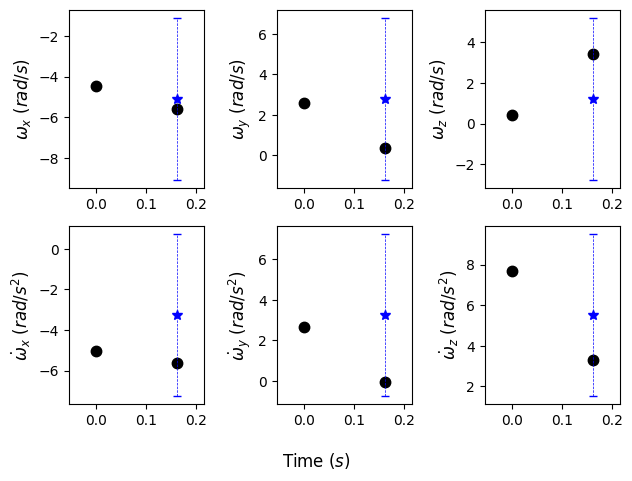

Current Batch Train Loss: -16.40951919555664

Current Batch Train Loss: -16.37937355041504

Current Batch Train Loss: -16.411277770996094

Current Batch Train Loss: -16.435007095336914

Current Batch Train Loss: -16.36632537841797

Current Batch Train Loss: -16.385698318481445

Current Batch Train Loss: -16.414859771728516

Current Batch Train Loss: -16.40546417236328

Current Batch Train Loss: -16.37245750427246

Current Batch Train Loss: -16.39148712158203

Current Batch Train Loss: -16.373931884765625

Current Batch Train Loss: -16.410659790039062

Current Batch Train Loss: -16.389238357543945

Current Batch Train Loss: -16.398326873779297

Current Batch Train Loss: -16.404394149780273

Current Batch Train Loss: -16.372211456298828

Current Batch Train Loss: -16.388582229614258

Current Batch Train Loss: -16.394330978393555

Current Batch Train Loss: -16.42576789855957

Current Batch Train Loss: -16.418926239013672

Current Batch Train Loss: -16.356868743896484

Current Batch Train 

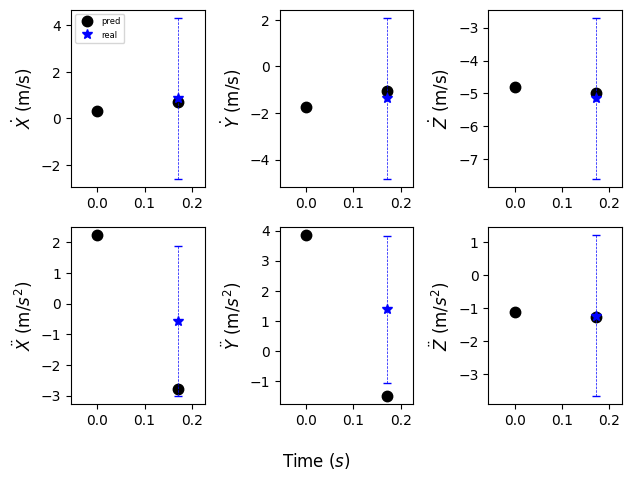

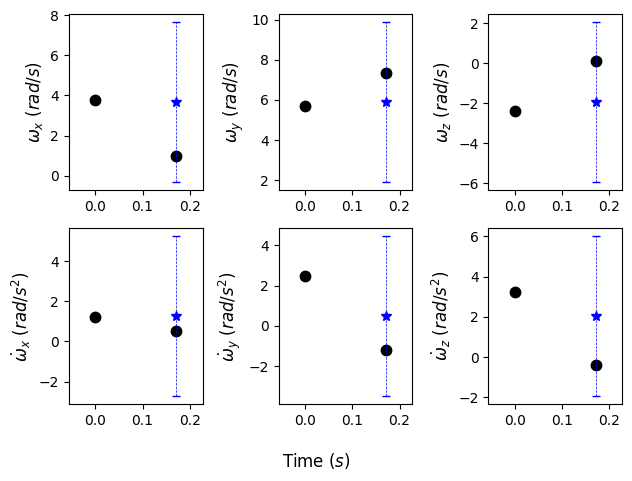

Current Batch Train Loss: -16.41049575805664

Current Batch Train Loss: -16.39340591430664

Current Batch Train Loss: -16.38468360900879

Current Batch Train Loss: -16.381887435913086

Current Batch Train Loss: -16.408039093017578

Current Batch Train Loss: -16.401762008666992

Current Batch Train Loss: -16.396522521972656

Current Batch Train Loss: -16.372074127197266

Current Batch Train Loss: -16.410785675048828

Current Batch Train Loss: -16.376873016357422

Current Batch Train Loss: -16.41585922241211

Current Batch Train Loss: -16.400026321411133

Current Batch Train Loss: -16.418792724609375

Current Batch Train Loss: -16.405797958374023

Current Batch Train Loss: -16.41958999633789

Current Batch Train Loss: -16.362104415893555

Current Batch Train Loss: -16.382450103759766

Current Batch Train Loss: -16.40979766845703

Current Batch Train Loss: -16.39383316040039

Current Batch Train Loss: -16.39338493347168

Current Batch Train Loss: -16.42848014831543

Current Batch Train Lo

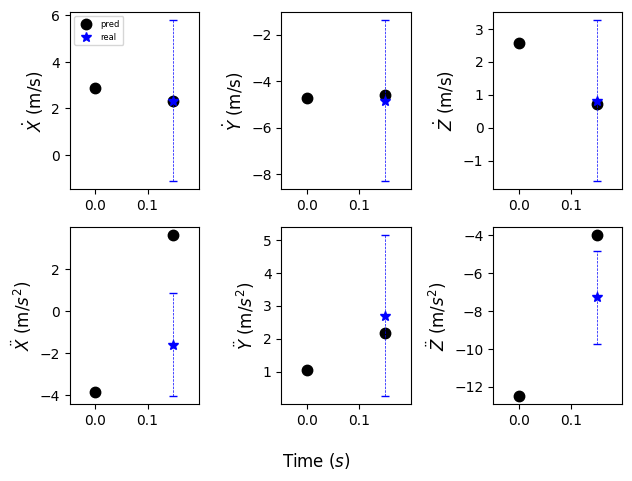

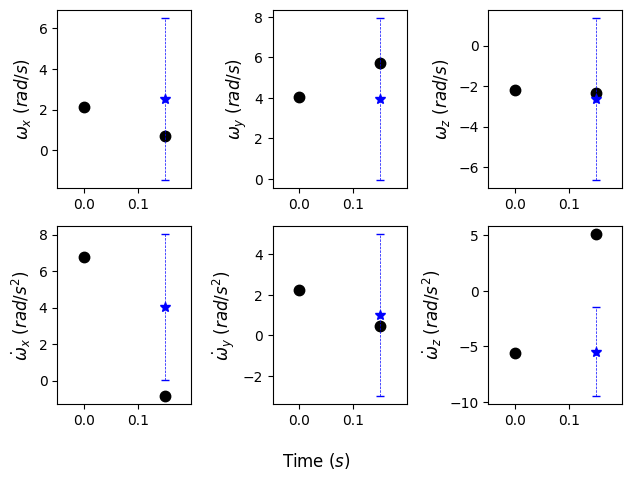

Current Batch Train Loss: -16.411949157714844

Current Batch Train Loss: -16.37087059020996

Current Batch Train Loss: -16.388551712036133

Current Batch Train Loss: -16.401792526245117

Current Batch Train Loss: -16.42481803894043

Current Batch Train Loss: -16.406024932861328

Current Batch Train Loss: -16.419179916381836

Current Batch Train Loss: -16.359010696411133

Current Batch Train Loss: -16.393701553344727

Current Batch Train Loss: -16.422035217285156

Current Batch Train Loss: -16.38054847717285

Current Batch Train Loss: -16.385169982910156

Current Batch Train Loss: -16.407201766967773

Current Batch Train Loss: -16.393083572387695

Current Batch Train Loss: -16.410541534423828

Current Batch Train Loss: -16.40659523010254

Current Batch Train Loss: -16.408462524414062

Current Batch Train Loss: -16.41002082824707

Current Batch Train Loss: -16.403453826904297

Current Batch Train Loss: -16.42275619506836

Current Batch Train Loss: -16.397869110107422

Current Batch Train

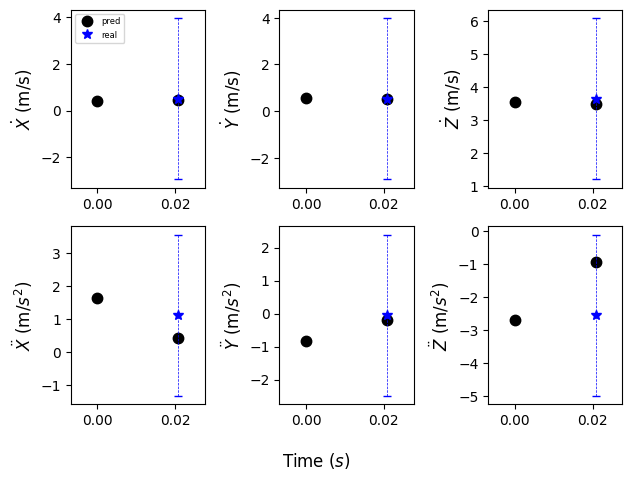

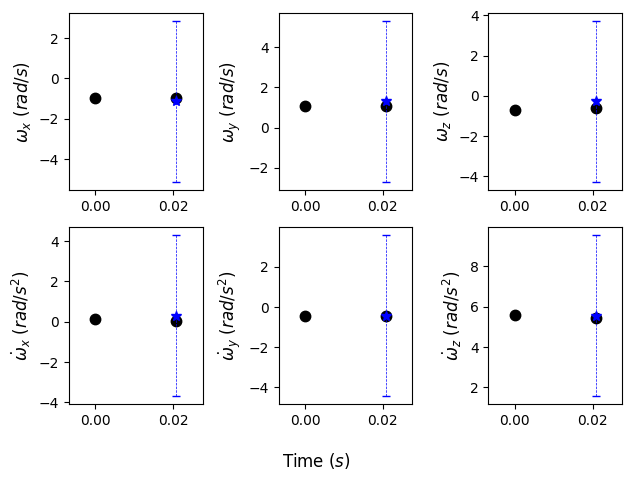

Current Batch Train Loss: -16.392230987548828

Current Batch Train Loss: -16.406015396118164

Current Batch Train Loss: -16.413869857788086

Current Batch Train Loss: -16.380361557006836

Current Batch Train Loss: -16.367334365844727

Current Batch Train Loss: -16.40278434753418

Current Batch Train Loss: -16.384830474853516

Current Batch Train Loss: -16.423486709594727

Current Batch Train Loss: -16.391307830810547

Current Batch Train Loss: -16.39099884033203

Current Batch Train Loss: -16.39910316467285

Current Batch Train Loss: -16.401464462280273

Current Batch Train Loss: -16.384206771850586

Current Batch Train Loss: -16.408706665039062

Current Batch Train Loss: -16.377090454101562

Current Batch Train Loss: -16.403017044067383

Current Batch Train Loss: -16.390518188476562

Current Batch Train Loss: -16.43022346496582

Current Batch Train Loss: -16.39052391052246

Current Batch Train Loss: -16.394527435302734

Current Batch Train Loss: -16.393484115600586

Current Batch Trai

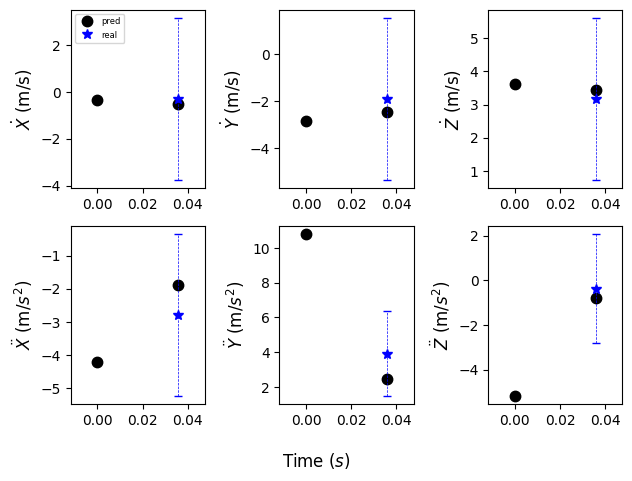

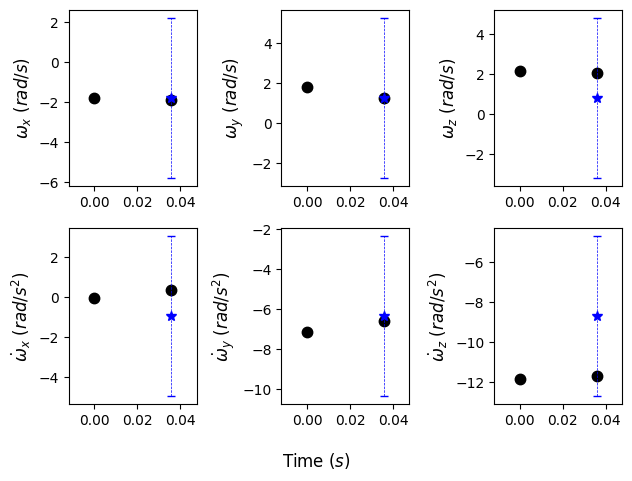

Current Batch Train Loss: -16.386194229125977

Current Batch Train Loss: -16.413341522216797

Current Batch Train Loss: -16.372961044311523

Current Batch Train Loss: -16.418222427368164

Current Batch Train Loss: -16.418039321899414

Current Batch Train Loss: -16.410274505615234

Current Batch Train Loss: -16.417606353759766

Current Batch Train Loss: -16.408931732177734

Current Batch Train Loss: -16.392366409301758

Current Batch Train Loss: -16.42731285095215

Current Batch Train Loss: -16.415699005126953

Current Batch Train Loss: -16.402809143066406

Current Batch Train Loss: -16.38905906677246

Current Batch Train Loss: -16.422313690185547

Current Batch Train Loss: -16.404834747314453

Current Batch Train Loss: -16.39858055114746

Current Batch Train Loss: -16.396028518676758

Current Batch Train Loss: -16.383087158203125

Current Batch Train Loss: -16.410003662109375

Current Batch Train Loss: -16.402395248413086

Current Batch Train Loss: -16.392292022705078

Current Batch Tr

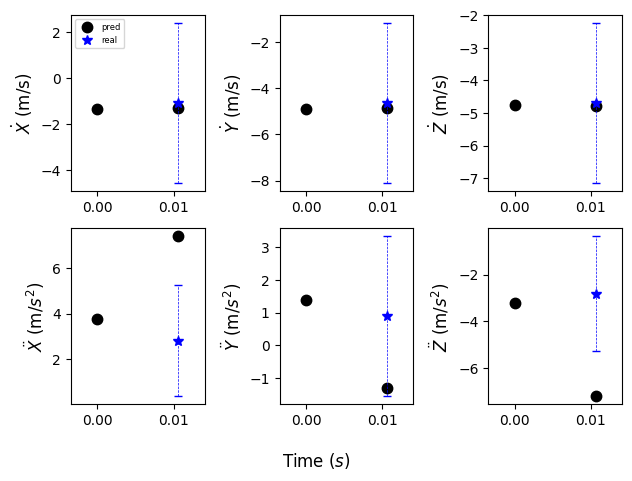

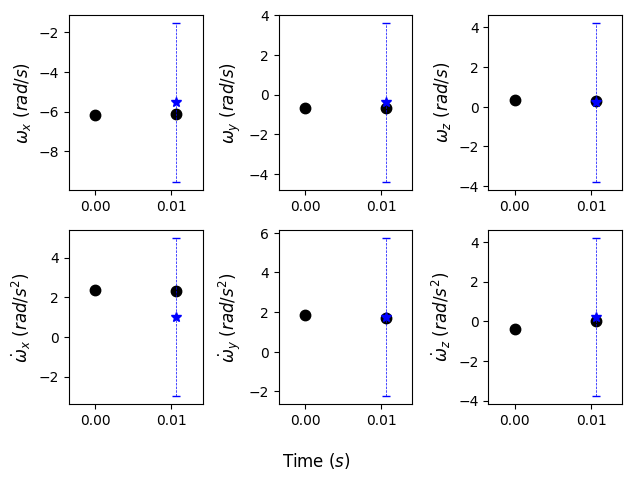

Current Batch Train Loss: -16.408903121948242

Current Batch Train Loss: -16.393383026123047

Current Batch Train Loss: -16.407426834106445

Current Batch Train Loss: -16.397523880004883

Current Batch Train Loss: -16.412988662719727

Current Batch Train Loss: -16.40157699584961

Current Batch Train Loss: -16.39022445678711

Current Batch Train Loss: -16.40763282775879

Current Batch Train Loss: -16.392898559570312

Current Batch Train Loss: -16.416301727294922

Current Batch Train Loss: -16.43866539001465

Current Batch Train Loss: -16.38945198059082

Current Batch Train Loss: -16.422508239746094

Current Batch Train Loss: -16.388713836669922

Current Batch Train Loss: -16.399171829223633

Current Batch Train Loss: -16.397506713867188

Current Batch Train Loss: -16.42337417602539

Current Batch Train Loss: -16.395076751708984

Current Batch Train Loss: -16.404800415039062

Current Batch Train Loss: -16.420482635498047

Current Batch Train Loss: -16.403186798095703

Current Batch Train

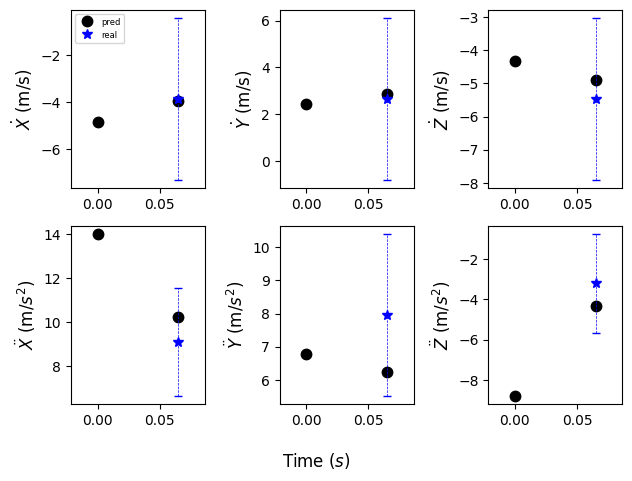

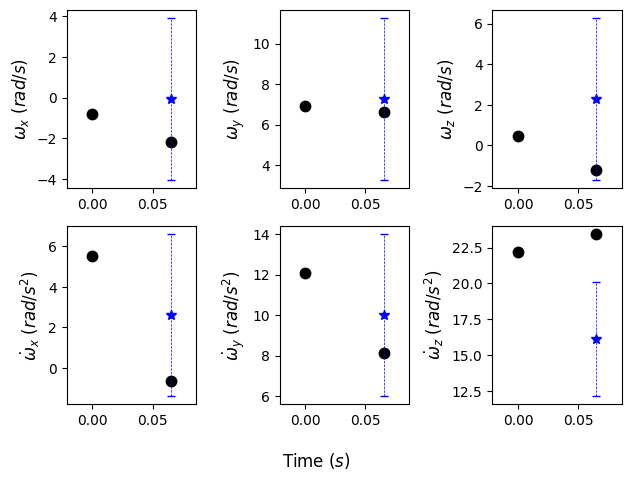

Current Batch Train Loss: -16.401649475097656

Current Batch Train Loss: -16.408525466918945

Current Batch Train Loss: -16.403705596923828

Current Batch Train Loss: -16.38051414489746

Current Batch Train Loss: -16.40083122253418

Current Batch Train Loss: -16.410722732543945

Current Batch Train Loss: -16.389698028564453

Current Batch Train Loss: -16.383159637451172

Current Batch Train Loss: -16.391828536987305

Current Batch Train Loss: -16.418296813964844

Current Batch Train Loss: -16.390722274780273

Current Batch Train Loss: -16.380990982055664

Current Batch Train Loss: -16.412670135498047

Current Batch Train Loss: -16.391700744628906

Current Batch Train Loss: -16.417600631713867

Current Batch Train Loss: -16.418903350830078

Current Batch Train Loss: -16.428630828857422

Current Batch Train Loss: -16.396324157714844

Current Batch Train Loss: -16.385173797607422

Current Batch Train Loss: -16.427988052368164

Current Batch Train Loss: -16.391483306884766

Current Batch T

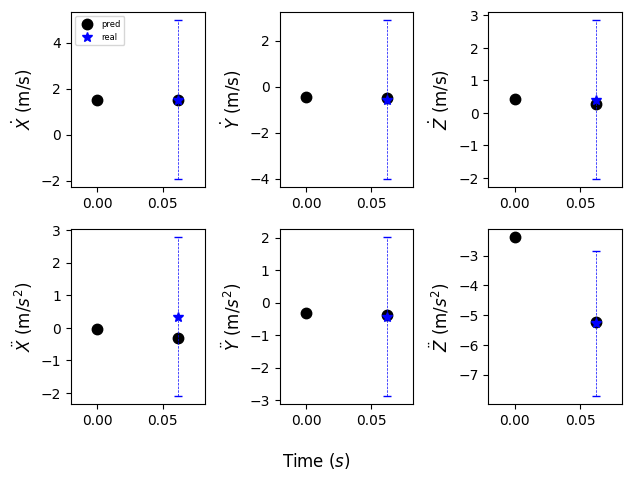

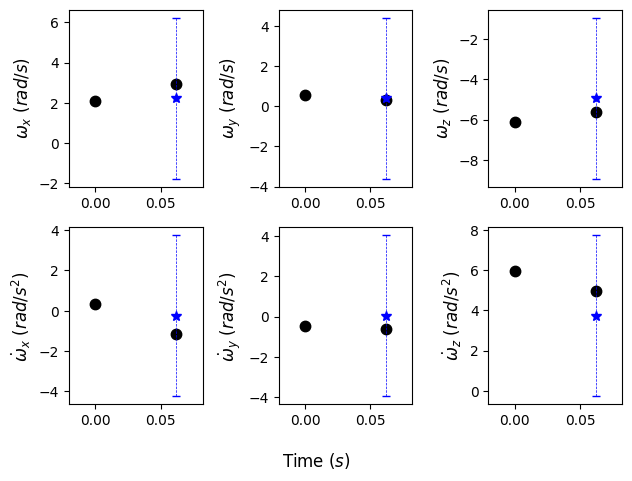

Current Batch Train Loss: -16.421781539916992

Current Batch Train Loss: -16.394001007080078



KeyboardInterrupt: 

In [13]:
# Initializing LNP model
encoder_input = torch.concat([context_x, context_y], dim=-1)
encoder_size = encoder_input.shape[2]

model = AttLNP(
    encoder_size=encoder_size,
    use_deterministic_path=True,
    rep_transform='mlp',
    att_type='mha',
    x_dim=9,
    y_dim=12
)

#model = torch.load('vel+accel-high-disturbance-mass-varying-model-600-epochs.pt')

# Initializing model's loss function and optimizer
criterion = LossFunc()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7, amsgrad=True)

# Initializing training + validation loss tracker
train_loss_array = np.array([])
train_iter_array = np.array([])
val_loss_array = np.array([])
val_AAE_array = np.array([])
val_epoch_array = np.linspace(0, NUM_EPOCHS, int(NUM_EPOCHS/PLOT_AFTER)+1)

# Initializing training loop
i = 0
for epoch in range(NUM_EPOCHS+1):

  if epoch % PLOT_AFTER == 0:
    with torch.no_grad():

      # Sampling random validation batch
      idx = random.randint(0, test_dataset.shape[0]-BATCH_SIZE)
      batch_dataset = test_dataset[idx:idx+BATCH_SIZE,:,:]
      input = batch_dataset[:,:,:9]
      output = batch_dataset[:,:,9:]

      # Defining context and target sets
      context_x = input[:,0:1,:].clone()
      context_y = output[:,0:1,:].clone()
      target_x = input.clone()
      target_y = output.clone()

      # Initializing query object for model
      query = ((context_x, context_y), target_x)

      # Collecting predicted outputs + their associated variances + loss info
      # from comparing to ground-truth dynamical data
      log_p, kl, pred_y, var = model(query, target_y, is_testing=True)

      # Collecting loss from prediction
      loss_test = criterion(log_p, kl)

      # Unnormalizing data for plotting and computing AAE
      #context_x, context_y = db.minmax_unnorm(context_x, context_y)
      target_y, pred_y, var = db.minmax_unnorm(target_y, pred_y, var)

      # Computing average absolute error (AAE) over current testing batch
      AE_array = compute_AE(target_y.detach().numpy(), pred_y.detach().numpy())
      test_batch_AAE = np.mean(AE_array)
      test_batch_AAE_std = np.std(AE_array)
      val_AAE_array = np.concatenate([val_AAE_array, np.array([test_batch_AAE])], axis=0)

      # Recording performance after every 'PLOT_AFTER' iterations
      print(f"Epoch: {epoch}, Batch Testing Loss: {loss_test}, Batch Testing Average AE: {test_batch_AAE} w/ Standard Deviation: {test_batch_AAE_std}")

      # Plotting testing GP sample vs the corresponding LNP prediction
      plot_all_functions(context_x,context_y,target_x,target_y, pred_y, var)

      # Collecting validation loss history
      val_loss_array = np.concatenate([val_loss_array, np.array([loss_test])], axis=0)

  # Executing training loop
  for batch in range(0, train_dataset.shape[0], BATCH_SIZE):
    # Parsing batch dataset
    batch_dataset = train_dataset[batch:batch+BATCH_SIZE,:,:]
    input = batch_dataset[:,:,:9]
    output = batch_dataset[:,:,9:]

    # Defining context and target sets
    context_x = input[:,0:1,:].clone()
    context_y = output[:,0:1,:].clone()
    target_x = input.clone()
    target_y = output.clone()

    # generating new batch of functions sampled from GP
    query = ((context_x, context_y), target_x)

    # zero the parameter gradients for each batch
    optimizer.zero_grad()

    # forward + back propogation + optimizer step
    log_p, kl, pred_y, _ = model(query, target_y)
    loss_train = criterion(log_p, kl)
    loss_train.backward()
    optimizer.step()

    # Collecting training loss history after every 'COLLECT_LOSS_AFTER' iters
    if i % COLLECT_TRAINING_LOSS_AFTER == 1:
      print(f"Current Batch Train Loss: {loss_train.item()}\n")
      train_loss_array = np.concatenate([train_loss_array, np.array([loss_train.detach()])], axis=0)
      train_iter_array = np.concatenate([train_iter_array, np.array([i])], axis=0)
    i += 1

  train_dataset = shuffle_data(train_dataset)  

In [36]:
n = np.linspace(1,100,100)

prob_array = np.zeros_like(n)

for i in range(n.shape[0]):
    prob = 1 - (math.factorial(365) / math.factorial(365 - int(n[i]))) / 365 ** (n[i])
    prob_array[i] = prob

In [34]:
i

124

In [37]:
prob_array

array([0.        , 0.00273973, 0.00820417, 0.01635591, 0.02713557,
       0.04046248, 0.0562357 , 0.07433529, 0.09462383, 0.11694818,
       0.14114138, 0.16702479, 0.19441028, 0.22310251, 0.25290132,
       0.28360401, 0.31500767, 0.34691142, 0.37911853, 0.41143838,
       0.44368834, 0.47569531, 0.50729723, 0.53834426, 0.5686997 ,
       0.59824082, 0.62685928, 0.65446147, 0.68096854, 0.70631624,
       0.73045463, 0.75334753, 0.77497185, 0.79531686, 0.81438324,
       0.83218211, 0.84873401, 0.86406782, 0.87821966, 0.89123181,
       0.90315161, 0.91403047, 0.92392286, 0.93288537, 0.9409759 ,
       0.94825284, 0.9547744 , 0.96059797, 0.96577961, 0.97037358,
       0.97443199, 0.97800451, 0.98113811, 0.98387696, 0.98626229,
       0.98833235, 0.99012246, 0.99166498, 0.99298945, 0.99412266,
       0.9950888 , 0.99590957, 0.99660439, 0.99719048, 0.99768311,
       0.9980957 , 0.99844004, 0.99872639, 0.99896367, 0.99915958,
       0.99932075, 0.99945288, 0.99956081, 0.99964864, 0.99971

In [15]:
torch.save(model, 'vel+accel-high-disturbance-mass-varying-model-250-epochs.pt')

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"name: {name}, param.data, {param.data}")

name: latent_encoder_network.to_hidden.weight, param.data, tensor([[-0.0169,  0.0079,  0.0138,  ..., -0.0805, -0.1440, -0.1092],
        [-0.0011, -0.0011, -0.0009,  ...,  0.0992, -0.1093, -0.0026],
        [-0.0045, -0.0045, -0.0043,  ...,  0.1069,  0.0339, -0.0051],
        ...,
        [-0.0091, -0.0242, -0.0075,  ..., -0.1279, -0.1555,  0.0793],
        [-0.0046,  0.0008, -0.0055,  ..., -0.0360, -0.1630, -0.0339],
        [ 0.0392,  0.0219, -0.0281,  ...,  0.0993,  0.0646, -0.0031]])
name: latent_encoder_network.to_hidden.bias, param.data, tensor([-0.0825, -0.0020, -0.0094, -0.0248,  0.0024,  0.0286,  0.0298,  0.0258,
         0.0275, -0.0118, -0.0577, -0.0253,  0.0103, -0.0642, -0.0813, -0.0308,
        -0.0010,  0.0015, -0.0075,  0.1025,  0.0403, -0.0743, -0.0425,  0.1227,
        -0.0397,  0.0738,  0.0193, -0.0039, -0.0103, -0.0025, -0.0559,  0.0932,
         0.0760,  0.1095, -0.0051,  0.0004,  0.0366, -0.0385, -0.1020, -0.0095,
        -0.0071, -0.0355, -0.0504, -0.0949,  0.076

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

writer.add_graph(model, [query, target_y])
writer.close()

In [40]:
loss_array = np.array([])
AAE_array = np.array([])
for batch in range(0, test_dataset.shape[0], BATCH_SIZE):
    
    batch_dataset = test_dataset[batch:batch+BATCH_SIZE,:,:]
    #batch_dataset = minmax_norm(batch_dataset)

    input = batch_dataset[:,:,:17]
    output = batch_dataset[:,:,17:]

    # Defining context and target sets
    context_x = input[:,0:1,:].clone()
    context_y = output[:,0:1,:].clone()
    target_x = input.clone()
    target_y = output.clone()

    # generating new batch of functions sampled from GP
    query = ((context_x, context_y), target_x)

    # Collecting predicted outputs + their associated variances + loss info
    # from comparing to ground-truth dynamical data
    log_p, kl, pred_y, var = model(query, target_y, is_testing=True)

    # Collecting loss from prediction
    num_targets = target_x.shape[1]
    loss_test = criterion(log_p, kl, num_targets)

    # Unnormalizing data for AAE computation
    context_x, context_y = db.minmax_unnorm(context_x, context_y)
    target_x, target_y, pred_y, var = db.minmax_unnorm(target_x, target_y, pred_y, var)

    # Computing average absolute error (AAE) over current testing batch 
    val_batch_AAE = np.mean(compute_AE(target_y.detach().numpy(), pred_y.detach().numpy()))

    # Collecting validation loss and AAE history
    loss_array = np.concatenate([loss_array, np.array([loss_test.detach()])], axis=0)
    AAE_array = np.concatenate([AAE_array, np.array([val_batch_AAE])], axis=0)

print(f"Average Validation Loss Across Batches: {np.mean(loss_array)}, Average Validation AAE Across Batches: {np.mean(AAE_array)}")

Average Validation Loss Across Batches: -4.134170302804911, Average Validation AAE Across Batches: 3.311296629455854


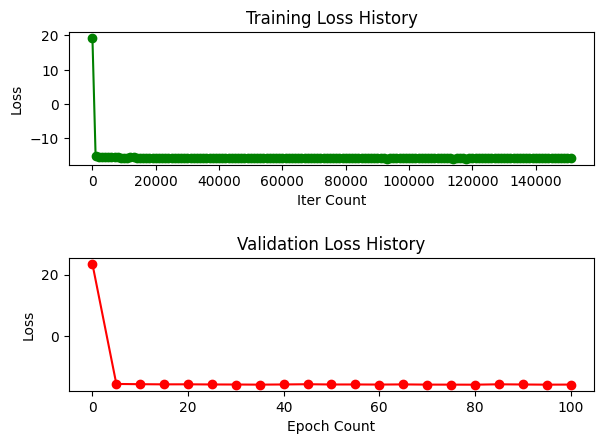

In [27]:
val_epoch_array = np.linspace(0, NUM_EPOCHS, int(NUM_EPOCHS/PLOT_AFTER)+1)

# Plotting both training+testing loss vs iteration
figure, axis = plt.subplots(2,1)
axis[0].plot(train_iter_array[::20], train_loss_array[::20], 'go-')
axis[0].set_xlabel('Iter Count')
axis[0].set_ylabel('Loss')
axis[0].set_title('Training Loss History')

axis[1].plot(val_epoch_array[::5], val_loss_array[::5], 'ro-')
axis[1].set_xlabel('Epoch Count')
axis[1].set_ylabel('Loss')
axis[1].set_title('Validation Loss History')


figure.tight_layout(pad=2.0)
plt.show()

Text(0.5, 1.0, 'Validation Average Absolute Prediction Error History')

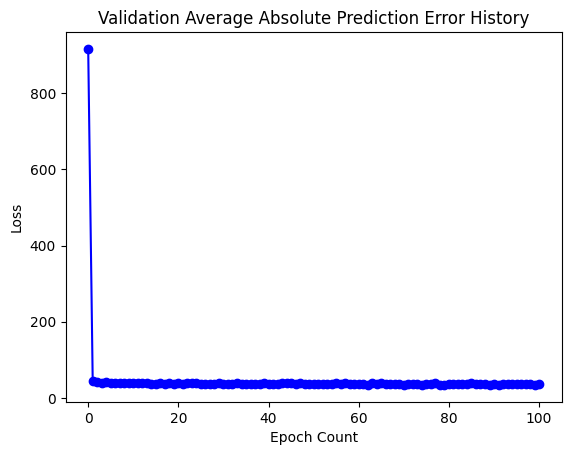

In [28]:
plt.plot(val_epoch_array, val_AAE_array, 'bo-')
plt.xlabel('Epoch Count')
plt.ylabel('Loss')
plt.title('Validation Average Absolute Prediction Error History')

In [21]:
np.save('test_AAE_array_high_disturbance_no_noise.npy', val_AAE_array)

### Evaluation: Predicted Context Mode

In [10]:
xydot_offset=60.0
min_Zdot = -30
max_Zdot = 30
min_accel_xy = -20
max_accel_xy = 20
min_accel_z = -20
max_accel_z = 20 
min_omega=-80
max_omega=80
min_omegadot=-80
max_omegadot=80
wind_vel_offset = 25
min_rotor_rps = 0
max_rotor_rps = 1000

# Defining minmax array for normalization/unnormalization
minmax_data = torch.tensor([[0, 0], #dt
                            [min_rotor_rps, max_rotor_rps],
                            [min_rotor_rps, max_rotor_rps],
                            [min_rotor_rps, max_rotor_rps],
                            [min_rotor_rps, max_rotor_rps],
                            [-wind_vel_offset, wind_vel_offset],
                            [-wind_vel_offset, wind_vel_offset],
                            [-wind_vel_offset, wind_vel_offset],
                            [-xydot_offset, xydot_offset],
                            [-xydot_offset, xydot_offset],
                            [min_Zdot, max_Zdot],
                            [min_accel_xy, max_accel_xy],
                            [min_accel_xy, max_accel_xy],
                            [min_accel_z, max_accel_z],
                            [min_omega, max_omega],
                            [min_omega, max_omega],
                            [min_omega, max_omega],
                            [min_omegadot, max_omegadot],
                            [min_omegadot, max_omegadot],
                            [min_omegadot, max_omegadot]])

In [48]:
def compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(target_y[:,-1,:] - pred_y[:,-1,:])
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((target_y[:,-1,:] - pred_y[:,-1,:]) / target_y[:,-1,:]) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array


In [178]:
l = torch.abs(((target_y[:,-1,:] - pred_y[:,-1,:]) / target_y[:,-1,:])) * 100
l

tensor([[ 13.3240,  32.9785,   1.3692, 133.2717, 662.3981,  65.6425,  45.9764,
         129.6000, 174.0904,  18.5956,  82.5909,  28.4092]],
       grad_fn=<MulBackward0>)

In [179]:
target_y[:,-1,:]

tensor([[ 4.2581, -3.3443, -5.8115,  2.1199, -0.2772, -3.9335, -1.0402, -1.6886,
          0.7284,  1.4303, -0.8567,  3.0325]])

In [180]:
pred_y[:,-1,:]

tensor([[ 3.6908, -2.2414, -5.8911, -0.7053, -2.1134, -6.5156, -0.5620,  0.4998,
          1.9966,  1.1643, -1.5643,  3.8941]], grad_fn=<SliceBackward0>)

Random Trajectory Mode

In [ ]:
NP_dataset = np.load('PINN_dataset_for_NP_mass_varying_updated4.npy')

In [24]:
# Initializing models used in evaluation
model1 = torch.load('vel+accel-high-disturbance-mm-noise-model-1370-epochs.pt')
#model2 = torch.load('large-ss-medium-disturbance-medium-noise-model.pt')
#model3 = torch.load('large-ss-slow-vel-low-noise-model.pt')
model_list = [model1]
num_models = len(model_list)

'''
# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 1
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = 100 
wind_vel_array = 10 * torch.ones([3,])
#disturb_quad_at_array = torch.linspace(1,100,num_perturb_profiles)

gps_bias_profile = 1e-2 * np.ones([num_perturb_profiles,]) #np.linspace(0, 0.2, num_perturb_profiles)
gps_std_profile = 1e-1 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,0.6,num_perturb_profiles)
gyro_bias_profile = 1e-3 * np.ones([num_perturb_profiles,]) #np.linspace(0,0.5,num_perturb_profiles)
gyro_std_profile = 1e-5 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,1e-2,num_perturb_profiles)
disturb_quad_at_array = 10   #np.linspace(1,100,num_perturb_profiles)
'''
#perturb_params[:,2] = disturb_quad_at_array

# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 1
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = 100 
wind_vel_array = 20
perturb_params[0,0] = rotor_spike_profile
perturb_params[0,1] = wind_vel_array


# Sampling random trajectory data 
sample_length = 100
test_db = Quadrotor_Dynamics_Generator(normalize=False)
test_traj = torch.from_numpy(np.load('test_traj_GT.npy')) #test_db.generate_test_traj(seq_length=sample_length, perturb_params=perturb_params[0,:], gaussian_noise=True)
test_traj = test_db.convert2new(test_traj.clone())
test_traj = test_db.minmax_norm(test_traj)

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_models, sample_length])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Initializing array that will contain model predictions
eval_data = torch.zeros([num_models, 3, sample_length, 12])
eval_data[:,0:1,0:1,:] = torch.tile(torch.unsqueeze(test_traj[0:1,0:1,8:], dim=0), dims=[num_models, 1, 1, 1])


# Initializing plotting parameters
Xdot = np.zeros([num_models, sample_length])
Ydot = np.zeros([num_models, sample_length])
Zdot = np.zeros([num_models, sample_length])
ωx = np.zeros([num_models, sample_length])
ωy = np.zeros([num_models, sample_length])
ωz = np.zeros([num_models, sample_length])
Xdot_pred = np.zeros([num_models, sample_length])
Ydot_pred = np.zeros([num_models, sample_length])
Zdot_pred = np.zeros([num_models, sample_length])
ωx_pred = np.zeros([num_models, sample_length])
ωy_pred = np.zeros([num_models, sample_length])
ωz_pred = np.zeros([num_models, sample_length])

Xdot_var = np.zeros([num_models, sample_length])
Ydot_var = np.zeros([num_models, sample_length])
Zdot_var = np.zeros([num_models, sample_length])
ωx_var = np.zeros([num_models, sample_length])
ωy_var = np.zeros([num_models, sample_length])
ωz_var = np.zeros([num_models, sample_length])


# Looping through entire test trajectory
for nn in range(num_models):

  # Setting 'curr_model' to next model in list
  curr_model = model_list[nn]
  
  # Resetting time counter
  curr_time = 0

  # Initializing first context as first state estimate
  next_context = test_traj[0:1,0:1,8:]

  for i in range(1, sample_length):

    curr_sample = test_traj[i:i+1,:,:]
    #curr_sample[:,0:1,8:] = next_context

    curr_dt = curr_sample[:,1:2,0]
    curr_time += curr_dt 
    time_array[i] = curr_time.detach().numpy()

    context_x, context_y = curr_sample[:,0:1,:8], curr_sample[:,0:1,8:]
    target_x, target_y = curr_sample[:,:,:8], curr_sample[:,:,8:]

    query = ((context_x, context_y), target_x)

    pred_y, var = curr_model(query, is_testing=True)

    # Computing AE of current prediction
    target_y, pred_y, var = test_db.minmax_unnorm(target_y, pred_y, var)
    AE_array = compute_AE(target_y.detach().numpy(), pred_y.detach().numpy())
    test_AAE_array[nn, i] = AE_array

    eval_data[nn,0:1,i:i+1,:] = target_y[:,1:2,:]
    eval_data[nn,1:2,i-1:i+1,:] = pred_y
    eval_data[nn,2:3,i-1:i+1,:] = var

    #next_context = test_traj[i:i+1,1:2,8:] #pred_y[:,1:2,:]


  # Unnormalizing true states, their predictions, and associated variances for plotting
  Xdot[nn,:] = eval_data[nn,0,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot[nn,:] = eval_data[nn,0,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot[nn,:] = eval_data[nn,0,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()

  Xdot_pred[nn,:] = eval_data[nn,1,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot_pred[nn,:] = eval_data[nn,1,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot_pred[nn,:] = eval_data[nn,1,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()
  
  ωx[nn,:] = eval_data[nn,0,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy[nn,:] = eval_data[nn,0,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz[nn,:] = eval_data[nn,0,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  ωx_pred[nn,:] = eval_data[nn,1,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy_pred[nn,:] = eval_data[nn,1,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz_pred[nn,:] = eval_data[nn,1,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  Xdot_var[nn,:] = eval_data[nn,2,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0])).detach().numpy())
  Ydot_var[nn,:] = eval_data[nn,2,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0])).detach().numpy())
  Zdot_var[nn,:] = eval_data[nn,2,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0])).detach().numpy())
  
  ωx_var[nn,:] = eval_data[nn,2,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy())
  ωy_var[nn,:] = eval_data[nn,2,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy())
  ωz_var[nn,:] = eval_data[nn,2,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy())


model_AAE_array = np.mean(test_AAE_array, axis=1)
#print(f"AAE Results\nNo Noise/Disturbance: {model_AAE_array[2]}, Medium Noise/Disturbance: {model_AAE_array[1]}, High Noise/Disturbance: {model_AAE_array[0]}")

/tmp/ipykernel_6118/67974674.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_6118/67974674.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[nn, i] = AE_array


In [19]:
perturb_params.shape

(1, 2)

In [25]:
model_AAE_array

array([11.88810162])

In [15]:
np.median(test_AAE_array)

10.10560131072998

### Plotting Predictions vs Ground-Truth

In [26]:
# Defining length of plotted trajectories (ensure its <= to sample_length)
plt_idx = 120

In [ ]:
# Parsing PINN Predictions
X_pred_PINN1 = np.load('X_pred_PINN4.npy')
Y_pred_PINN1 = np.load('Y_pred_PINN4.npy')
Z_pred_PINN1 = np.load('Z_pred_PINN4.npy')
Roll_pred_PINN1 = np.load('Roll_pred_PINN4.npy')
Pitch_pred_PINN1 = np.load('Pitch_pred_PINN4.npy')
Yaw_pred_PINN1 = np.load('Yaw_pred_PINN4.npy')

In [34]:
# Xdot Arrays
array1 = np.load('test_traj_xdot_AttNP.npy')
array2 = np.load('test_traj_xdot_DKF.npy')
array3 = np.load('test_traj_xdot_PINN.npy')

# Ydot Arrays
array4 = np.load('test_traj_ydot_AttNP.npy')
array5 = np.load('test_traj_ydot_DKF.npy')
array6 = np.load('test_traj_ydot_PINN.npy')

# Zdot Arrays
array7 = np.load('test_traj_zdot_AttNP.npy')
array8 = np.load('test_traj_zdot_DKF.npy')
array9 = np.load('test_traj_zdot_PINN.npy')

# ωx Arrays
array10 = np.load('test_traj_ωx_AttNP.npy')
array11 = np.load('test_traj_ωx_DKF.npy')
array12 = np.load('test_traj_ωx_PINN.npy')

# ωy Arrays
array13 = np.load('test_traj_ωy_AttNP.npy')
array14 = np.load('test_traj_ωy_DKF.npy')
array15 = np.load('test_traj_ωy_PINN.npy')

# ωz Arrays
array16 = np.load('test_traj_ωz_AttNP.npy')
array17 = np.load('test_traj_ωz_DKF.npy')
array18 = np.load('test_traj_ωz_PINN.npy')

# var arrays
array19 = np.load('test_traj_xdot_AttNP_var.npy')
array20 = np.load('test_traj_ydot_AttNP_var.npy')
array21 = np.load('test_traj_zdot_AttNP_var.npy')
array22 = np.load('test_traj_ωx_AttNP_var.npy')
array23 = np.load('test_traj_ωy_AttNP_var.npy')
array24 = np.load('test_traj_ωz_AttNP_var.npy')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{X}$ (m/s)'))

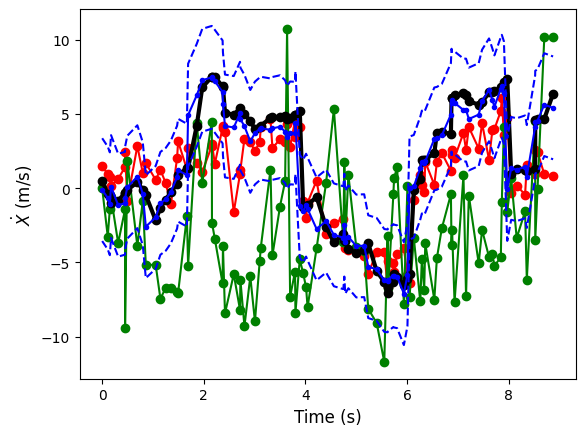

In [38]:
plt.plot(time_array[:plt_idx], array2[0,:],'-ro')
plt.plot(time_array[:plt_idx], array3[0,:], '-go')
plt.plot(time_array[:plt_idx], Xdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Xdot_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], X_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] - Xdot_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] + Xdot_var[0,:plt_idx], '--b')


plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{X}$ (m/s)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Y}$ (m/s)'))

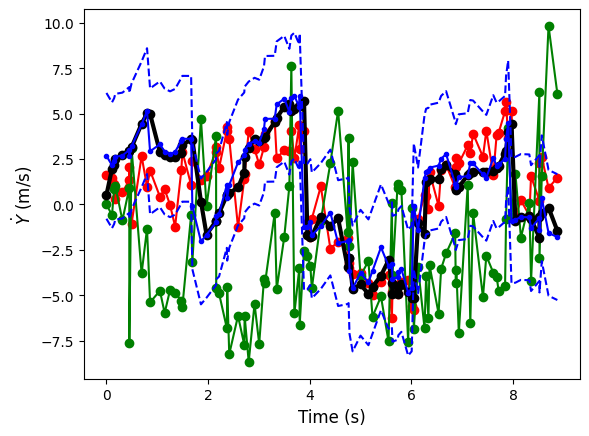

In [41]:
plt.plot(time_array[:plt_idx], array5[0,:plt_idx], '-ro')
plt.plot(time_array[:plt_idx], array6[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], Ydot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Y_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Y_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] - Ydot_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] + Ydot_var[0,:plt_idx], '--b')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Y}$ (m/s)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$Z$ (m)'))

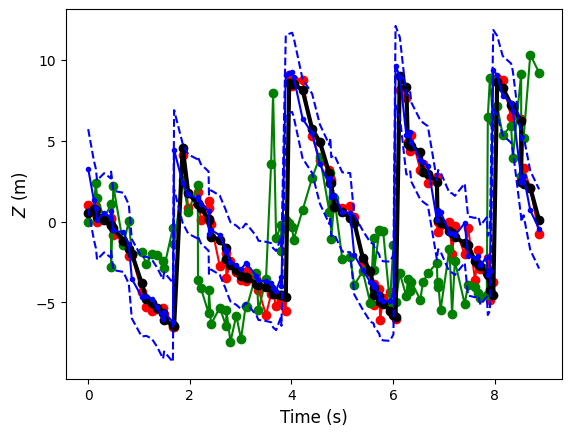

In [42]:
plt.plot(time_array[:plt_idx], array8[0,:plt_idx], '-ro')
plt.plot(time_array[:plt_idx], array9[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], Zdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] - Zdot_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] + Zdot_var[0,:plt_idx], '--b')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$Z$ (m)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\omega_{x}$ (rad/s)'))

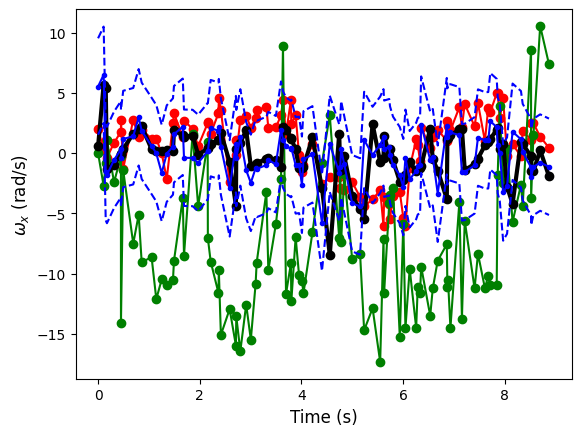

In [51]:
plt.plot(time_array[:plt_idx], array11[0,:plt_idx], '-ro')
plt.plot(time_array[:plt_idx], array12[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], ωx[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] - ωx_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] + ωx_var[0,:plt_idx], '--b')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\omega_{x}$ (rad/s)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
#plt.ylim([-2*pi,2*pi])

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\omega_y$ (rad/s)'))

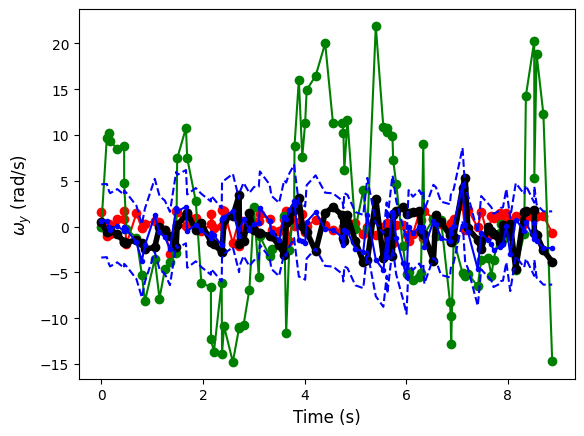

In [52]:
plt.plot(time_array[:plt_idx], array14[0,:plt_idx], '-ro')
plt.plot(time_array[:plt_idx], array15[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], ωy[0,:plt_idx], '-ko', linewidth=4)
plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] - ωy_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] + ωy_var[0,:plt_idx], '--b')

#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\omega_y$ (rad/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\psi$ (rad)'))

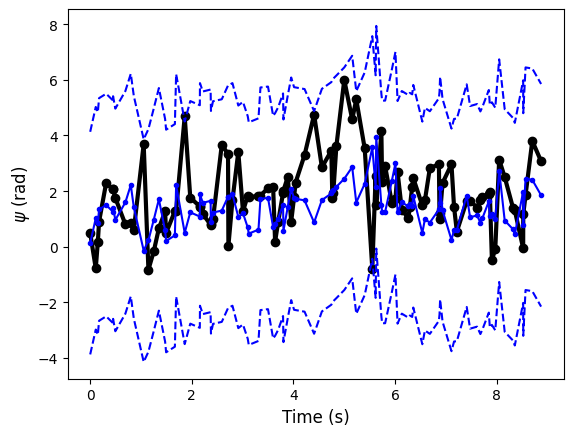

In [33]:
plt.plot(time_array[:plt_idx], ωz[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] - ωz_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] + ωz_var[0,:plt_idx], '--b')


#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\psi$ (rad)", fontsize=12)

In [91]:
orig_traj.shape

torch.Size([100, 2, 38])

In [89]:
np.save('test_traj_GT.npy', orig_traj)

In [90]:
np.save('test_traj_xdot_AttNP.npy', Xdot_pred)
np.save('test_traj_ydot_AttNP.npy', Ydot_pred)
np.save('test_traj_zdot_AttNP.npy', Zdot_pred)
np.save('test_traj_xdot_AttNP_var.npy', Xdot_var)
np.save('test_traj_ydot_AttNP_var.npy', Ydot_var)
np.save('test_traj_zdot_AttNP_var.npy', Zdot_var)
np.save('test_traj_ωx_AttNP.npy', ωx_pred)
np.save('test_traj_ωy_AttNP.npy', ωy_pred)
np.save('test_traj_ωz_AttNP.npy', ωz_pred)
np.save('test_traj_ωx_AttNP_var.npy', ωx_var)
np.save('test_traj_ωy_AttNP_var.npy', ωy_var)
np.save('test_traj_ωz_AttNP_var.npy', ωz_var)

In [23]:
gt_array = np.load('test_traj_GT.npy')
gt_array.shape

(100, 2, 38)

In [11]:
# Xdot Arrays
array1 = np.load('test_traj_xdot_AttNP.npy')
array2 = np.load('test_traj_xdot_DKF.npy')
array3 = np.load('test_traj_xdot_PINN.npy')

# Ydot Arrays
array4 = np.load('test_traj_ydot_AttNP.npy')
array5 = np.load('test_traj_ydot_DKF.npy')
array6 = np.load('test_traj_ydot_PINN.npy')

# Zdot Arrays
array7 = np.load('test_traj_zdot_AttNP.npy')
array8 = np.load('test_traj_zdot_DKF.npy')
array9 = np.load('test_traj_zdot_PINN.npy')

# ωx Arrays
array10 = np.load('test_traj_ωx_AttNP.npy')
array11 = np.load('test_traj_ωx_DKF.npy')
array12 = np.load('test_traj_ωx_PINN.npy')

# ωy Arrays
array13 = np.load('test_traj_ωy_AttNP.npy')
array14 = np.load('test_traj_ωy_DKF.npy')
array15 = np.load('test_traj_ωy_PINN.npy')

# ωz Arrays
array16 = np.load('test_traj_ωz_AttNP.npy')
array17 = np.load('test_traj_ωz_DKF.npy')
array18 = np.load('test_traj_ωz_PINN.npy')

# var arrays
array19 = np.load('test_traj_xdot_AttNP_var.npy')
array20 = np.load('test_traj_ydot_AttNP_var.npy')
array21 = np.load('test_traj_zdot_AttNP_var.npy')
array22 = np.load('test_traj_ωx_AttNP_var.npy')
array23 = np.load('test_traj_ωy_AttNP_var.npy')
array24 = np.load('test_traj_ωz_AttNP_var.npy')


# Formatting arrays into plottable form
Xdot_pred_array = np.concatenate([array1, array2, array3], axis=0)
Ydot_pred_array = np.concatenate([array4,array5,array6], axis=0)
Zdot_pred_array = np.concatenate([array7,array8,array9], axis=0)
ωx_pred_array = np.concatenate([array10,array11,array12], axis=0)
ωy_pred_array = np.concatenate([array13,array14,array15], axis=0)
ωz_pred_array = np.concatenate([array16,array17,array18], axis=0)

var_array = np.concatenate([array19,
                            array20,
                            array21,
                            array22,
                            array23,
                            array24], axis=0)

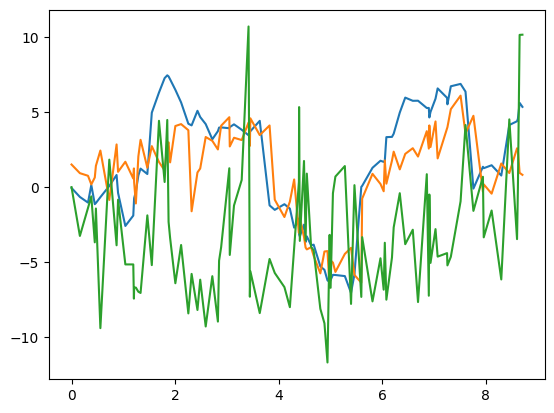

In [21]:
# Xdot Arrays

plt.plot(time_array, array1[0,:])
plt.plot(time_array, array2[0,:])
plt.plot(time_array, array3[0,:])

In [26]:
var_array.shape

(6, 100)

In [28]:
# Storing plotting variables to be used
gt_array = np.zeros([6, sample_length])
gt_array[0,:] = Xdot[0,:]
gt_array[1,:] = Ydot[0,:]
gt_array[2,:] = Zdot[0,:]
gt_array[3,:] = ωx[0,:]
gt_array[4,:] = ωy[0,:]
gt_array[5,:] = ωz[0,:]


pred_array = np.zeros([3, 6, sample_length])
pred_array[:,0,:] = Xdot_pred_array
pred_array[:,1,:] = Ydot_pred_array
pred_array[:,2,:] = Zdot_pred_array
pred_array[:,3,:] = ωx_pred_array
pred_array[:,4,:] = ωy_pred_array
pred_array[:,5,:] = ωz_pred_array

In [29]:
pred_array.shape

(3, 6, 100)

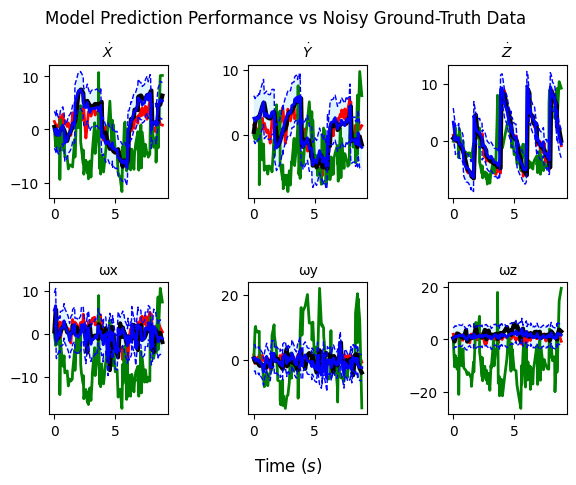

In [37]:
num_rows = 2
num_columns = 3
figure, axis = plt.subplots(num_rows, num_columns)

# Plotting all positional states 
i = 0
plt_titles = [r'$\dot{X}$', r'$\dot{Y}$', r'$\dot{Z}$', r'ωx', r'ωy', r'ωz']

for row in range(num_rows):
  for column in range(num_columns):
    axis[row,column].plot(time_array[:plt_idx], pred_array[1,i,:plt_idx], '-r', linewidth=2)
    axis[row,column].plot(time_array[:plt_idx], pred_array[2,i,:plt_idx], '-g', linewidth=2)
    axis[row,column].plot(time_array[:plt_idx], gt_array[i,:plt_idx], '-k', linewidth=3)
    axis[row,column].plot(time_array[:plt_idx], pred_array[0,i,:plt_idx], '-b', linewidth=2)
    axis[row,column].plot(time_array[:plt_idx], pred_array[0,i,:plt_idx] - var_array[i,:plt_idx], 'b--', linewidth=1)
    axis[row,column].plot(time_array[:plt_idx], pred_array[0,i,:plt_idx] + var_array[i,:plt_idx], 'b--', linewidth=1)
    axis[row,column].set_title(f"{plt_titles[i]}", fontsize=10)
    axis[row,column].fill_between(
        time_array[:plt_idx],
        pred_array[0, i, :plt_idx] - var_array[i,:plt_idx],
        pred_array[0, i, :plt_idx] + var_array[i,:plt_idx],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)
    #if row == 0 and column == 0: axis[row,column].legend(['pred','real','context'], fontsize=6)
    plt.plot()
    #axis[row,column].set_xticks([time_array[0], time_array[plt_idx]])
    axis[row,column].grid(False)
    i+=1

figure.tight_layout(pad=3.0)
figure.supxlabel(r"Time $(s)$")
figure.suptitle('Model Prediction Performance vs Noisy Ground-Truth Data ')
plt.show()


In [ ]:
# Storing plotting variables to be used
gt_array = np.zeros([6, sample_length])
gt_array[0,:] = X[0,:]
gt_array[1,:] = Y[0,:]
gt_array[2,:] = Z[0,:]
gt_array[3,:] = THETA[0,:,0]
gt_array[4,:] = THETA[0,:,1]
gt_array[5,:] = THETA[0,:,2]


pred_array = np.zeros([3, 6, sample_length])
pred_array[:,0,:] = X_pred
pred_array[:,1,:] = Y_pred
pred_array[:,2,:] = Z_pred
pred_array[:,3,:] = THETA_pred[:,:,0]
pred_array[:,4,:] = THETA_pred[:,:,1]
pred_array[:,5,:] = THETA_pred[:,:,2]

var_array = np.zeros([sample_length, 6])
var_array[:,0] = X_var[0,:]
var_array[:,1] = Y_var[0,:]
var_array[:,2] = Z_var[0,:]
var_array[:,3] = THETA_var[0,:,0]
var_array[:,4] = THETA_var[0,:,1]
var_array[:,5] = THETA_var[0,:,2]

PINN_array = np.zeros([sample_length, 6])
PINN_array[:,0] = X_pred_PINN1
PINN_array[:,1] = Y_pred_PINN1
PINN_array[:,2] = Z_pred_PINN1
PINN_array[:,3] = Roll_pred_PINN1
PINN_array[:,4] = Pitch_pred_PINN1
PINN_array[:,5] = Yaw_pred_PINN1


num_rows = 2
num_columns = 3
figure, axis = plt.subplots(num_rows, num_columns)

# Plotting all positional states 
i = 0
plt_titles = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']

for row in range(num_rows):
  for column in range(num_columns):

    axis[row,column].plot(time_array, gt_array[i,:], '-k', linewidth=3)
    axis[row,column].plot(time_array, PINN_array[:,i], '-r', linewidth=1)
    axis[row,column].plot(time_array, pred_array[0,i,:], '-b', linewidth=1)
    axis[row,column].plot(time_array, pred_array[0,i,:] - var_array[:, i], 'b--', linewidth=1)
    axis[row,column].plot(time_array, pred_array[0,i,:] + var_array[:, i], 'b--', linewidth=1)
    axis[row,column].set_title(f"{plt_titles[i]}", fontsize=10)
    """
    axis[row,column].fill_between(
        time_array[:plt_idx],
        pred_array[0, i, :plt_idx] - var_array[:plt_idx, i],
        pred_array[0, i, :plt_idx] + var_array[:plt_idx, i],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)
    """
    if row == 1 and column in [0,2]: 
      axis[row,column].set_ylim([-2*pi,2*pi])
    elif row == 1 and column == 1:
      axis[row,column].set_ylim([-pi,pi])

    plt.plot()
    axis[row,column].set_xticks([time_array[0], time_array[-1]])
    axis[row,column].grid(False)
    i+=1

figure.tight_layout(pad=3.0)
figure.suptitle('Model Prediction Performance vs Physics-Informed Baseline')
plt.show()


### Inertial Profiles vs Average Absolute Prediction Error Analysis

In [57]:
# Initializing models used in evaluation
model1 = torch.load('vel+accel-high-disturbance-mass-varying-model-250-epochs.pt')
#model2 = torch.load('large-ss-medium-disturbance-medium-noise-model.pt')
#model3 = torch.load('large-ss-slow-vel-low-noise-model.pt')
model_list = [model1]
num_models = len(model_list)

# Defining array of quadrotor mass values used in evaluation
min_m = 0.5
max_m = 20
num_inertial_profiles = 100
mass_array = torch.linspace(min_m, max_m, num_inertial_profiles)


# Sampling random trajectory data 
sample_length = 10
num_trajs = 20
test_db = Quadrotor_Dynamics_Generator(normalize=False)

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_inertial_profiles, sample_length*num_trajs])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Initializing array that will contain model predictions
#eval_data = torch.zeros([num_models, 3, sample_length, 12])
#eval_data[:,0:1,0:1,:] = torch.tile(torch.unsqueeze(test_traj[0:1,0:1,8:], dim=0), dims=[num_models, 1, 1, 1])


# Looping through entire test trajectory
for profile in range(num_inertial_profiles):
    
    curr_m = mass_array[profile]
    
    count = 0
    for traj in range(num_trajs):
        
        # Sampling random trajectory data 
        test_traj = test_db.generate_test_traj(seq_length=sample_length, mass=curr_m, gaussian_noise=False)
        test_traj = test_db.convert2new(test_traj.clone())
        test_traj = test_db.minmax_norm(test_traj)
        
        # Resetting time counter
        curr_time = 0

        # Initializing first context as first state estimate
        next_context = test_traj[0:1,0:1,8:]

        for i in range(sample_length):

            curr_sample = test_traj[i:i+1,:,:]
            #curr_sample[:,0:1,8:] = next_context

            curr_dt = curr_sample[:,1:2,0]
            curr_time += curr_dt 
            time_array[i] = curr_time.detach().numpy()

            context_x, context_y = curr_sample[:,0:1,:9], curr_sample[:,0:1,9:]
            target_x, target_y = curr_sample[:,:,:9], curr_sample[:,:,9:]

            query = ((context_x, context_y), target_x)

            pred_y, var = model1(query, is_testing=True)

            # Computing AE of current prediction
            target_y, pred_y, var = test_db.minmax_unnorm(target_y, pred_y, var)
            AE_array = compute_AE(target_y.detach().numpy(), pred_y.detach().numpy())
            test_AAE_array[profile, count] = AE_array
            count += 1

model_AAE_array = np.mean(test_AAE_array, axis=1)
#print(f"AAE Results\nNo Noise/Disturbance: {model_AAE_array[2]}, Medium Noise/Disturbance: {model_AAE_array[1]}, High Noise/Disturbance: {model_AAE_array[0]}")

/tmp/ipykernel_5183/1968700405.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_5183/1968700405.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[profile, count] = AE_array


In [48]:
mass_array

tensor([ 0.5000,  0.6970,  0.8939,  1.0909,  1.2879,  1.4848,  1.6818,  1.8788,
         2.0758,  2.2727,  2.4697,  2.6667,  2.8636,  3.0606,  3.2576,  3.4545,
         3.6515,  3.8485,  4.0455,  4.2424,  4.4394,  4.6364,  4.8333,  5.0303,
         5.2273,  5.4242,  5.6212,  5.8182,  6.0152,  6.2121,  6.4091,  6.6061,
         6.8030,  7.0000,  7.1970,  7.3939,  7.5909,  7.7879,  7.9848,  8.1818,
         8.3788,  8.5758,  8.7727,  8.9697,  9.1667,  9.3636,  9.5606,  9.7576,
         9.9545, 10.1515, 10.3485, 10.5455, 10.7424, 10.9394, 11.1364, 11.3333,
        11.5303, 11.7273, 11.9242, 12.1212, 12.3182, 12.5152, 12.7121, 12.9091,
        13.1061, 13.3030, 13.5000, 13.6970, 13.8939, 14.0909, 14.2879, 14.4848,
        14.6818, 14.8788, 15.0758, 15.2727, 15.4697, 15.6667, 15.8636, 16.0606,
        16.2576, 16.4545, 16.6515, 16.8485, 17.0455, 17.2424, 17.4394, 17.6364,
        17.8333, 18.0303, 18.2273, 18.4242, 18.6212, 18.8182, 19.0152, 19.2121,
        19.4091, 19.6061, 19.8030, 20.00

In [52]:
curr_m

tensor(20.)

In [51]:
test_traj.shape

torch.Size([20, 2, 21])

In [60]:
test_traj[0,:,8]

tensor([1., 0.])

In [42]:
np.mean(test_AAE_array[0,:])

59.146605429649355

In [89]:
array1 = model_AAE_array.copy()
array1

array([62.73788801, 49.84662854, 31.17195343, 34.28628257, 28.79575238,
       25.62342277, 19.95240952, 18.34982068, 19.77956567, 16.10065094,
       16.60726799, 13.85984095, 12.55111832, 12.88858869, 15.42435311,
       11.72574317, 13.20764683, 12.27494787, 10.12864185, 11.96180412,
       13.53407331, 11.66447546, 10.31822541,  9.88733534, 10.37598509,
       11.05198532, 10.55796377,  8.23680367, 10.40182819, 11.15738703,
        8.57516162,  8.84383573, 10.42210647,  9.04002117,  9.07985867,
       10.52521693,  9.3614298 ,  9.17558394,  8.6411225 , 10.74628225,
        9.53155007,  8.24189132,  7.50615377,  9.02085424,  8.83735186,
        6.72352845,  9.05931293,  8.34178913,  6.68440118,  8.55980149,
        7.39452845,  7.76007597,  8.6765209 ,  8.46665638,  9.56507479,
        8.04577131,  8.5798495 ,  7.32702243,  8.40873893,  7.48176413,
        8.39811029,  7.85874151,  7.91624308,  7.5253314 ,  6.35957247,
        6.18267144,  9.06944852,  8.07744223,  7.17024559,  7.20

In [91]:
np.save('AttNP_AAE_array_MassVary.npy', array1)

In [111]:
perturb_AAE_array = np.mean(test_AAE_array,axis=1)
np.save('AttNP-AAE-Perturb-array.npy', perturb_AAE_array)

In [ ]:
PINN_results = np.load('perturbation_level_eval_PINN.npy')

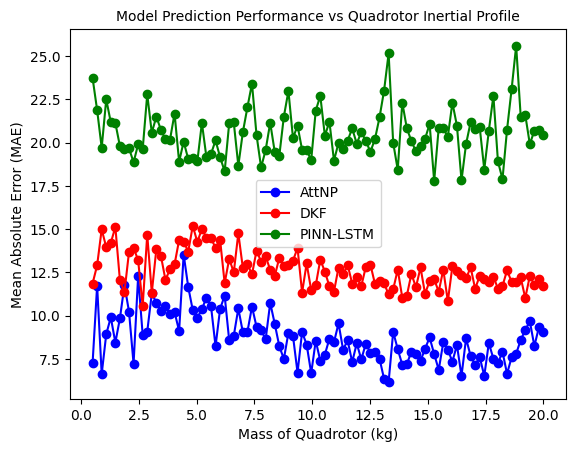

In [95]:
disturb_quad_at_array = np.linspace(0.5,20,num_inertial_profiles)

AttNP_AAE_array = np.load('AttNP_AAE_array_MassVary.npy')
DKF_AAE_array = np.load('DKF_AAE_array_MassVary.npy')
PINN_LSTM_AAE_array = np.load('PINN_AAE_array_MassVary.npy')

plt.plot(disturb_quad_at_array, AttNP_AAE_array, '-bo')
plt.plot(disturb_quad_at_array, DKF_AAE_array, '-ro')
plt.plot(disturb_quad_at_array, PINN_LSTM_AAE_array, '-go')
plt.xlabel('Mass of Quadrotor (kg)', fontsize=10), plt.ylabel('Mean Absolute Error (MAE)')
#plt.xticks(perturb_level_array)
plt.title('Model Prediction Performance vs Quadrotor Inertial Profile', fontsize=10)
plt.legend(['AttNP','DKF','PINN-LSTM'], loc='best')
#plt.savefig()
